In [4]:
#Import Modules
import numpy as np
import pandas as pd
import scipy
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

In [5]:
#Load Data
admission_annotation = pd.read_csv(f"../Key data files/admission_annotation.csv").rename(columns = {'X':'patient_ids'})
admission_norm_gene_exp = pd.read_csv(f"../Key data files/admission_norm_gene_exp_df.csv").rename(columns = {'Unnamed: 0':'gene_ids'})
delirium_cohort_demographics = pd.read_excel(f"../Key data files\delirium cohort demographics.xlsx").iloc[:128,:]
gene_symbols = pd.read_csv(f"../Key data files\gene_symbols.csv").iloc[:,1:]
serial_norm_gene_exp = pd.read_csv(f"../Key data files\serial_norm_gene_exp_df.csv").rename(columns = {'Unnamed: 0':'gene_symbols'})
serial_samples_annotation = pd.read_csv(f"../Key data files\serial_samples_annotation.csv").rename(columns = {'X':'patient_ids'})

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\grace\AppData\Local\Temp\ipykernel_8632\715775129.py:4: SyntaxWarning: invalid escape sequence '\d'
  delirium_cohort_demographics = pd.read_excel(f"../Key data files\delirium cohort demographics.xlsx").iloc[:128,:]
C:\Users\grace\AppData\Local\Temp\ipykernel_8632\715775129.py:5: SyntaxWarning: invalid escape sequence '\g'
  gene_symbols = pd.read_csv(f"../Key data files\gene_symbols.csv").iloc[:,1:]
C:\Users\grace\AppData\Local\Temp\ipykernel_8632\715775129.py:6: SyntaxWarning: invalid escape sequence '\s'
  serial_norm_gene_exp = pd.read_csv(f"../Key data files\serial_norm_gene_exp_

In [6]:
gene_symbols

,gene_ids,gene_symbols
0,ENSG00000000003,TSPAN6
1,ENSG00000000419,DPM1
2,ENSG00000000457,SCYL3
3,ENSG00000000460,C1orf112
4,ENSG00000000938,FGR
...,...,...
15310,ENSG00000283498,MIR1244-2
15311,ENSG00000283566,LOC100996792
15312,ENSG00000283632,EXOC3L2
15313,ENSG00000283646,LINC02009


In [99]:
cleaned = admission_norm_gene_exp.T
cleaned.columns = admission_norm_gene_exp.T.iloc[0,:]
cleaned = cleaned.iloc[1:,:]
cleaned = cleaned.rename(columns = {'index': 'patient_ids'})
#cleaned = cleaned.T.reset_index().merge(gene_symbols, on = "gene_ids").set_index('gene_symbols').drop(columns = {'gene_ids'}).T
cleaned['Diagnosis'] = admission_annotation['Diagnosis'].to_list()

#cleaned = cleaned.T.reset_index().set_index('gene_symbols').T


In [8]:
y = cleaned.iloc[:,-1:]
X = cleaned.iloc[:,0:-1]
X

gene_ids,ENSG00000274012,ENSG00000244734,ENSG00000188536,ENSG00000206172,ENSG00000202538,ENSG00000158578,ENSG00000200312,ENSG00000133742,ENSG00000223609,ENSG00000263740,...,ENSG00000121644,ENSG00000166619,ENSG00000265241,ENSG00000088448,ENSG00000198663,ENSG00000177479,ENSG00000103275,ENSG00000182973,ENSG00000078140,ENSG00000154144
MVIR1HS101D0PBMC1RSQ1,18.685163,17.932175,16.035154,13.760147,13.842371,12.345106,13.822952,9.934184,8.572786,13.459054,...,9.191311,10.445101,10.928632,11.158368,11.004793,11.349125,11.64686,9.814219,10.621316,10.634878
MVIR1HS107D0PBMC1RSQ1,17.64494,20.928008,18.412823,16.476078,13.12323,14.270686,12.871229,12.539489,13.922281,12.290336,...,9.044268,10.414378,10.563948,11.136085,10.78002,11.238639,11.471842,9.635421,10.415488,10.494257
MVIR1HS109D0PBMC1RSQ1,17.109929,19.02508,15.875361,15.005524,12.992272,13.143869,12.205144,11.160206,10.579923,11.665192,...,9.196305,10.604264,10.730673,11.018725,10.74457,11.125231,11.680329,9.608055,10.407175,10.517881
MVIR1HS10D0PBMC1RSQ4,8.317684,19.268316,16.648941,15.397664,6.048804,11.103061,5.234901,10.04223,9.044351,5.90233,...,9.263293,10.585767,10.500445,11.315396,10.983885,10.810117,11.34869,9.811048,10.761488,11.001319
MVIR1HS111D0PBMC1RSQ1,17.411885,11.947249,9.720248,7.92762,13.171352,6.463404,12.816903,6.025628,6.094624,12.210416,...,9.258195,10.439392,10.583444,11.15384,10.584126,10.944706,11.592284,9.72273,10.431077,10.453642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MVIR1HS92D0PBMC1RSQ1,16.031702,23.667655,21.494664,19.745895,13.943842,18.547955,8.985676,16.61906,16.256196,9.387464,...,8.858559,10.473358,10.814743,10.888499,10.842227,11.082198,11.525985,9.49553,10.570695,10.619172
MVIR1HS93D0PBMC1RSQ1,17.20088,14.947581,12.516802,9.810907,12.558799,8.710022,12.403568,6.844298,7.898617,11.584387,...,9.167019,10.620788,10.396085,11.258979,10.850142,11.096517,11.574411,9.628576,10.40157,10.595889
MVIR1HS94D0PBMC1RSQ1,18.105273,21.801644,19.656004,17.67034,13.460038,16.253286,13.400188,15.820486,15.22333,12.986658,...,9.215409,10.226281,10.48227,11.030817,10.621026,11.107376,11.244633,9.596301,10.426907,10.394739
MVIR1HS95D0PBMC1RSQ1,17.300451,17.479552,15.274942,12.650929,12.999527,9.997194,12.702459,7.547868,8.290362,11.879407,...,9.111433,10.648725,10.631574,11.104984,10.724972,10.976578,11.675193,9.483663,10.396072,10.698376


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection: Select the top K genes
k = 500  # Choose an appropriate number of top genes based on the dataset and available resources
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Make predictions and evaluate
y_pred = rf_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.782608695652174
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.33      0.25      0.29         4

    accuracy                           0.78        23
   macro avg       0.59      0.57      0.58        23
weighted avg       0.76      0.78      0.77        23



In [56]:
# Get feature importances from the model
importances = rf_model.feature_importances_

# Map the selected features back to their original gene names
selected_genes = X.columns[selector.get_support()]
feature_importance_df = pd.DataFrame({'Gene': selected_genes, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(20))  # View the top 20 important genes

rf_features = feature_importance_df.merge(gene_symbols, left_on = 'Gene', right_on = "gene_ids")[['gene_symbols',"Importance"]].head(100)

                Gene  Importance
330  ENSG00000091073    0.016124
462  ENSG00000126261    0.016016
409  ENSG00000103111    0.015967
421  ENSG00000184635    0.015181
427  ENSG00000114544    0.013764
316  ENSG00000176095    0.013425
217  ENSG00000123124    0.012040
294  ENSG00000060491    0.011750
387  ENSG00000116044    0.011638
459  ENSG00000161011    0.010568
197  ENSG00000125520    0.010536
382  ENSG00000104695    0.010137
441  ENSG00000151148    0.010038
151  ENSG00000167600    0.009866
275  ENSG00000183484    0.009214
40   ENSG00000114626    0.009210
90   ENSG00000281376    0.009102
423  ENSG00000105397    0.009081
43   ENSG00000197256    0.008959
411  ENSG00000274487    0.008657


In [65]:
feature_importance_df = feature_importance_df.iloc[200:,:]

c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


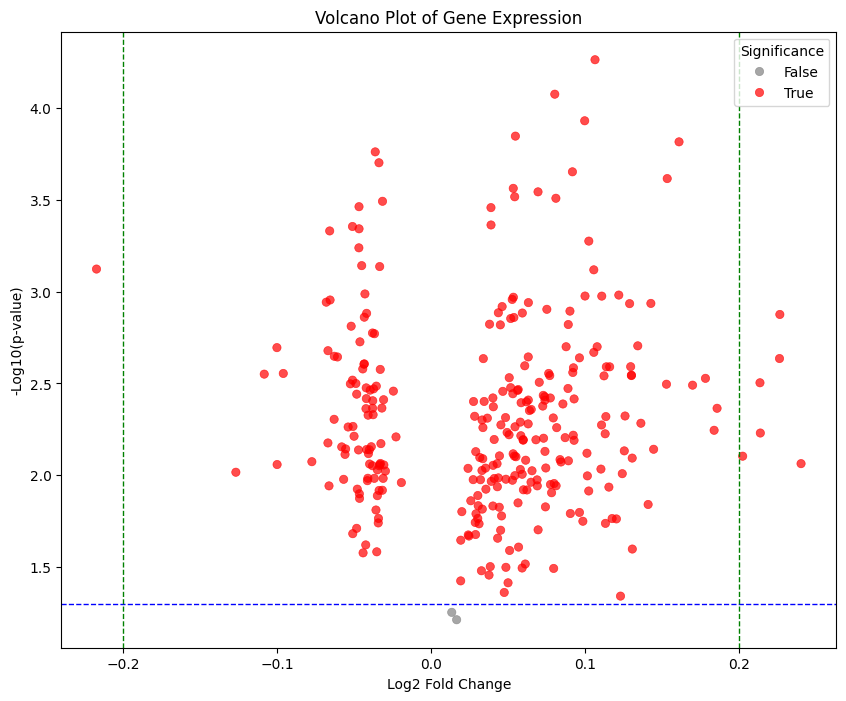

In [68]:
import seaborn as sns
data = cleaned[feature_importance_df['Gene'].tolist()+['Diagnosis']]
data.columns

mean_0 = data[data['Diagnosis'] == 0].mean(axis = 0).tolist()
mean_1 = data[data['Diagnosis'] == 1].mean(axis = 0).tolist()

mean_expression = pd.DataFrame()
mean_expression[0] = mean_0
mean_expression[1] = mean_1
mean_expression['log2FC'] = np.log2(mean_expression[1] + 1e-10) - np.log2(mean_expression[0] + 1e-10)

from scipy.stats import ttest_ind

def get_gene(gene_name, cond):
    cond_df = data[data['Diagnosis'] == cond][gene_name].tolist()
    return cond_df

p_vals = []
for i in data.columns:
    _, pval = ttest_ind(get_gene(i, 0), get_gene(i, 1))
    p_vals.append(pval)
p_vals

mean_expression['pval'] = p_vals
mean_expression['-log10(pval)'] = -np.log10(mean_expression['pval'])


plt.figure(figsize=(10, 8))
sns.scatterplot(data=mean_expression, x='log2FC', y='-log10(pval)', hue=mean_expression['-log10(pval)'] > 1.3,
                palette={True: 'red', False: 'grey'}, edgecolor=None, alpha=0.7)

# Highlight threshold lines (example thresholds)
plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.axvline(0.2, color='green', linestyle='--', linewidth=1)
plt.axvline(-0.2, color='green', linestyle='--', linewidth=1)

# Label plot
plt.title('Volcano Plot of Gene Expression')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')
plt.legend(title='Significance', loc='upper right')

In [100]:
data = cleaned
data['Diagnosis'] = cleaned['Diagnosis']
data.columns

mean_0 = data[data['Diagnosis'] == 0].mean(axis = 0).tolist()
mean_1 = data[data['Diagnosis'] == 1].mean(axis = 0).tolist()

mean_expression = pd.DataFrame()
mean_expression[0] = mean_0
mean_expression[1] = mean_1
mean_expression['log2FC'] = np.log2(mean_expression[1] + 1e-10) - np.log2(mean_expression[0] + 1e-10)
mean_expression.sort_values('log2FC')
mean_expression['gene_symbol'] = cleaned.columns

<Axes: xlabel='log2FC', ylabel='Count'>

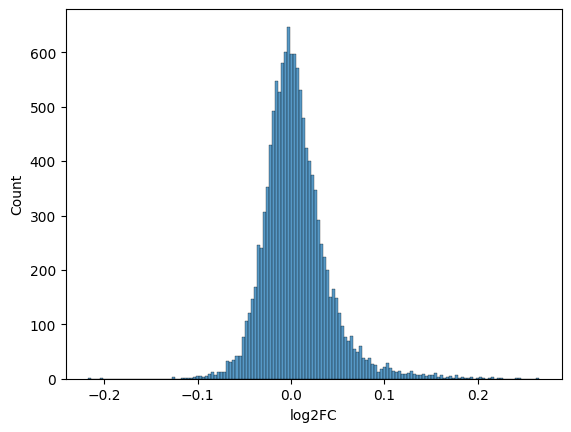

In [101]:
sns.histplot(data = mean_expression.iloc[:-1,:], x='log2FC')

In [104]:
down = mean_expression[mean_expression['log2FC'] < -0.2]['gene_symbol'].tolist()

In [105]:
up = mean_expression[mean_expression['log2FC'] > 0.2].iloc[:-1,:]['gene_symbol'].tolist()

In [106]:
features = cleaned[down+up+['Diagnosis']]

In [108]:
features.to_csv('selected_features.csv')

c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


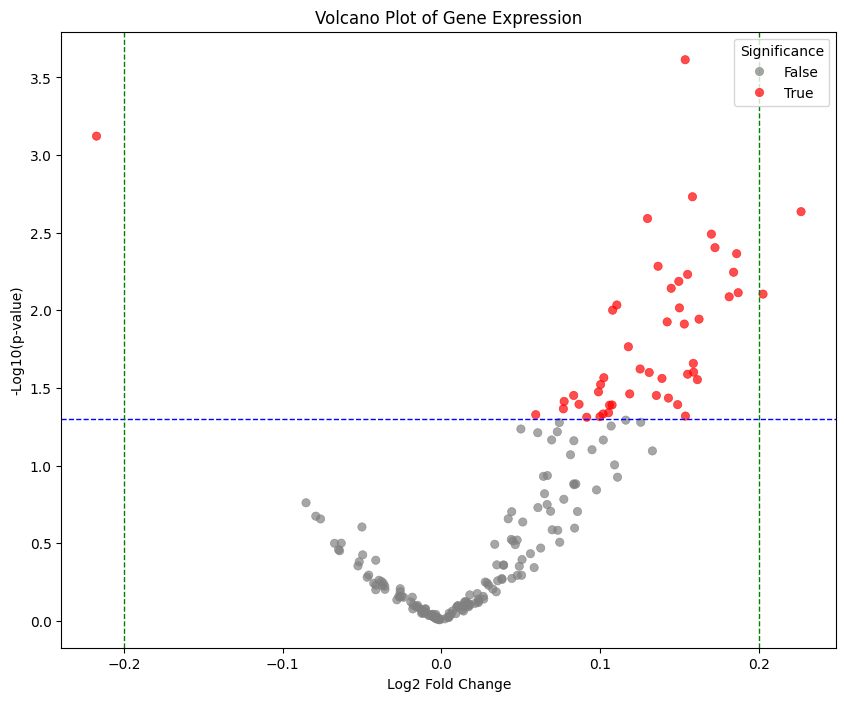

In [74]:
import seaborn as sns
data = cleaned.iloc[:,200:400]
data['Diagnosis'] = cleaned['Diagnosis']
data.columns

mean_0 = data[data['Diagnosis'] == 0].mean(axis = 0).tolist()
mean_1 = data[data['Diagnosis'] == 1].mean(axis = 0).tolist()

mean_expression = pd.DataFrame()
mean_expression[0] = mean_0
mean_expression[1] = mean_1
mean_expression['log2FC'] = np.log2(mean_expression[1] + 1e-10) - np.log2(mean_expression[0] + 1e-10)

from scipy.stats import ttest_ind

def get_gene(gene_name, cond):
    cond_df = data[data['Diagnosis'] == cond][gene_name].tolist()
    return cond_df

p_vals = []
for i in data.columns:
    _, pval = ttest_ind(get_gene(i, 0), get_gene(i, 1))
    p_vals.append(pval)
p_vals

mean_expression['pval'] = p_vals
mean_expression['-log10(pval)'] = -np.log10(mean_expression['pval'])


plt.figure(figsize=(10, 8))
sns.scatterplot(data=mean_expression, x='log2FC', y='-log10(pval)', hue=mean_expression['-log10(pval)'] > 1.3,
                palette={True: 'red', False: 'grey'}, edgecolor=None, alpha=0.7)

# Highlight threshold lines (example thresholds)
plt.axhline(-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
plt.axvline(0.2, color='green', linestyle='--', linewidth=1)
plt.axvline(-0.2, color='green', linestyle='--', linewidth=1)

# Label plot
plt.title('Volcano Plot of Gene Expression')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')
plt.legend(title='Significance', loc='upper right')

In [20]:
rf_features.to_excel("random_forest.xlsx")

In [11]:
k = 500  # You can adjust this value based on the dataset and available resources
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Logistic Regression model with L1 regularization (Lasso)
# Set `penalty='l1'` and `solver='liblinear'` for Lasso regularization
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
logreg_model.fit(X_train_selected, y_train)

# Make predictions and evaluate
y_pred = logreg_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.7391304347826086
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.33      0.50      0.40         4

    accuracy                           0.74        23
   macro avg       0.61      0.64      0.62        23
weighted avg       0.79      0.74      0.76        23



c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\grace\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Get coefficients of selected features
coefficients = logreg_model.coef_[0]

# Map the selected features back to their original gene names
selected_genes = X.columns[selector.get_support()]
feature_importance_df = pd.DataFrame({'Gene': selected_genes, 'Coefficient': coefficients})
feature_importance_df = feature_importance_df[feature_importance_df['Coefficient'] != 0]  # Keep only non-zero coefficients
feature_importance_df = feature_importance_df.sort_values(by="Coefficient", ascending=False)

print(feature_importance_df.head(20))  # View the top 20 important genes

                Gene  Coefficient
87   ENSG00000137878     0.928016
155  ENSG00000169994     0.843108
54   ENSG00000173110     0.699893
91   ENSG00000184371     0.565191
78   ENSG00000221963     0.505004
13   ENSG00000243064     0.442472
73   ENSG00000269028     0.403880
17   ENSG00000124102     0.362018
30   ENSG00000137267     0.300455
61   ENSG00000011028     0.254711
7    ENSG00000108309     0.133282
160  ENSG00000132357     0.123526
124  ENSG00000122644     0.038255
174  ENSG00000213741    -0.045196
113  ENSG00000186591    -0.069563
75   ENSG00000274180    -0.118661
434  ENSG00000213186    -0.224092
25   ENSG00000251139    -0.265076
405  ENSG00000175611    -0.339987
134  ENSG00000132514    -0.398950


In [109]:
X_train, X_test, y_train, y_test = train_test_split(cleaned.iloc[:,:-1], cleaned.iloc[:,-1], test_size=0.2, random_state=42)

In [117]:
logreg_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
logreg_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.7391304347826086
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.25      0.25      0.25         4

    accuracy                           0.74        23
   macro avg       0.55      0.55      0.55        23
weighted avg       0.74      0.74      0.74        23



In [127]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
k = 10  # You can tune this value
knn = KNeighborsClassifier(n_neighbors=k)

# Step 2: Train the model on the training data
knn.fit(X_train, y_train)

# Step 3: Make predictions on the test data
y_pred = knn.predict(X_test)

# Step 4: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Detailed performance metrics
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 86.96%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.25      0.40         4

    accuracy                           0.87        23
   macro avg       0.93      0.62      0.66        23
weighted avg       0.89      0.87      0.84        23


Confusion Matrix:
 [[19  0]
 [ 3  1]]


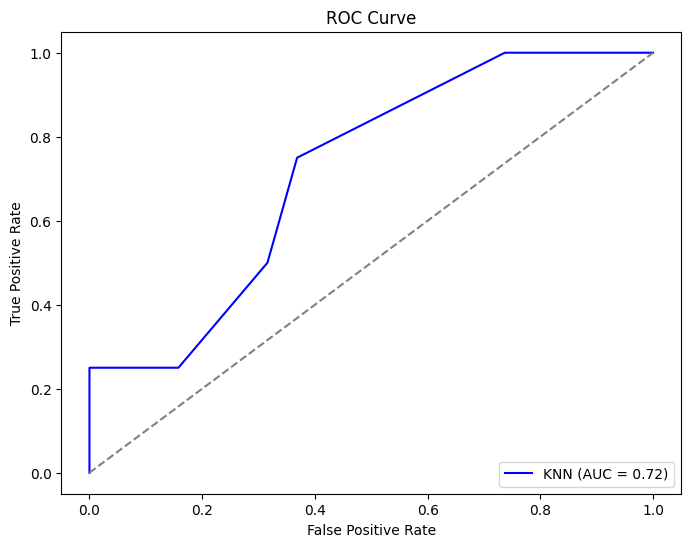

In [128]:
y_prob = knn.predict_proba(X_test)[:, 1]

# Compute FPR, TPR, and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random performance
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

In [112]:
import lightgbm as lgb

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = lgb_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: ENSG00000274012: object, ENSG00000244734: object, ENSG00000188536: object, ENSG00000206172: object, ENSG00000202538: object, ENSG00000158578: object, ENSG00000200312: object, ENSG00000133742: object, ENSG00000223609: object, ENSG00000263740: object, ENSG00000239839: object, ENSG00000265735: object, ENSG00000165949: object, ENSG00000211896: object, ENSG00000263934: object, ENSG00000252010: object, ENSG00000169877: object, ENSG00000206177: object, ENSG00000202058: object, ENSG00000200795: object, ENSG00000115590: object, ENSG00000004939: object, ENSG00000200087: object, ENSG00000129824: object, ENSG00000067048: object, ENSG00000143416: object, ENSG00000211659: object, ENSG00000198692: object, ENSG00000251562: object, ENSG00000229807: object, ENSG00000012223: object, ENSG00000204936: object, ENSG00000100985: object, ENSG00000253755: object, ENSG00000162747: object, ENSG00000164047: object, ENSG00000012817: object, ENSG00000118113: object, ENSG00000102837: object, ENSG00000168298: object, ENSG00000164821: object, ENSG00000252835: object, ENSG00000211669: object, ENSG00000197561: object, ENSG00000211895: object, ENSG00000211677: object, ENSG00000162551: object, ENSG00000211897: object, ENSG00000211950: object, ENSG00000200488: object, ENSG00000008438: object, ENSG00000211679: object, ENSG00000252481: object, ENSG00000211592: object, ENSG00000211663: object, ENSG00000212232: object, ENSG00000183878: object, ENSG00000201428: object, ENSG00000211662: object, ENSG00000166947: object, ENSG00000197061: object, ENSG00000211598: object, ENSG00000282651: object, ENSG00000278771: object, ENSG00000211637: object, ENSG00000211644: object, ENSG00000211955: object, ENSG00000204010: object, ENSG00000167768: object, ENSG00000270550: object, ENSG00000155659: object, ENSG00000132465: object, ENSG00000173868: object, ENSG00000131002: object, ENSG00000086506: object, ENSG00000124469: object, ENSG00000211956: object, ENSG00000282122: object, ENSG00000211651: object, ENSG00000211673: object, ENSG00000211934: object, ENSG00000211640: object, ENSG00000279166: object, ENSG00000239951: object, ENSG00000118520: object, ENSG00000148346: object, ENSG00000185745: object, ENSG00000245532: object, ENSG00000196415: object, ENSG00000211653: object, ENSG00000087116: object, ENSG00000243466: object, ENSG00000138772: object, ENSG00000099725: object, ENSG00000211648: object, ENSG00000013306: object, ENSG00000115155: object, ENSG00000088827: object, ENSG00000280411: object, ENSG00000163993: object, ENSG00000076864: object, ENSG00000100448: object, ENSG00000096006: object, ENSG00000086548: object, ENSG00000241351: object, ENSG00000163464: object, ENSG00000211959: object, ENSG00000211658: object, ENSG00000198336: object, ENSG00000119917: object, ENSG00000133048: object, ENSG00000211892: object, ENSG00000211899: object, ENSG00000172232: object, ENSG00000124575: object, ENSG00000211947: object, ENSG00000166333: object, ENSG00000211893: object, ENSG00000237973: object, ENSG00000211949: object, ENSG00000170476: object, ENSG00000210195: object, ENSG00000106565: object, ENSG00000180871: object, ENSG00000163958: object, ENSG00000105610: object, ENSG00000124107: object, ENSG00000211666: object, ENSG00000167434: object, ENSG00000137959: object, ENSG00000238741: object, ENSG00000249790: object, ENSG00000145335: object, ENSG00000211937: object, ENSG00000005381: object, ENSG00000134321: object, ENSG00000167548: object, ENSG00000108691: object, ENSG00000241755: object, ENSG00000211943: object, ENSG00000211660: object, ENSG00000114374: object, ENSG00000101425: object, ENSG00000123689: object, ENSG00000244437: object, ENSG00000187608: object, ENSG00000134827: object, ENSG00000210117: object, ENSG00000182885: object, ENSG00000211938: object, ENSG00000104918: object, ENSG00000211966: object, ENSG00000133063: object, ENSG00000211964: object, ENSG00000211890: object, ENSG00000140932: object, ENSG00000211962: object, ENSG00000224373: object, ENSG00000274576: object, ENSG00000186174: object, ENSG00000211945: object, ENSG00000211965: object, ENSG00000257017: object, ENSG00000211941: object, ENSG00000126709: object, ENSG00000211668: object, ENSG00000119922: object, ENSG00000250361: object, ENSG00000184792: object, ENSG00000211638: object, ENSG00000152463: object, ENSG00000272398: object, ENSG00000198876: object, ENSG00000172331: object, ENSG00000223350: object, ENSG00000171236: object, ENSG00000211946: object, ENSG00000155657: object, ENSG00000079308: object, ENSG00000275063: object, ENSG00000196549: object, ENSG00000108309: object, ENSG00000231412: object, ENSG00000136842: object, ENSG00000149131: object, ENSG00000229314: object, ENSG00000243264: object, ENSG00000271204: object, ENSG00000243238: object, ENSG00000197582: object, ENSG00000224650: object, ENSG00000251791: object, ENSG00000163421: object, ENSG00000136305: object, ENSG00000002933: object, ENSG00000198786: object, ENSG00000254325: object, ENSG00000133069: object, ENSG00000211933: object, ENSG00000211976: object, ENSG00000278196: object, ENSG00000124942: object, ENSG00000162722: object, ENSG00000169429: object, ENSG00000100079: object, ENSG00000282639: object, ENSG00000124098: object, ENSG00000186529: object, ENSG00000125740: object, ENSG00000244575: object, ENSG00000173535: object, ENSG00000274618: object, ENSG00000082146: object, ENSG00000159496: object, ENSG00000048462: object, ENSG00000136732: object, ENSG00000176788: object, ENSG00000276775: object, ENSG00000123610: object, ENSG00000149516: object, ENSG00000147454: object, ENSG00000240382: object, ENSG00000198502: object, ENSG00000211973: object, ENSG00000130821: object, ENSG00000235169: object, ENSG00000210082: object, ENSG00000243064: object, ENSG00000211942: object, ENSG00000120306: object, ENSG00000211649: object, ENSG00000257335: object, ENSG00000129538: object, ENSG00000281990: object, ENSG00000276966: object, ENSG00000184357: object, ENSG00000162032: object, ENSG00000254415: object, ENSG00000163221: object, ENSG00000243290: object, ENSG00000126262: object, ENSG00000065618: object, ENSG00000157551: object, ENSG00000229391: object, ENSG00000110203: object, ENSG00000253998: object, ENSG00000163554: object, ENSG00000231475: object, ENSG00000189221: object, ENSG00000015479: object, ENSG00000134326: object, ENSG00000126464: object, ENSG00000185885: object, ENSG00000100038: object, ENSG00000211650: object, ENSG00000132965: object, ENSG00000211639: object, ENSG00000160932: object, ENSG00000198840: object, ENSG00000070182: object, ENSG00000184979: object, ENSG00000124102: object, ENSG00000136929: object, ENSG00000135916: object, ENSG00000212443: object, ENSG00000212402: object, ENSG00000134184: object, ENSG00000104892: object, ENSG00000146122: object, ENSG00000211967: object, ENSG00000211935: object, ENSG00000203709: object, ENSG00000169902: object, ENSG00000240864: object, ENSG00000238243: object, ENSG00000105205: object, ENSG00000277856: object, ENSG00000233864: object, ENSG00000198886: object, ENSG00000203396: object, ENSG00000157933: object, ENSG00000276566: object, ENSG00000111331: object, ENSG00000090061: object, ENSG00000029534: object, ENSG00000143546: object, ENSG00000102010: object, ENSG00000100558: object, ENSG00000182512: object, ENSG00000211652: object, ENSG00000207445: object, ENSG00000079385: object, ENSG00000067646: object, ENSG00000005961: object, ENSG00000241294: object, ENSG00000169397: object, ENSG00000036448: object, ENSG00000267519: object, ENSG00000135114: object, ENSG00000179639: object, ENSG00000100330: object, ENSG00000066926: object, ENSG00000055609: object, ENSG00000167615: object, ENSG00000183019: object, ENSG00000095932: object, ENSG00000101057: object, ENSG00000200959: object, ENSG00000264853: object, ENSG00000141469: object, ENSG00000225972: object, ENSG00000236977: object, ENSG00000279602: object, ENSG00000188452: object, ENSG00000060138: object, ENSG00000049247: object, ENSG00000008441: object, ENSG00000265185: object, ENSG00000179593: object, ENSG00000115604: object, ENSG00000127152: object, ENSG00000211625: object, ENSG00000211685: object, ENSG00000171552: object, ENSG00000162366: object, ENSG00000211670: object, ENSG00000198804: object, ENSG00000259207: object, ENSG00000177575: object, ENSG00000211655: object, ENSG00000169245: object, ENSG00000128383: object, ENSG00000179344: object, ENSG00000211972: object, ENSG00000232373: object, ENSG00000244398: object, ENSG00000122025: object, ENSG00000137801: object, ENSG00000245105: object, ENSG00000108244: object, ENSG00000108950: object, ENSG00000196565: object, ENSG00000127920: object, ENSG00000164105: object, ENSG00000157601: object, ENSG00000259924: object, ENSG00000153815: object, ENSG00000258727: object, ENSG00000183495: object, ENSG00000183508: object, ENSG00000275221: object, ENSG00000232216: object, ENSG00000115884: object, ENSG00000054654: object, ENSG00000170956: object, ENSG00000166523: object, ENSG00000140287: object, ENSG00000115271: object, ENSG00000179862: object, ENSG00000115414: object, ENSG00000142089: object, ENSG00000184270: object, ENSG00000239855: object, ENSG00000115828: object, ENSG00000163220: object, ENSG00000197714: object, ENSG00000116127: object, ENSG00000073737: object, ENSG00000111261: object, ENSG00000185201: object, ENSG00000283199: object, ENSG00000112299: object, ENSG00000116539: object, ENSG00000136149: object, ENSG00000254709: object, ENSG00000251139: object, ENSG00000130518: object, ENSG00000198888: object, ENSG00000211970: object, ENSG00000251546: object, ENSG00000240671: object, ENSG00000204469: object, ENSG00000101335: object, ENSG00000224177: object, ENSG00000276700: object, ENSG00000243156: object, ENSG00000103569: object, ENSG00000127603: object, ENSG00000211951: object, ENSG00000128228: object, ENSG00000137198: object, ENSG00000266019: object, ENSG00000100207: object, ENSG00000119950: object, ENSG00000008516: object, ENSG00000163736: object, ENSG00000112077: object, ENSG00000198736: object, ENSG00000163739: object, ENSG00000223629: object, ENSG00000273703: object, ENSG00000160180: object, ENSG00000157540: object, ENSG00000220008: object, ENSG00000100201: object, ENSG00000154589: object, ENSG00000198848: object, ENSG00000274210: object, ENSG00000179869: object, ENSG00000129355: object, ENSG00000177359: object, ENSG00000273768: object, ENSG00000092067: object, ENSG00000038382: object, ENSG00000211642: object, ENSG00000248483: object, ENSG00000237296: object, ENSG00000198727: object, ENSG00000099804: object, ENSG00000174358: object, ENSG00000062282: object, ENSG00000275538: object, ENSG00000108679: object, ENSG00000173372: object, ENSG00000211968: object, ENSG00000248905: object, ENSG00000153944: object, ENSG00000152818: object, ENSG00000112303: object, ENSG00000161911: object, ENSG00000171049: object, ENSG00000100354: object, ENSG00000159339: object, ENSG00000105352: object, ENSG00000210151: object, ENSG00000130748: object, ENSG00000115464: object, ENSG00000163737: object, ENSG00000237541: object, ENSG00000211898: object, ENSG00000274267: object, ENSG00000109272: object, ENSG00000184260: object, ENSG00000170837: object, ENSG00000173391: object, ENSG00000211664: object, ENSG00000185339: object, ENSG00000139718: object, ENSG00000114841: object, ENSG00000276345: object, ENSG00000140836: object, ENSG00000279283: object, ENSG00000277157: object, ENSG00000229344: object, ENSG00000123066: object, ENSG00000100721: object, ENSG00000100450: object, ENSG00000069667: object, ENSG00000171051: object, ENSG00000260417: object, ENSG00000152766: object, ENSG00000100300: object, ENSG00000165288: object, ENSG00000106948: object, ENSG00000159346: object, ENSG00000273319: object, ENSG00000168329: object, ENSG00000090013: object, ENSG00000188290: object, ENSG00000010030: object, ENSG00000185507: object, ENSG00000243716: object, ENSG00000147133: object, ENSG00000102908: object, ENSG00000118922: object, ENSG00000117115: object, ENSG00000274997: object, ENSG00000170315: object, ENSG00000140379: object, ENSG00000115457: object, ENSG00000240505: object, ENSG00000111335: object, ENSG00000113140: object, ENSG00000180357: object, ENSG00000248527: object, ENSG00000170439: object, ENSG00000151150: object, ENSG00000249992: object, ENSG00000116717: object, ENSG00000275379: object, ENSG00000145491: object, ENSG00000243449: object, ENSG00000118058: object, ENSG00000132530: object, ENSG00000197283: object, ENSG00000077984: object, ENSG00000137267: object, ENSG00000141965: object, ENSG00000105701: object, ENSG00000278272: object, ENSG00000103657: object, ENSG00000150995: object, ENSG00000280347: object, ENSG00000213088: object, ENSG00000103175: object, ENSG00000225783: object, ENSG00000086758: object, ENSG00000184292: object, ENSG00000135976: object, ENSG00000169710: object, ENSG00000184500: object, ENSG00000213058: object, ENSG00000174501: object, ENSG00000166091: object, ENSG00000131401: object, ENSG00000233614: object, ENSG00000230257: object, ENSG00000204420: object, ENSG00000160201: object, ENSG00000114933: object, ENSG00000170180: object, ENSG00000006327: object, ENSG00000158825: object, ENSG00000063854: object, ENSG00000143774: object, ENSG00000214425: object, ENSG00000158856: object, ENSG00000269821: object, ENSG00000175602: object, ENSG00000196367: object, ENSG00000137965: object, ENSG00000140022: object, ENSG00000060237: object, ENSG00000257027: object, ENSG00000126432: object, ENSG00000117228: object, ENSG00000173801: object, ENSG00000198315: object, ENSG00000229622: object, ENSG00000186395: object, ENSG00000263563: object, ENSG00000212664: object, ENSG00000099381: object, ENSG00000173369: object, ENSG00000165406: object, ENSG00000136689: object, ENSG00000214456: object, ENSG00000117020: object, ENSG00000123836: object, ENSG00000239264: object, ENSG00000169704: object, ENSG00000201998: object, ENSG00000106714: object, ENSG00000197993: object, ENSG00000233913: object, ENSG00000279476: object, ENSG00000132510: object, ENSG00000154358: object, ENSG00000148926: object, ENSG00000089127: object, ENSG00000272333: object, ENSG00000070444: object, ENSG00000198198: object, ENSG00000279159: object, ENSG00000140479: object, ENSG00000169246: object, ENSG00000183762: object, ENSG00000198763: object, ENSG00000047597: object, ENSG00000198589: object, ENSG00000281162: object, ENSG00000168282: object, ENSG00000173064: object, ENSG00000143797: object, ENSG00000267702: object, ENSG00000261544: object, ENSG00000182782: object, ENSG00000106003: object, ENSG00000167100: object, ENSG00000274173: object, ENSG00000226278: object, ENSG00000073756: object, ENSG00000225698: object, ENSG00000181722: object, ENSG00000227507: object, ENSG00000283041: object, ENSG00000166527: object, ENSG00000089685: object, ENSG00000087085: object, ENSG00000174197: object, ENSG00000198959: object, ENSG00000088992: object, ENSG00000168785: object, ENSG00000136810: object, ENSG00000167258: object, ENSG00000204613: object, ENSG00000133106: object, ENSG00000161405: object, ENSG00000237550: object, ENSG00000251039: object, ENSG00000237788: object, ENSG00000196092: object, ENSG00000178752: object, ENSG00000235162: object, ENSG00000135083: object, ENSG00000279570: object, ENSG00000198744: object, ENSG00000226380: object, ENSG00000275895: object, ENSG00000263266: object, ENSG00000230590: object, ENSG00000116741: object, ENSG00000149212: object, ENSG00000189068: object, ENSG00000212907: object, ENSG00000255847: object, ENSG00000105369: object, ENSG00000198478: object, ENSG00000131355: object, ENSG00000149564: object, ENSG00000112159: object, ENSG00000211665: object, ENSG00000115760: object, ENSG00000243302: object, ENSG00000188820: object, ENSG00000184384: object, ENSG00000125538: object, ENSG00000143614: object, ENSG00000171611: object, ENSG00000203814: object, ENSG00000259652: object, ENSG00000176700: object, ENSG00000198466: object, ENSG00000242550: object, ENSG00000279133: object, ENSG00000184113: object, ENSG00000170801: object, ENSG00000172216: object, ENSG00000152078: object, ENSG00000110079: object, ENSG00000138646: object, ENSG00000137563: object, ENSG00000171848: object, ENSG00000156738: object, ENSG00000221869: object, ENSG00000005339: object, ENSG00000117523: object, ENSG00000143595: object, ENSG00000163492: object, ENSG00000187605: object, ENSG00000112212: object, ENSG00000278963: object, ENSG00000104267: object, ENSG00000186468: object, ENSG00000169174: object, ENSG00000165178: object, ENSG00000198899: object, ENSG00000134686: object, ENSG00000205639: object, ENSG00000119535: object, ENSG00000156381: object, ENSG00000166963: object, ENSG00000174885: object, ENSG00000138722: object, ENSG00000090924: object, ENSG00000113303: object, ENSG00000121316: object, ENSG00000151726: object, ENSG00000089169: object, ENSG00000258476: object, ENSG00000242371: object, ENSG00000256269: object, ENSG00000224041: object, ENSG00000169385: object, ENSG00000262074: object, ENSG00000203804: object, ENSG00000125995: object, ENSG00000204644: object, ENSG00000280434: object, ENSG00000123358: object, ENSG00000166562: object, ENSG00000235552: object, ENSG00000082781: object, ENSG00000164300: object, ENSG00000158406: object, ENSG00000130723: object, ENSG00000167900: object, ENSG00000173821: object, ENSG00000048707: object, ENSG00000178726: object, ENSG00000105835: object, ENSG00000196517: object, ENSG00000129003: object, ENSG00000239665: object, ENSG00000205309: object, ENSG00000140443: object, ENSG00000279416: object, ENSG00000132819: object, ENSG00000274641: object, ENSG00000233411: object, ENSG00000230043: object, ENSG00000111676: object, ENSG00000144218: object, ENSG00000118971: object, ENSG00000159023: object, ENSG00000120738: object, ENSG00000115523: object, ENSG00000112182: object, ENSG00000064393: object, ENSG00000078053: object, ENSG00000049323: object, ENSG00000170458: object, ENSG00000131398: object, ENSG00000171634: object, ENSG00000133056: object, ENSG00000104093: object, ENSG00000114626: object, ENSG00000242534: object, ENSG00000279339: object, ENSG00000197102: object, ENSG00000005810: object, ENSG00000176083: object, ENSG00000230615: object, ENSG00000204136: object, ENSG00000275405: object, ENSG00000101096: object, ENSG00000163735: object, ENSG00000260078: object, ENSG00000090104: object, ENSG00000115607: object, ENSG00000166710: object, ENSG00000207205: object, ENSG00000070366: object, ENSG00000127481: object, ENSG00000166750: object, ENSG00000185477: object, ENSG00000152217: object, ENSG00000196914: object, ENSG00000074842: object, ENSG00000188404: object, ENSG00000104903: object, ENSG00000172270: object, ENSG00000019169: object, ENSG00000105048: object, ENSG00000135929: object, ENSG00000280407: object, ENSG00000138688: object, ENSG00000174175: object, ENSG00000198858: object, ENSG00000249850: object, ENSG00000268555: object, ENSG00000132535: object, ENSG00000112139: object, ENSG00000165507: object, ENSG00000189223: object, ENSG00000079393: object, ENSG00000234506: object, ENSG00000100225: object, ENSG00000117632: object, ENSG00000109321: object, ENSG00000278588: object, ENSG00000188672: object, ENSG00000198517: object, ENSG00000023516: object, ENSG00000185340: object, ENSG00000180549: object, ENSG00000236304: object, ENSG00000262265: object, ENSG00000212464: object, ENSG00000207181: object, ENSG00000123384: object, ENSG00000110777: object, ENSG00000111644: object, ENSG00000250138: object, ENSG00000123989: object, ENSG00000171860: object, ENSG00000181274: object, ENSG00000124789: object, ENSG00000132613: object, ENSG00000160877: object, ENSG00000112149: object, ENSG00000120071: object, ENSG00000174903: object, ENSG00000168899: object, ENSG00000167815: object, ENSG00000204103: object, ENSG00000225492: object, ENSG00000197256: object, ENSG00000204323: object, ENSG00000005249: object, ENSG00000022840: object, ENSG00000215559: object, ENSG00000100365: object, ENSG00000166439: object, ENSG00000236562: object, ENSG00000109452: object, ENSG00000258441: object, ENSG00000118508: object, ENSG00000215030: object, ENSG00000196295: object, ENSG00000279977: object, ENSG00000173890: object, ENSG00000197892: object, ENSG00000205045: object, ENSG00000111666: object, ENSG00000130303: object, ENSG00000130589: object, ENSG00000177606: object, ENSG00000002726: object, ENSG00000176438: object, ENSG00000072121: object, ENSG00000168685: object, ENSG00000156113: object, ENSG00000157106: object, ENSG00000232587: object, ENSG00000172534: object, ENSG00000273983: object, ENSG00000231535: object, ENSG00000248923: object, ENSG00000153823: object, ENSG00000171940: object, ENSG00000063244: object, ENSG00000200156: object, ENSG00000090905: object, ENSG00000276368: object, ENSG00000080200: object, ENSG00000102145: object, ENSG00000225470: object, ENSG00000124491: object, ENSG00000280287: object, ENSG00000055118: object, ENSG00000088826: object, ENSG00000276107: object, ENSG00000266946: object, ENSG00000162402: object, ENSG00000164850: object, ENSG00000117984: object, ENSG00000178297: object, ENSG00000088726: object, ENSG00000186205: object, ENSG00000163710: object, ENSG00000266965: object, ENSG00000230068: object, ENSG00000112195: object, ENSG00000156265: object, ENSG00000228166: object, ENSG00000141564: object, ENSG00000223855: object, ENSG00000121933: object, ENSG00000180139: object, ENSG00000259151: object, ENSG00000211974: object, ENSG00000180537: object, ENSG00000075539: object, ENSG00000145012: object, ENSG00000123405: object, ENSG00000127954: object, ENSG00000132549: object, ENSG00000130749: object, ENSG00000100453: object, ENSG00000166987: object, ENSG00000185278: object, ENSG00000108819: object, ENSG00000164308: object, ENSG00000157741: object, ENSG00000160551: object, ENSG00000163430: object, ENSG00000101162: object, ENSG00000038427: object, ENSG00000172889: object, ENSG00000134548: object, ENSG00000142453: object, ENSG00000170892: object, ENSG00000158089: object, ENSG00000125148: object, ENSG00000090238: object, ENSG00000183530: object, ENSG00000170271: object, ENSG00000201793: object, ENSG00000154229: object, ENSG00000148773: object, ENSG00000187010: object, ENSG00000180573: object, ENSG00000198938: object, ENSG00000272211: object, ENSG00000256937: object, ENSG00000104765: object, ENSG00000116984: object, ENSG00000137628: object, ENSG00000181751: object, ENSG00000196735: object, ENSG00000196712: object, ENSG00000096060: object, ENSG00000184557: object, ENSG00000159958: object, ENSG00000215421: object, ENSG00000151914: object, ENSG00000149639: object, ENSG00000174485: object, ENSG00000278828: object, ENSG00000130684: object, ENSG00000158711: object, ENSG00000198752: object, ENSG00000247627: object, ENSG00000266962: object, ENSG00000123975: object, ENSG00000198712: object, ENSG00000185864: object, ENSG00000180739: object, ENSG00000274452: object, ENSG00000279957: object, ENSG00000178445: object, ENSG00000127124: object, ENSG00000132849: object, ENSG00000197969: object, ENSG00000258820: object, ENSG00000224083: object, ENSG00000276517: object, ENSG00000177674: object, ENSG00000188313: object, ENSG00000168062: object, ENSG00000100888: object, ENSG00000167641: object, ENSG00000103495: object, ENSG00000203667: object, ENSG00000211952: object, ENSG00000237298: object, ENSG00000131797: object, ENSG00000181827: object, ENSG00000129757: object, ENSG00000117399: object, ENSG00000068079: object, ENSG00000163563: object, ENSG00000196943: object, ENSG00000073792: object, ENSG00000215158: object, ENSG00000078687: object, ENSG00000271533: object, ENSG00000272941: object, ENSG00000095951: object, ENSG00000241185: object, ENSG00000154146: object, ENSG00000273160: object, ENSG00000147459: object, ENSG00000244682: object, ENSG00000177191: object, ENSG00000163625: object, ENSG00000152223: object, ENSG00000172116: object, ENSG00000109756: object, ENSG00000143970: object, ENSG00000279192: object, ENSG00000167232: object, ENSG00000232487: object, ENSG00000083097: object, ENSG00000168497: object, ENSG00000136840: object, ENSG00000115977: object, ENSG00000103342: object, ENSG00000104904: object, ENSG00000274536: object, ENSG00000092841: object, ENSG00000243273: object, ENSG00000133687: object, ENSG00000135749: object, ENSG00000186407: object, ENSG00000179299: object, ENSG00000244482: object, ENSG00000108021: object, ENSG00000134463: object, ENSG00000166033: object, ENSG00000129566: object, ENSG00000143373: object, ENSG00000250644: object, ENSG00000110848: object, ENSG00000173110: object, ENSG00000233695: object, ENSG00000136158: object, ENSG00000162873: object, ENSG00000122952: object, ENSG00000111275: object, ENSG00000215193: object, ENSG00000076770: object, ENSG00000118503: object, ENSG00000279078: object, ENSG00000152495: object, ENSG00000109956: object, ENSG00000214389: object, ENSG00000211611: object, ENSG00000163235: object, ENSG00000172493: object, ENSG00000196154: object, ENSG00000229989: object, ENSG00000258111: object, ENSG00000240853: object, ENSG00000025708: object, ENSG00000137970: object, ENSG00000242094: object, ENSG00000162367: object, ENSG00000188897: object, ENSG00000126353: object, ENSG00000167671: object, ENSG00000175756: object, ENSG00000034713: object, ENSG00000181788: object, ENSG00000242766: object, ENSG00000189343: object, ENSG00000119508: object, ENSG00000233762: object, ENSG00000280138: object, ENSG00000182095: object, ENSG00000149311: object, ENSG00000167994: object, ENSG00000270972: object, ENSG00000223648: object, ENSG00000160883: object, ENSG00000120696: object, ENSG00000224940: object, ENSG00000181036: object, ENSG00000110367: object, ENSG00000197249: object, ENSG00000279608: object, ENSG00000131981: object, ENSG00000162444: object, ENSG00000124172: object, ENSG00000141664: object, ENSG00000218596: object, ENSG00000197766: object, ENSG00000106070: object, ENSG00000213279: object, ENSG00000215845: object, ENSG00000255398: object, ENSG00000092758: object, ENSG00000106133: object, ENSG00000249138: object, ENSG00000105711: object, ENSG00000154451: object, ENSG00000247982: object, ENSG00000244116: object, ENSG00000090857: object, ENSG00000180667: object, ENSG00000258337: object, ENSG00000060749: object, ENSG00000101412: object, ENSG00000079432: object, ENSG00000124177: object, ENSG00000123131: object, ENSG00000093134: object, ENSG00000221823: object, ENSG00000153201: object, ENSG00000234851: object, ENSG00000010818: object, ENSG00000134198: object, ENSG00000269352: object, ENSG00000213722: object, ENSG00000153234: object, ENSG00000004799: object, ENSG00000233276: object, ENSG00000254789: object, ENSG00000179094: object, ENSG00000260997: object, ENSG00000199568: object, ENSG00000138061: object, ENSG00000173349: object, ENSG00000132185: object, ENSG00000179840: object, ENSG00000143226: object, ENSG00000175063: object, ENSG00000196126: object, ENSG00000128218: object, ENSG00000150337: object, ENSG00000103363: object, ENSG00000204710: object, ENSG00000123104: object, ENSG00000158773: object, ENSG00000035664: object, ENSG00000078081: object, ENSG00000011600: object, ENSG00000167676: object, ENSG00000180138: object, ENSG00000089692: object, ENSG00000276758: object, ENSG00000241244: object, ENSG00000165030: object, ENSG00000165272: object, ENSG00000130449: object, ENSG00000182463: object, ENSG00000248019: object, ENSG00000110046: object, ENSG00000011028: object, ENSG00000131018: object, ENSG00000101474: object, ENSG00000225873: object, ENSG00000163820: object, ENSG00000197540: object, ENSG00000137331: object, ENSG00000136908: object, ENSG00000185245: object, ENSG00000189079: object, ENSG00000108510: object, ENSG00000110693: object, ENSG00000211654: object, ENSG00000164120: object, ENSG00000215580: object, ENSG00000171222: object, ENSG00000203747: object, ENSG00000273295: object, ENSG00000112096: object, ENSG00000019102: object, ENSG00000121858: object, ENSG00000176542: object, ENSG00000101856: object, ENSG00000198625: object, ENSG00000143190: object, ENSG00000138593: object, ENSG00000149503: object, ENSG00000173210: object, ENSG00000177409: object, ENSG00000264281: object, ENSG00000278705: object, ENSG00000231721: object, ENSG00000138670: object, ENSG00000135905: object, ENSG00000253729: object, ENSG00000104921: object, ENSG00000185591: object, ENSG00000197603: object, ENSG00000145649: object, ENSG00000224397: object, ENSG00000156587: object, ENSG00000166046: object, ENSG00000213064: object, ENSG00000221957: object, ENSG00000222009: object, ENSG00000166436: object, ENSG00000154917: object, ENSG00000141854: object, ENSG00000133816: object, ENSG00000163191: object, ENSG00000240342: object, ENSG00000253475: object, ENSG00000277224: object, ENSG00000279814: object, ENSG00000159433: object, ENSG00000065526: object, ENSG00000259379: object, ENSG00000169583: object, ENSG00000067836: object, ENSG00000146414: object, ENSG00000099985: object, ENSG00000163823: object, ENSG00000130830: object, ENSG00000083168: object, ENSG00000205336: object, ENSG00000240972: object, ENSG00000204001: object, ENSG00000182541: object, ENSG00000257764: object, ENSG00000095303: object, ENSG00000279555: object, ENSG00000275888: object, ENSG00000124657: object, ENSG00000099958: object, ENSG00000154874: object, ENSG00000100523: object, ENSG00000137757: object, ENSG00000135604: object, ENSG00000232437: object, ENSG00000135999: object, ENSG00000183734: object, ENSG00000164104: object, ENSG00000154620: object, ENSG00000268734: object, ENSG00000124731: object, ENSG00000103489: object, ENSG00000163359: object, ENSG00000141552: object, ENSG00000211632: object, ENSG00000074855: object, ENSG00000134668: object, ENSG00000100813: object, ENSG00000139725: object, ENSG00000112053: object, ENSG00000063169: object, ENSG00000090382: object, ENSG00000116731: object, ENSG00000198563: object, ENSG00000132359: object, ENSG00000104522: object, ENSG00000102780: object, ENSG00000215156: object, ENSG00000103148: object, ENSG00000198879: object, ENSG00000188186: object, ENSG00000107611: object, ENSG00000147138: object, ENSG00000180509: object, ENSG00000008710: object, ENSG00000102554: object, ENSG00000223704: object, ENSG00000167775: object, ENSG00000108960: object, ENSG00000120885: object, ENSG00000103064: object, ENSG00000100425: object, ENSG00000176994: object, ENSG00000101439: object, ENSG00000277791: object, ENSG00000166681: object, ENSG00000242028: object, ENSG00000125505: object, ENSG00000008517: object, ENSG00000185641: object, ENSG00000033867: object, ENSG00000234456: object, ENSG00000118515: object, ENSG00000197461: object, ENSG00000125968: object, ENSG00000186998: object, ENSG00000178404: object, ENSG00000166900: object, ENSG00000109906: object, ENSG00000258730: object, ENSG00000173706: object, ENSG00000068878: object, ENSG00000279544: object, ENSG00000183486: object, ENSG00000179271: object, ENSG00000277511: object, ENSG00000165264: object, ENSG00000274290: object, ENSG00000145354: object, ENSG00000196912: object, ENSG00000174007: object, ENSG00000130856: object, ENSG00000254614: object, ENSG00000185630: object, ENSG00000148737: object, ENSG00000224003: object, ENSG00000103154: object, ENSG00000150687: object, ENSG00000115306: object, ENSG00000163349: object, ENSG00000119778: object, ENSG00000280832: object, ENSG00000105738: object, ENSG00000188305: object, ENSG00000253372: object, ENSG00000138795: object, ENSG00000140044: object, ENSG00000159189: object, ENSG00000134755: object, ENSG00000265206: object, ENSG00000100346: object, ENSG00000274008: object, ENSG00000042493: object, ENSG00000227671: object, ENSG00000142599: object, ENSG00000118689: object, ENSG00000100504: object, ENSG00000141068: object, ENSG00000100911: object, ENSG00000161835: object, ENSG00000081041: object, ENSG00000170525: object, ENSG00000166428: object, ENSG00000229754: object, ENSG00000166797: object, ENSG00000269028: object, ENSG00000177463: object, ENSG00000151623: object, ENSG00000237940: object, ENSG00000252759: object, ENSG00000158517: object, ENSG00000205542: object, ENSG00000280543: object, ENSG00000171988: object, ENSG00000185614: object, ENSG00000135404: object, ENSG00000138496: object, ENSG00000268903: object, ENSG00000100852: object, ENSG00000249661: object, ENSG00000167618: object, ENSG00000151729: object, ENSG00000163568: object, ENSG00000101460: object, ENSG00000277775: object, ENSG00000279738: object, ENSG00000177455: object, ENSG00000180644: object, ENSG00000270069: object, ENSG00000115594: object, ENSG00000167483: object, ENSG00000162889: object, ENSG00000144677: object, ENSG00000130755: object, ENSG00000180747: object, ENSG00000049089: object, ENSG00000103196: object, ENSG00000142583: object, ENSG00000178127: object, ENSG00000158373: object, ENSG00000179532: object, ENSG00000196141: object, ENSG00000274180: object, ENSG00000160307: object, ENSG00000113319: object, ENSG00000186431: object, ENSG00000266714: object, ENSG00000262202: object, ENSG00000276085: object, ENSG00000137441: object, ENSG00000173193: object, ENSG00000103254: object, ENSG00000051523: object, ENSG00000156299: object, ENSG00000105472: object, ENSG00000179750: object, ENSG00000143162: object, ENSG00000173889: object, ENSG00000164096: object, ENSG00000262766: object, ENSG00000196188: object, ENSG00000184675: object, ENSG00000101160: object, ENSG00000074755: object, ENSG00000159674: object, ENSG00000177324: object, ENSG00000196636: object, ENSG00000206634: object, ENSG00000099860: object, ENSG00000099795: object, ENSG00000125910: object, ENSG00000100393: object, ENSG00000205352: object, ENSG00000179044: object, ENSG00000107201: object, ENSG00000166886: object, ENSG00000128266: object, ENSG00000214253: object, ENSG00000100403: object, ENSG00000274213: object, ENSG00000173597: object, ENSG00000255823: object, ENSG00000146830: object, ENSG00000251682: object, ENSG00000231233: object, ENSG00000082293: object, ENSG00000140199: object, ENSG00000216490: object, ENSG00000204872: object, ENSG00000111052: object, ENSG00000117410: object, ENSG00000197111: object, ENSG00000115415: object, ENSG00000170160: object, ENSG00000007255: object, ENSG00000148180: object, ENSG00000130827: object, ENSG00000148572: object, ENSG00000258819: object, ENSG00000012124: object, ENSG00000153563: object, ENSG00000279500: object, ENSG00000180767: object, ENSG00000176225: object, ENSG00000169679: object, ENSG00000239819: object, ENSG00000276410: object, ENSG00000279483: object, ENSG00000127311: object, ENSG00000165572: object, ENSG00000213600: object, ENSG00000151948: object, ENSG00000205038: object, ENSG00000096433: object, ENSG00000017483: object, ENSG00000118777: object, ENSG00000002549: object, ENSG00000180089: object, ENSG00000242086: object, ENSG00000166598: object, ENSG00000184613: object, ENSG00000175445: object, ENSG00000143297: object, ENSG00000135636: object, ENSG00000081059: object, ENSG00000139832: object, ENSG00000260517: object, ENSG00000069535: object, ENSG00000127824: object, ENSG00000165029: object, ENSG00000206341: object, ENSG00000069702: object, ENSG00000182117: object, ENSG00000204397: object, ENSG00000166086: object, ENSG00000144118: object, ENSG00000221963: object, ENSG00000171476: object, ENSG00000117713: object, ENSG00000248323: object, ENSG00000197386: object, ENSG00000165682: object, ENSG00000169019: object, ENSG00000153179: object, ENSG00000185920: object, ENSG00000162924: object, ENSG00000100731: object, ENSG00000162892: object, ENSG00000140545: object, ENSG00000167705: object, ENSG00000279202: object, ENSG00000133858: object, ENSG00000165672: object, ENSG00000240065: object, ENSG00000162654: object, ENSG00000068654: object, ENSG00000173334: object, ENSG00000022267: object, ENSG00000105662: object, ENSG00000141905: object, ENSG00000157764: object, ENSG00000185022: object, ENSG00000124588: object, ENSG00000035862: object, ENSG00000204370: object, ENSG00000013016: object, ENSG00000164054: object, ENSG00000183688: object, ENSG00000116663: object, ENSG00000157168: object, ENSG00000116675: object, ENSG00000042062: object, ENSG00000106327: object, ENSG00000099785: object, ENSG00000147162: object, ENSG00000267174: object, ENSG00000108771: object, ENSG00000239571: object, ENSG00000113070: object, ENSG00000259772: object, ENSG00000136156: object, ENSG00000203737: object, ENSG00000088053: object, ENSG00000225217: object, ENSG00000253043: object, ENSG00000136819: object, ENSG00000087086: object, ENSG00000184076: object, ENSG00000198574: object, ENSG00000253586: object, ENSG00000163661: object, ENSG00000104870: object, ENSG00000197982: object, ENSG00000227081: object, ENSG00000114857: object, ENSG00000124203: object, ENSG00000080854: object, ENSG00000100906: object, ENSG00000279176: object, ENSG00000104447: object, ENSG00000187699: object, ENSG00000107863: object, ENSG00000278829: object, ENSG00000133606: object, ENSG00000106605: object, ENSG00000185710: object, ENSG00000122641: object, ENSG00000259453: object, ENSG00000170776: object, ENSG00000236254: object, ENSG00000163840: object, ENSG00000007312: object, ENSG00000254521: object, ENSG00000155660: object, ENSG00000278949: object, ENSG00000275302: object, ENSG00000167642: object, ENSG00000132475: object, ENSG00000065534: object, ENSG00000088387: object, ENSG00000187800: object, ENSG00000163534: object, ENSG00000130222: object, ENSG00000240695: object, ENSG00000148450: object, ENSG00000260528: object, ENSG00000185198: object, ENSG00000279281: object, ENSG00000101084: object, ENSG00000138081: object, ENSG00000124882: object, ENSG00000188056: object, ENSG00000170027: object, ENSG00000034152: object, ENSG00000101220: object, ENSG00000211772: object, ENSG00000171791: object, ENSG00000158050: object, ENSG00000179921: object, ENSG00000106211: object, ENSG00000134369: object, ENSG00000137312: object, ENSG00000163959: object, ENSG00000146592: object, ENSG00000004468: object, ENSG00000132589: object, ENSG00000063241: object, ENSG00000099624: object, ENSG00000144485: object, ENSG00000142396: object, ENSG00000143933: object, ENSG00000197959: object, ENSG00000134107: object, ENSG00000236876: object, ENSG00000038945: object, ENSG00000269858: object, ENSG00000279841: object, ENSG00000179104: object, ENSG00000131149: object, ENSG00000117281: object, ENSG00000030419: object, ENSG00000180596: object, ENSG00000168903: object, ENSG00000237094: object, ENSG00000183010: object, ENSG00000178814: object, ENSG00000138798: object, ENSG00000107262: object, ENSG00000239975: object, ENSG00000256235: object, ENSG00000156650: object, ENSG00000140682: object, ENSG00000198019: object, ENSG00000224470: object, ENSG00000178685: object, ENSG00000064270: object, ENSG00000204933: object, ENSG00000073910: object, ENSG00000150045: object, ENSG00000249476: object, ENSG00000169692: object, ENSG00000198948: object, ENSG00000122786: object, ENSG00000187116: object, ENSG00000105374: object, ENSG00000158457: object, ENSG00000189067: object, ENSG00000242498: object, ENSG00000235111: object, ENSG00000158869: object, ENSG00000161970: object, ENSG00000186222: object, ENSG00000084110: object, ENSG00000196405: object, ENSG00000199627: object, ENSG00000178573: object, ENSG00000059728: object, ENSG00000112335: object, ENSG00000206418: object, ENSG00000163635: object, ENSG00000101307: object, ENSG00000236279: object, ENSG00000279433: object, ENSG00000141574: object, ENSG00000183826: object, ENSG00000100368: object, ENSG00000217128: object, ENSG00000230732: object, ENSG00000101639: object, ENSG00000112941: object, ENSG00000130338: object, ENSG00000163162: object, ENSG00000132466: object, ENSG00000168209: object, ENSG00000204160: object, ENSG00000279432: object, ENSG00000147394: object, ENSG00000270640: object, ENSG00000010278: object, ENSG00000167680: object, ENSG00000085117: object, ENSG00000155307: object, ENSG00000109743: object, ENSG00000135766: object, ENSG00000281344: object, ENSG00000242588: object, ENSG00000166831: object, ENSG00000251586: object, ENSG00000121064: object, ENSG00000204482: object, ENSG00000134531: object, ENSG00000170312: object, ENSG00000211599: object, ENSG00000181631: object, ENSG00000129235: object, ENSG00000181409: object, ENSG00000140280: object, ENSG00000162704: object, ENSG00000180535: object, ENSG00000085514: object, ENSG00000066933: object, ENSG00000077157: object, ENSG00000166747: object, ENSG00000233559: object, ENSG00000117394: object, ENSG00000198695: object, ENSG00000164181: object, ENSG00000211459: object, ENSG00000151693: object, ENSG00000148344: object, ENSG00000116586: object, ENSG00000131724: object, ENSG00000204577: object, ENSG00000279520: object, ENSG00000112799: object, ENSG00000038219: object, ENSG00000167286: object, ENSG00000168016: object, ENSG00000182809: object, ENSG00000155090: object, ENSG00000119689: object, ENSG00000279819: object, ENSG00000168528: object, ENSG00000138642: object, ENSG00000280392: object, ENSG00000119596: object, ENSG00000276070: object, ENSG00000161960: object, ENSG00000154277: object, ENSG00000102524: object, ENSG00000255328: object, ENSG00000064932: object, ENSG00000198814: object, ENSG00000230629: object, ENSG00000105974: object, ENSG00000141682: object, ENSG00000164919: object, ENSG00000076984: object, ENSG00000158710: object, ENSG00000130066: object, ENSG00000181061: object, ENSG00000133317: object, ENSG00000164190: object, ENSG00000205885: object, ENSG00000236540: object, ENSG00000170145: object, ENSG00000173915: object, ENSG00000078596: object, ENSG00000186810: object, ENSG00000138738: object, ENSG00000283646: object, ENSG00000169499: object, ENSG00000165886: object, ENSG00000267430: object, ENSG00000164116: object, ENSG00000248385: object, ENSG00000196233: object, ENSG00000203710: object, ENSG00000160683: object, ENSG00000229644: object, ENSG00000018280: object, ENSG00000090339: object, ENSG00000129562: object, ENSG00000137462: object, ENSG00000136026: object, ENSG00000104517: object, ENSG00000169554: object, ENSG00000181222: object, ENSG00000108106: object, ENSG00000177989: object, ENSG00000108387: object, ENSG00000241772: object, ENSG00000277443: object, ENSG00000163751: object, ENSG00000228314: object, ENSG00000239948: object, ENSG00000004139: object, ENSG00000128283: object, ENSG00000277734: object, ENSG00000278857: object, ENSG00000057704: object, ENSG00000142046: object, ENSG00000149534: object, ENSG00000172543: object, ENSG00000128951: object, ENSG00000198931: object, ENSG00000230715: object, ENSG00000086300: object, ENSG00000196358: object, ENSG00000204389: object, ENSG00000214530: object, ENSG00000172322: object, ENSG00000154310: object, ENSG00000137575: object, ENSG00000152127: object, ENSG00000119725: object, ENSG00000134057: object, ENSG00000144655: object, ENSG00000100325: object, ENSG00000124302: object, ENSG00000277075: object, ENSG00000189077: object, ENSG00000137869: object, ENSG00000221866: object, ENSG00000226608: object, ENSG00000258227: object, ENSG00000269968: object, ENSG00000119636: object, ENSG00000164109: object, ENSG00000174437: object, ENSG00000137878: object, ENSG00000106066: object, ENSG00000085733: object, ENSG00000264895: object, ENSG00000171159: object, ENSG00000198216: object, ENSG00000136867: object, ENSG00000198265: object, ENSG00000176597: object, ENSG00000224442: object, ENSG00000278730: object, ENSG00000264229: object, ENSG00000260711: object, ENSG00000074054: object, ENSG00000171316: object, ENSG00000136315: object, ENSG00000243609: object, ENSG00000211751: object, ENSG00000185219: object, ENSG00000101421: object, ENSG00000182534: object, ENSG00000158828: object, ENSG00000241666: object, ENSG00000230724: object, ENSG00000101413: object, ENSG00000165879: object, ENSG00000137216: object, ENSG00000061938: object, ENSG00000182578: object, ENSG00000119285: object, ENSG00000267279: object, ENSG00000119333: object, ENSG00000238083: object, ENSG00000175931: object, ENSG00000198753: object, ENSG00000279901: object, ENSG00000183337: object, ENSG00000279117: object, ENSG00000161791: object, ENSG00000267554: object, ENSG00000155093: object, ENSG00000225342: object, ENSG00000251230: object, ENSG00000072364: object, ENSG00000279598: object, ENSG00000066739: object, ENSG00000142657: object, ENSG00000279175: object, ENSG00000072954: object, ENSG00000145386: object, ENSG00000230225: object, ENSG00000187775: object, ENSG00000225178: object, ENSG00000139645: object, ENSG00000254791: object, ENSG00000164327: object, ENSG00000072401: object, ENSG00000266412: object, ENSG00000184221: object, ENSG00000107331: object, ENSG00000255801: object, ENSG00000200169: object, ENSG00000148175: object, ENSG00000197705: object, ENSG00000105810: object, ENSG00000042429: object, ENSG00000117691: object, ENSG00000177685: object, ENSG00000181381: object, ENSG00000139572: object, ENSG00000252391: object, ENSG00000105971: object, ENSG00000171241: object, ENSG00000187554: object, ENSG00000140416: object, ENSG00000281376: object, ENSG00000204131: object, ENSG00000197956: object, ENSG00000272754: object, ENSG00000123240: object, ENSG00000035403: object, ENSG00000205323: object, ENSG00000272219: object, ENSG00000185909: object, ENSG00000113441: object, ENSG00000111863: object, ENSG00000157456: object, ENSG00000144426: object, ENSG00000119280: object, ENSG00000073861: object, ENSG00000119326: object, ENSG00000041353: object, ENSG00000184371: object, ENSG00000124181: object, ENSG00000253558: object, ENSG00000084070: object, ENSG00000150967: object, ENSG00000244722: object, ENSG00000175164: object, ENSG00000122862: object, ENSG00000123609: object, ENSG00000026751: object, ENSG00000237945: object, ENSG00000275023: object, ENSG00000145337: object, ENSG00000110799: object, ENSG00000261098: object, ENSG00000259529: object, ENSG00000168916: object, ENSG00000179583: object, ENSG00000111229: object, ENSG00000269981: object, ENSG00000174004: object, ENSG00000090975: object, ENSG00000145088: object, ENSG00000164611: object, ENSG00000243753: object, ENSG00000204681: object, ENSG00000049759: object, ENSG00000250771: object, ENSG00000007520: object, ENSG00000281026: object, ENSG00000177156: object, ENSG00000269688: object, ENSG00000204472: object, ENSG00000161944: object, ENSG00000111291: object, ENSG00000070404: object, ENSG00000157557: object, ENSG00000235945: object, ENSG00000107738: object, ENSG00000130558: object, ENSG00000160221: object, ENSG00000179632: object, ENSG00000140396: object, ENSG00000161921: object, ENSG00000166171: object, ENSG00000070731: object, ENSG00000141401: object, ENSG00000250334: object, ENSG00000142684: object, ENSG00000138449: object, ENSG00000253982: object, ENSG00000103202: object, ENSG00000275131: object, ENSG00000183784: object, ENSG00000076201: object, ENSG00000178896: object, ENSG00000100385: object, ENSG00000145287: object, ENSG00000143479: object, ENSG00000120129: object, ENSG00000143442: object, ENSG00000102230: object, ENSG00000213719: object, ENSG00000205413: object, ENSG00000184226: object, ENSG00000092964: object, ENSG00000228434: object, ENSG00000270022: object, ENSG00000173542: object, ENSG00000213347: object, ENSG00000132432: object, ENSG00000228817: object, ENSG00000212802: object, ENSG00000260404: object, ENSG00000116852: object, ENSG00000256188: object, ENSG00000258872: object, ENSG00000166004: object, ENSG00000232545: object, ENSG00000182487: object, ENSG00000211891: object, ENSG00000174373: object, ENSG00000108839: object, ENSG00000119013: object, ENSG00000129682: object, ENSG00000204623: object, ENSG00000007968: object, ENSG00000197405: object, ENSG00000175274: object, ENSG00000173200: object, ENSG00000198743: object, ENSG00000198355: object, ENSG00000209082: object, ENSG00000030582: object, ENSG00000105514: object, ENSG00000131899: object, ENSG00000183023: object, ENSG00000185052: object, ENSG00000006638: object, ENSG00000114861: object, ENSG00000136869: object, ENSG00000164251: object, ENSG00000061918: object, ENSG00000119138: object, ENSG00000124256: object, ENSG00000149177: object, ENSG00000128185: object, ENSG00000132704: object, ENSG00000131238: object, ENSG00000159713: object, ENSG00000257354: object, ENSG00000055332: object, ENSG00000257341: object, ENSG00000281207: object, ENSG00000006015: object, ENSG00000127914: object, ENSG00000259398: object, ENSG00000139318: object, ENSG00000135047: object, ENSG00000169021: object, ENSG00000267074: object, ENSG00000113916: object, ENSG00000198258: object, ENSG00000133328: object, ENSG00000175928: object, ENSG00000178562: object, ENSG00000268205: object, ENSG00000274963: object, ENSG00000108256: object, ENSG00000071539: object, ENSG00000120708: object, ENSG00000151651: object, ENSG00000110080: object, ENSG00000106772: object, ENSG00000179144: object, ENSG00000133101: object, ENSG00000131669: object, ENSG00000076554: object, ENSG00000129315: object, ENSG00000174099: object, ENSG00000188191: object, ENSG00000169045: object, ENSG00000175489: object, ENSG00000268119: object, ENSG00000080345: object, ENSG00000183779: object, ENSG00000109854: object, ENSG00000226777: object, ENSG00000255097: object, ENSG00000165702: object, ENSG00000236194: object, ENSG00000124782: object, ENSG00000072952: object, ENSG00000079313: object, ENSG00000189337: object, ENSG00000162599: object, ENSG00000186854: object, ENSG00000153574: object, ENSG00000133169: object, ENSG00000135842: object, ENSG00000248334: object, ENSG00000189127: object, ENSG00000074416: object, ENSG00000269929: object, ENSG00000128626: object, ENSG00000176170: object, ENSG00000196656: object, ENSG00000270072: object, ENSG00000168394: object, ENSG00000069399: object, ENSG00000263155: object, ENSG00000183625: object, ENSG00000153162: object, ENSG00000224078: object, ENSG00000132274: object, ENSG00000130881: object, ENSG00000158321: object, ENSG00000184164: object, ENSG00000099991: object, ENSG00000211829: object, ENSG00000049618: object, ENSG00000235363: object, ENSG00000132963: object, ENSG00000100387: object, ENSG00000142507: object, ENSG00000220842: object, ENSG00000196407: object, ENSG00000278129: object, ENSG00000116584: object, ENSG00000232629: object, ENSG00000173221: object, ENSG00000069188: object, ENSG00000197632: object, ENSG00000156030: object, ENSG00000151612: object, ENSG00000170486: object, ENSG00000116685: object, ENSG00000178732: object, ENSG00000131153: object, ENSG00000099849: object, ENSG00000196664: object, ENSG00000184281: object, ENSG00000133574: object, ENSG00000135074: object, ENSG00000184545: object, ENSG00000058668: object, ENSG00000187555: object, ENSG00000272636: object, ENSG00000118680: object, ENSG00000198937: object, ENSG00000136888: object, ENSG00000228278: object, ENSG00000167645: object, ENSG00000012779: object, ENSG00000143603: object, ENSG00000165092: object, ENSG00000136826: object, ENSG00000225523: object, ENSG00000164849: object, ENSG00000253276: object, ENSG00000175265: object, ENSG00000166851: object, ENSG00000135940: object, ENSG00000166002: object, ENSG00000080603: object, ENSG00000185950: object, ENSG00000279700: object, ENSG00000182154: object, ENSG00000124486: object, ENSG00000240403: object, ENSG00000107872: object, ENSG00000116649: object, ENSG00000126787: object, ENSG00000185088: object, ENSG00000085265: object, ENSG00000159335: object, ENSG00000151835: object, ENSG00000087237: object, ENSG00000282939: object, ENSG00000115350: object, ENSG00000201367: object, ENSG00000251194: object, ENSG00000239998: object, ENSG00000171262: object, ENSG00000173120: object, ENSG00000207005: object, ENSG00000132005: object, ENSG00000112514: object, ENSG00000100162: object, ENSG00000092010: object, ENSG00000155254: object, ENSG00000172594: object, ENSG00000214331: object, ENSG00000233392: object, ENSG00000111961: object, ENSG00000113263: object, ENSG00000173166: object, ENSG00000254470: object, ENSG00000183087: object, ENSG00000120800: object, ENSG00000105866: object, ENSG00000227766: object, ENSG00000233461: object, ENSG00000082014: object, ENSG00000279891: object, ENSG00000100219: object, ENSG00000104885: object, ENSG00000136573: object, ENSG00000250461: object, ENSG00000183598: object, ENSG00000122877: object, ENSG00000138735: object, ENSG00000115267: object, ENSG00000197208: object, ENSG00000138756: object, ENSG00000136634: object, ENSG00000236535: object, ENSG00000205189: object, ENSG00000107554: object, ENSG00000162772: object, ENSG00000090376: object, ENSG00000237719: object, ENSG00000133216: object, ENSG00000165389: object, ENSG00000021355: object, ENSG00000108561: object, ENSG00000100290: object, ENSG00000229659: object, ENSG00000116106: object, ENSG00000108961: object, ENSG00000005893: object, ENSG00000127564: object, ENSG00000154723: object, ENSG00000182866: object, ENSG00000244687: object, ENSG00000134982: object, ENSG00000104081: object, ENSG00000013725: object, ENSG00000260231: object, ENSG00000234444: object, ENSG00000163508: object, ENSG00000169891: object, ENSG00000074071: object, ENSG00000280248: object, ENSG00000103184: object, ENSG00000116991: object, ENSG00000196189: object, ENSG00000228327: object, ENSG00000197006: object, ENSG00000103316: object, ENSG00000145375: object, ENSG00000223599: object, ENSG00000275713: object, ENSG00000048471: object, ENSG00000169203: object, ENSG00000114127: object, ENSG00000275126: object, ENSG00000205041: object, ENSG00000151779: object, ENSG00000225964: object, ENSG00000121807: object, ENSG00000272533: object, ENSG00000149923: object, ENSG00000007350: object, ENSG00000276644: object, ENSG00000101916: object, ENSG00000188559: object, ENSG00000102871: object, ENSG00000196205: object, ENSG00000141084: object, ENSG00000212195: object, ENSG00000258044: object, ENSG00000279554: object, ENSG00000270647: object, ENSG00000039523: object, ENSG00000134744: object, ENSG00000137501: object, ENSG00000136514: object, ENSG00000189159: object, ENSG00000187840: object, ENSG00000171700: object, ENSG00000267263: object, ENSG00000175899: object, ENSG00000179348: object, ENSG00000197153: object, ENSG00000110448: object, ENSG00000261150: object, ENSG00000168894: object, ENSG00000226752: object, ENSG00000186260: object, ENSG00000172428: object, ENSG00000145734: object, ENSG00000135870: object, ENSG00000111276: object, ENSG00000101182: object, ENSG00000134539: object, ENSG00000180190: object, ENSG00000101236: object, ENSG00000237065: object, ENSG00000182871: object, ENSG00000264350: object, ENSG00000262380: object, ENSG00000153207: object, ENSG00000106537: object, ENSG00000279276: object, ENSG00000279236: object, ENSG00000188167: object, ENSG00000200397: object, ENSG00000280135: object, ENSG00000092621: object, ENSG00000149418: object, ENSG00000139193: object, ENSG00000253234: object, ENSG00000136816: object, ENSG00000089220: object, ENSG00000136630: object, ENSG00000117400: object, ENSG00000268362: object, ENSG00000011590: object, ENSG00000156136: object, ENSG00000177565: object, ENSG00000166289: object, ENSG00000163453: object, ENSG00000182732: object, ENSG00000107957: object, ENSG00000184602: object, ENSG00000213903: object, ENSG00000123700: object, ENSG00000232533: object, ENSG00000141505: object, ENSG00000234663: object, ENSG00000168159: object, ENSG00000169116: object, ENSG00000091106: object, ENSG00000167633: object, ENSG00000072422: object, ENSG00000167664: object, ENSG00000146386: object, ENSG00000154518: object, ENSG00000167851: object, ENSG00000225313: object, ENSG00000155099: object, ENSG00000178999: object, ENSG00000171115: object, ENSG00000157554: object, ENSG00000261573: object, ENSG00000188994: object, ENSG00000172183: object, ENSG00000116691: object, ENSG00000159199: object, ENSG00000135838: object, ENSG00000169228: object, ENSG00000198363: object, ENSG00000198856: object, ENSG00000125686: object, ENSG00000178199: object, ENSG00000215458: object, ENSG00000102760: object, ENSG00000054148: object, ENSG00000111669: object, ENSG00000169689: object, ENSG00000175414: object, ENSG00000232368: object, ENSG00000113448: object, ENSG00000130402: object, ENSG00000204287: object, ENSG00000133030: object, ENSG00000163960: object, ENSG00000072110: object, ENSG00000143322: object, ENSG00000258355: object, ENSG00000280205: object, ENSG00000198832: object, ENSG00000196923: object, ENSG00000157240: object, ENSG00000225889: object, ENSG00000213373: object, ENSG00000239653: object, ENSG00000198818: object, ENSG00000185697: object, ENSG00000279145: object, ENSG00000151023: object, ENSG00000233355: object, ENSG00000166803: object, ENSG00000086065: object, ENSG00000107438: object, ENSG00000134291: object, ENSG00000159110: object, ENSG00000128245: object, ENSG00000087253: object, ENSG00000264384: object, ENSG00000112146: object, ENSG00000278540: object, ENSG00000233968: object, ENSG00000113811: object, ENSG00000279620: object, ENSG00000172575: object, ENSG00000142207: object, ENSG00000249437: object, ENSG00000157514: object, ENSG00000153914: object, ENSG00000091157: object, ENSG00000262979: object, ENSG00000152409: object, ENSG00000175592: object, ENSG00000167524: object, ENSG00000119720: object, ENSG00000144674: object, ENSG00000168461: object, ENSG00000073605: object, ENSG00000172936: object, ENSG00000139970: object, ENSG00000229023: object, ENSG00000086504: object, ENSG00000224796: object, ENSG00000079335: object, ENSG00000197858: object, ENSG00000250189: object, ENSG00000112294: object, ENSG00000150681: object, ENSG00000204524: object, ENSG00000111328: object, ENSG00000105426: object, ENSG00000010256: object, ENSG00000281195: object, ENSG00000223551: object, ENSG00000164032: object, ENSG00000244617: object, ENSG00000272831: object, ENSG00000230562: object, ENSG00000164916: object, ENSG00000250966: object, ENSG00000142634: object, ENSG00000177169: object, ENSG00000282572: object, ENSG00000230202: object, ENSG00000100362: object, ENSG00000144791: object, ENSG00000125257: object, ENSG00000279077: object, ENSG00000126705: object, ENSG00000239291: object, ENSG00000204304: object, ENSG00000149218: object, ENSG00000081377: object, ENSG00000128309: object, ENSG00000137414: object, ENSG00000180992: object, ENSG00000173281: object, ENSG00000130202: object, ENSG00000102858: object, ENSG00000149657: object, ENSG00000271503: object, ENSG00000174705: object, ENSG00000125735: object, ENSG00000228253: object, ENSG00000173480: object, ENSG00000274602: object, ENSG00000170004: object, ENSG00000003436: object, ENSG00000134250: object, ENSG00000268433: object, ENSG00000143382: object, ENSG00000188761: object, ENSG00000086730: object, ENSG00000183978: object, ENSG00000129472: object, ENSG00000245156: object, ENSG00000129559: object, ENSG00000114423: object, ENSG00000175130: object, ENSG00000280069: object, ENSG00000282600: object, ENSG00000183808: object, ENSG00000082438: object, ENSG00000124788: object, ENSG00000273837: object, ENSG00000120217: object, ENSG00000172673: object, ENSG00000227191: object, ENSG00000173559: object, ENSG00000232931: object, ENSG00000277452: object, ENSG00000133321: object, ENSG00000135127: object, ENSG00000135679: object, ENSG00000133318: object, ENSG00000273691: object, ENSG00000175606: object, ENSG00000140563: object, ENSG00000112137: object, ENSG00000279342: object, ENSG00000272498: object, ENSG00000279425: object, ENSG00000110077: object, ENSG00000205809: object, ENSG00000178342: object, ENSG00000160007: object, ENSG00000211450: object, ENSG00000282977: object, ENSG00000114739: object, ENSG00000167552: object, ENSG00000101665: object, ENSG00000115355: object, ENSG00000163600: object, ENSG00000196470: object, ENSG00000162804: object, ENSG00000186591: object, ENSG00000243317: object, ENSG00000174749: object, ENSG00000146670: object, ENSG00000278864: object, ENSG00000257242: object, ENSG00000122643: object, ENSG00000009413: object, ENSG00000257169: object, ENSG00000277586: object, ENSG00000102109: object, ENSG00000149294: object, ENSG00000139187: object, ENSG00000131711: object, ENSG00000116729: object, ENSG00000112200: object, ENSG00000165312: object, ENSG00000170653: object, ENSG00000119121: object, ENSG00000116396: object, ENSG00000272449: object, ENSG00000176248: object, ENSG00000230735: object, ENSG00000113732: object, ENSG00000103313: object, ENSG00000160991: object, ENSG00000181817: object, ENSG00000228049: object, ENSG00000172005: object, ENSG00000110315: object, ENSG00000170074: object, ENSG00000105669: object, ENSG00000117724: object, ENSG00000008394: object, ENSG00000155368: object, ENSG00000224972: object, ENSG00000099204: object, ENSG00000111671: object, ENSG00000055483: object, ENSG00000248283: object, ENSG00000134049: object, ENSG00000188906: object, ENSG00000175550: object, ENSG00000160654: object, ENSG00000204525: object, ENSG00000184047: object, ENSG00000170909: object, ENSG00000173114: object, ENSG00000180354: object, ENSG00000103222: object, ENSG00000145247: object, ENSG00000196083: object, ENSG00000180539: object, ENSG00000264343: object, ENSG00000177570: object, ENSG00000168488: object, ENSG00000182253: object, ENSG00000133657: object, ENSG00000161040: object, ENSG00000120875: object, ENSG00000228300: object, ENSG00000168734: object, ENSG00000093009: object, ENSG00000112695: object, ENSG00000127831: object, ENSG00000222037: object, ENSG00000156411: object, ENSG00000148834: object, ENSG00000137265: object, ENSG00000156414: object, ENSG00000230606: object, ENSG00000163754: object, ENSG00000077152: object, ENSG00000063046: object, ENSG00000076604: object, ENSG00000137642: object, ENSG00000170345: object, ENSG00000162614: object, ENSG00000134285: object, ENSG00000237649: object, ENSG00000138119: object, ENSG00000138640: object, ENSG00000101188: object, ENSG00000142546: object, ENSG00000158470: object, ENSG00000160593: object, ENSG00000031823: object, ENSG00000068697: object, ENSG00000253818: object, ENSG00000082805: object, ENSG00000141576: object, ENSG00000087074: object, ENSG00000259581: object, ENSG00000146070: object, ENSG00000153208: object, ENSG00000231389: object, ENSG00000130940: object, ENSG00000130724: object, ENSG00000180182: object, ENSG00000173207: object, ENSG00000279637: object, ENSG00000126091: object, ENSG00000106268: object, ENSG00000180304: object, ENSG00000227097: object, ENSG00000150637: object, ENSG00000125386: object, ENSG00000230539: object, ENSG00000276903: object, ENSG00000171617: object, ENSG00000189060: object, ENSG00000135378: object, ENSG00000198176: object, ENSG00000239961: object, ENSG00000233806: object, ENSG00000174851: object, ENSG00000147123: object, ENSG00000102804: object, ENSG00000087095: object, ENSG00000204406: object, ENSG00000264522: object, ENSG00000119632: object, ENSG00000165097: object, ENSG00000198830: object, ENSG00000170456: object, ENSG00000236438: object, ENSG00000169926: object, ENSG00000174944: object, ENSG00000104951: object, ENSG00000135821: object, ENSG00000161955: object, ENSG00000144645: object, ENSG00000148908: object, ENSG00000274370: object, ENSG00000113088: object, ENSG00000276900: object, ENSG00000143942: object, ENSG00000103260: object, ENSG00000276334: object, ENSG00000173517: object, ENSG00000171840: object, ENSG00000044574: object, ENSG00000128731: object, ENSG00000126088: object, ENSG00000042753: object, ENSG00000273797: object, ENSG00000196209: object, ENSG00000248429: object, ENSG00000166927: object, ENSG00000168101: object, ENSG00000145819: object, ENSG00000152778: object, ENSG00000188177: object, ENSG00000164125: object, ENSG00000130119: object, ENSG00000159352: object, ENSG00000267365: object, ENSG00000236567: object, ENSG00000173486: object, ENSG00000149932: object, ENSG00000197746: object, ENSG00000283633: object, ENSG00000197077: object, ENSG00000131747: object, ENSG00000033327: object, ENSG00000166435: object, ENSG00000115129: object, ENSG00000188677: object, ENSG00000172888: object, ENSG00000261455: object, ENSG00000160791: object, ENSG00000177272: object, ENSG00000143742: object, ENSG00000130487: object, ENSG00000187051: object, ENSG00000015133: object, ENSG00000170006: object, ENSG00000177697: object, ENSG00000181458: object, ENSG00000251661: object, ENSG00000271383: object, ENSG00000197961: object, ENSG00000123636: object, ENSG00000229152: object, ENSG00000143776: object, ENSG00000065413: object, ENSG00000137078: object, ENSG00000055208: object, ENSG00000264364: object, ENSG00000258539: object, ENSG00000126945: object, ENSG00000268575: object, ENSG00000127507: object, ENSG00000163344: object, ENSG00000186594: object, ENSG00000108846: object, ENSG00000276216: object, ENSG00000189043: object, ENSG00000169714: object, ENSG00000234389: object, ENSG00000169991: object, ENSG00000008324: object, ENSG00000101457: object, ENSG00000239559: object, ENSG00000113742: object, ENSG00000254838: object, ENSG00000262514: object, ENSG00000127884: object, ENSG00000162783: object, ENSG00000133812: object, ENSG00000225131: object, ENSG00000273018: object, ENSG00000122482: object, ENSG00000099901: object, ENSG00000072062: object, ENSG00000034510: object, ENSG00000114902: object, ENSG00000188282: object, ENSG00000074660: object, ENSG00000149357: object, ENSG00000156675: object, ENSG00000175416: object, ENSG00000168496: object, ENSG00000164733: object, ENSG00000124496: object, ENSG00000143515: object, ENSG00000198793: object, ENSG00000139289: object, ENSG00000137767: object, ENSG00000269940: object, ENSG00000275993: object, ENSG00000282164: object, ENSG00000196792: object, ENSG00000110955: object, ENSG00000010327: object, ENSG00000213079: object, ENSG00000135617: object, ENSG00000165914: object, ENSG00000169826: object, ENSG00000224660: object, ENSG00000173457: object, ENSG00000182511: object, ENSG00000169508: object, ENSG00000127252: object, ENSG00000183813: object, ENSG00000185825: object, ENSG00000260060: object, ENSG00000134248: object, ENSG00000101782: object, ENSG00000169375: object, ENSG00000198734: object, ENSG00000107742: object, ENSG00000085511: object, ENSG00000265531: object, ENSG00000163519: object, ENSG00000272578: object, ENSG00000085063: object, ENSG00000119471: object, ENSG00000101126: object, ENSG00000119866: object, ENSG00000172915: object, ENSG00000132326: object, ENSG00000047648: object, ENSG00000167595: object, ENSG00000197629: object, ENSG00000147535: object, ENSG00000140941: object, ENSG00000275342: object, ENSG00000166825: object, ENSG00000278030: object, ENSG00000184678: object, ENSG00000122644: object, ENSG00000198520: object, ENSG00000233822: object, ENSG00000232573: object, ENSG00000141298: object, ENSG00000198742: object, ENSG00000230076: object, ENSG00000105011: object, ENSG00000176101: object, ENSG00000196781: object, ENSG00000135048: object, ENSG00000173276: object, ENSG00000235703: object, ENSG00000115020: object, ENSG00000263883: object, ENSG00000132329: object, ENSG00000170128: object, ENSG00000139343: object, ENSG00000272918: object, ENSG00000124772: object, ENSG00000177374: object, ENSG00000185338: object, ENSG00000179456: object, ENSG00000169738: object, ENSG00000141526: object, ENSG00000106803: object, ENSG00000214900: object, ENSG00000197415: object, ENSG00000245164: object, ENSG00000214401: object, ENSG00000198851: object, ENSG00000197057: object, ENSG00000170921: object, ENSG00000095739: object, ENSG00000205339: object, ENSG00000148154: object, ENSG00000279106: object, ENSG00000272033: object, ENSG00000007080: object, ENSG00000071967: object, ENSG00000088325: object, ENSG00000142784: object, ENSG00000167470: object, ENSG00000137337: object, ENSG00000102763: object, ENSG00000151014: object, ENSG00000135862: object, ENSG00000184106: object, ENSG00000235908: object, ENSG00000261888: object, ENSG00000105520: object, ENSG00000100097: object, ENSG00000100321: object, ENSG00000135070: object, ENSG00000133134: object, ENSG00000160856: object, ENSG00000074657: object, ENSG00000158156: object, ENSG00000232815: object, ENSG00000150977: object, ENSG00000261971: object, ENSG00000160211: object, ENSG00000115128: object, ENSG00000165661: object, ENSG00000165678: object, ENSG00000174125: object, ENSG00000259657: object, ENSG00000277435: object, ENSG00000155962: object, ENSG00000137393: object, ENSG00000100526: object, ENSG00000185215: object, ENSG00000263482: object, ENSG00000273802: object, ENSG00000234290: object, ENSG00000146433: object, ENSG00000083454: object, ENSG00000124785: object, ENSG00000116209: object, ENSG00000225936: object, ENSG00000166783: object, ENSG00000179091: object, ENSG00000121060: object, ENSG00000167601: object, ENSG00000085185: object, ENSG00000010610: object, ENSG00000196998: object, ENSG00000198189: object, ENSG00000125347: object, ENSG00000198168: object, ENSG00000167414: object, ENSG00000196976: object, ENSG00000173273: object, ENSG00000138829: object, ENSG00000094804: object, ENSG00000123360: object, ENSG00000056558: object, ENSG00000054967: object, ENSG00000156475: object, ENSG00000089902: object, ENSG00000125355: object, ENSG00000270164: object, ENSG00000265148: object, ENSG00000159588: object, ENSG00000186642: object, ENSG00000235917: object, ENSG00000213613: object, ENSG00000066084: object, ENSG00000164403: object, ENSG00000245954: object, ENSG00000066777: object, ENSG00000069020: object, ENSG00000244879: object, ENSG00000162923: object, ENSG00000134333: object, ENSG00000233261: object, ENSG00000188157: object, ENSG00000067208: object, ENSG00000230989: object, ENSG00000143333: object, ENSG00000167468: object, ENSG00000198626: object, ENSG00000188827: object, ENSG00000116990: object, ENSG00000197321: object, ENSG00000125810: object, ENSG00000168813: object, ENSG00000156127: object, ENSG00000026025: object, ENSG00000184677: object, ENSG00000107954: object, ENSG00000117143: object, ENSG00000114268: object, ENSG00000165716: object, ENSG00000197324: object, ENSG00000236790: object, ENSG00000106153: object, ENSG00000092148: object, ENSG00000111843: object, ENSG00000163659: object, ENSG00000125743: object, ENSG00000270170: object, ENSG00000140455: object, ENSG00000214872: object, ENSG00000211734: object, ENSG00000100784: object, ENSG00000106330: object, ENSG00000126458: object, ENSG00000197635: object, ENSG00000144802: object, ENSG00000183617: object, ENSG00000125384: object, ENSG00000005059: object, ENSG00000167173: object, ENSG00000072071: object, ENSG00000134153: object, ENSG00000198843: object, ENSG00000136205: object, ENSG00000105576: object, ENSG00000164236: object, ENSG00000008869: object, ENSG00000196502: object, ENSG00000175544: object, ENSG00000204228: object, ENSG00000164010: object, ENSG00000198740: object, ENSG00000085231: object, ENSG00000120278: object, ENSG00000136068: object, ENSG00000154122: object, ENSG00000123908: object, ENSG00000148290: object, ENSG00000113504: object, ENSG00000138439: object, ENSG00000066279: object, ENSG00000177076: object, ENSG00000125356: object, ENSG00000130396: object, ENSG00000248810: object, ENSG00000156482: object, ENSG00000164398: object, ENSG00000121552: object, ENSG00000161677: object, ENSG00000140319: object, ENSG00000204475: object, ENSG00000108405: object, ENSG00000065923: object, ENSG00000239280: object, ENSG00000103257: object, ENSG00000119862: object, ENSG00000143847: object, ENSG00000171314: object, ENSG00000134909: object, ENSG00000135924: object, ENSG00000170860: object, ENSG00000214787: object, ENSG00000101336: object, ENSG00000214029: object, ENSG00000211746: object, ENSG00000279632: object, ENSG00000073331: object, ENSG00000143344: object, ENSG00000005379: object, ENSG00000173598: object, ENSG00000161981: object, ENSG00000273338: object, ENSG00000144597: object, ENSG00000232119: object, ENSG00000204842: object, ENSG00000259004: object, ENSG00000238000: object, ENSG00000177700: object, ENSG00000271869: object, ENSG00000168824: object, ENSG00000102879: object, ENSG00000141232: object, ENSG00000113269: object, ENSG00000054523: object, ENSG00000108479: object, ENSG00000258890: object, ENSG00000242299: object, ENSG00000204264: object, ENSG00000121716: object, ENSG00000101843: object, ENSG00000182220: object, ENSG00000115993: object, ENSG00000279361: object, ENSG00000237513: object, ENSG00000136040: object, ENSG00000178741: object, ENSG00000040199: object, ENSG00000139132: object, ENSG00000086232: object, ENSG00000144036: object, ENSG00000129932: object, ENSG00000175054: object, ENSG00000075340: object, ENSG00000116670: object, ENSG00000215788: object, ENSG00000100697: object, ENSG00000076944: object, ENSG00000113749: object, ENSG00000157600: object, ENSG00000130522: object, ENSG00000168078: object, ENSG00000105501: object, ENSG00000078674: object, ENSG00000125817: object, ENSG00000109466: object, ENSG00000251441: object, ENSG00000183091: object, ENSG00000234797: object, ENSG00000184730: object, ENSG00000273136: object, ENSG00000168268: object, ENSG00000225101: object, ENSG00000142798: object, ENSG00000142949: object, ENSG00000244720: object, ENSG00000151208: object, ENSG00000146094: object, ENSG00000253438: object, ENSG00000137802: object, ENSG00000108306: object, ENSG00000105355: object, ENSG00000132646: object, ENSG00000083457: object, ENSG00000254634: object, ENSG00000234771: object, ENSG00000143106: object, ENSG00000204120: object, ENSG00000135069: object, ENSG00000131042: object, ENSG00000124635: object, ENSG00000164330: object, ENSG00000164715: object, ENSG00000159216: object, ENSG00000147251: object, ENSG00000102178: object, ENSG00000107521: object, ENSG00000163803: object, ENSG00000255422: object, ENSG00000072506: object, ENSG00000118513: object, ENSG00000125498: object, ENSG00000167302: object, ENSG00000152404: object, ENSG00000163964: object, ENSG00000272391: object, ENSG00000107798: object, ENSG00000274422: object, ENSG00000167536: object, ENSG00000150347: object, ENSG00000130165: object, ENSG00000095564: object, ENSG00000076108: object, ENSG00000186818: object, ENSG00000169403: object, ENSG00000160299: object, ENSG00000130844: object, ENSG00000104043: object, ENSG00000139182: object, ENSG00000135837: object, ENSG00000237781: object, ENSG00000114737: object, ENSG00000188042: object, ENSG00000167850: object, ENSG00000232542: object, ENSG00000151692: object, ENSG00000163806: object, ENSG00000187240: object, ENSG00000217555: object, ENSG00000135148: object, ENSG00000125755: object, ENSG00000262902: object, ENSG00000167978: object, ENSG00000147862: object, ENSG00000169247: object, ENSG00000143110: object, ENSG00000146285: object, ENSG00000185130: object, ENSG00000152518: object, ENSG00000133112: object, ENSG00000178209: object, ENSG00000116030: object, ENSG00000282961: object, ENSG00000136830: object, ENSG00000146192: object, ENSG00000225828: object, ENSG00000196839: object, ENSG00000182054: object, ENSG00000100629: object, ENSG00000185168: object, ENSG00000177000: object, ENSG00000124762: object, ENSG00000020577: object, ENSG00000234184: object, ENSG00000011422: object, ENSG00000169905: object, ENSG00000104518: object, ENSG00000090266: object, ENSG00000168769: object, ENSG00000166946: object, ENSG00000179526: object, ENSG00000068024: object, ENSG00000126070: object, ENSG00000113721: object, ENSG00000169223: object, ENSG00000197019: object, ENSG00000007264: object, ENSG00000162104: object, ENSG00000106399: object, ENSG00000076555: object, ENSG00000149591: object, ENSG00000257275: object, ENSG00000260314: object, ENSG00000175463: object, ENSG00000007129: object, ENSG00000226029: object, ENSG00000261221: object, ENSG00000265666: object, ENSG00000269970: object, ENSG00000112667: object, ENSG00000160013: object, ENSG00000116171: object, ENSG00000143995: object, ENSG00000078804: object, ENSG00000166233: object, ENSG00000260279: object, ENSG00000160570: object, ENSG00000184402: object, ENSG00000246922: object, ENSG00000160796: object, ENSG00000173846: object, ENSG00000105639: object, ENSG00000213563: object, ENSG00000137812: object, ENSG00000167106: object, ENSG00000127081: object, ENSG00000168701: object, ENSG00000117242: object, ENSG00000164483: object, ENSG00000162645: object, ENSG00000235655: object, ENSG00000096092: object, ENSG00000163666: object, ENSG00000156206: object, ENSG00000121966: object, ENSG00000165392: object, ENSG00000165801: object, ENSG00000181444: object, ENSG00000242616: object, ENSG00000011405: object, ENSG00000104915: object, ENSG00000248476: object, ENSG00000204463: object, ENSG00000145780: object, ENSG00000163154: object, ENSG00000184983: object, ENSG00000138166: object, ENSG00000137714: object, ENSG00000184634: object, ENSG00000181649: object, ENSG00000169564: object, ENSG00000117569: object, ENSG00000230551: object, ENSG00000186001: object, ENSG00000170832: object, ENSG00000089916: object, ENSG00000225630: object, ENSG00000163874: object, ENSG00000004399: object, ENSG00000196782: object, ENSG00000141098: object, ENSG00000159720: object, ENSG00000241839: object, ENSG00000149187: object, ENSG00000108557: object, ENSG00000168477: object, ENSG00000106348: object, ENSG00000196935: object, ENSG00000139651: object, ENSG00000051620: object, ENSG00000100292: object, ENSG00000240356: object, ENSG00000053524: object, ENSG00000083896: object, ENSG00000204272: object, ENSG00000120903: object, ENSG00000165948: object, ENSG00000121691: object, ENSG00000123091: object, ENSG00000196747: object, ENSG00000169976: object, ENSG00000185880: object, ENSG00000100373: object, ENSG00000184922: object, ENSG00000140678: object, ENSG00000204632: object, ENSG00000216937: object, ENSG00000181826: object, ENSG00000160410: object, ENSG00000236320: object, ENSG00000151694: object, ENSG00000147872: object, ENSG00000186827: object, ENSG00000263264: object, ENSG00000166432: object, ENSG00000162976: object, ENSG00000147234: object, ENSG00000234268: object, ENSG00000141873: object, ENSG00000182621: object, ENSG00000198482: object, ENSG00000090621: object, ENSG00000131263: object, ENSG00000214026: object, ENSG00000163131: object, ENSG00000168995: object, ENSG00000130312: object, ENSG00000180263: object, ENSG00000143653: object, ENSG00000204172: object, ENSG00000172197: object, ENSG00000169442: object, ENSG00000230006: object, ENSG00000257093: object, ENSG00000049860: object, ENSG00000004779: object, ENSG00000185905: object, ENSG00000124562: object, ENSG00000131634: object, ENSG00000153898: object, ENSG00000162601: object, ENSG00000259330: object, ENSG00000078747: object, ENSG00000106069: object, ENSG00000177917: object, ENSG00000167604: object, ENSG00000177879: object, ENSG00000177954: object, ENSG00000275714: object, ENSG00000229473: object, ENSG00000087088: object, ENSG00000165929: object, ENSG00000106355: object, ENSG00000248996: object, ENSG00000236397: object, ENSG00000238105: object, ENSG00000122694: object, ENSG00000168137: object, ENSG00000143947: object, ENSG00000162881: object, ENSG00000127533: object, ENSG00000126368: object, ENSG00000142405: object, ENSG00000104972: object, ENSG00000150779: object, ENSG00000131686: object, ENSG00000196562: object, ENSG00000169180: object, ENSG00000167513: object, ENSG00000100351: object, ENSG00000112062: object, ENSG00000259972: object, ENSG00000132514: object, ENSG00000182183: object, ENSG00000141753: object, ENSG00000116701: object, ENSG00000080298: object, ENSG00000196418: object, ENSG00000148362: object, ENSG00000198561: object, ENSG00000183354: object, ENSG00000146859: object, ENSG00000114395: object, ENSG00000141027: object, ENSG00000116288: object, ENSG00000079691: object, ENSG00000158525: object, ENSG00000101745: object, ENSG00000114383: object, ENSG00000274211: object, ENSG00000201558: object, ENSG00000132669: object, ENSG00000143376: object, ENSG00000171105: object, ENSG00000237892: object, ENSG00000163382: object, ENSG00000103024: object, ENSG00000137474: object, ENSG00000247774: object, ENSG00000155366: object, ENSG00000066336: object, ENSG00000091972: object, ENSG00000173744: object, ENSG00000197965: object, ENSG00000175895: object, ENSG00000141252: object, ENSG00000160446: object, ENSG00000145428: object, ENSG00000101928: object, ENSG00000214063: object, ENSG00000148498: object, ENSG00000197329: object, ENSG00000088854: object, ENSG00000116824: object, ENSG00000101040: object, ENSG00000134954: object, ENSG00000211747: object, ENSG00000102144: object, ENSG00000168002: object, ENSG00000197694: object, ENSG00000114013: object, ENSG00000117592: object, ENSG00000163564: object, ENSG00000068650: object, ENSG00000149781: object, ENSG00000119969: object, ENSG00000138639: object, ENSG00000136541: object, ENSG00000174600: object, ENSG00000172590: object, ENSG00000196787: object, ENSG00000182952: object, ENSG00000134996: object, ENSG00000173482: object, ENSG00000172172: object, ENSG00000132970: object, ENSG00000004059: object, ENSG00000035720: object, ENSG00000152229: object, ENSG00000179820: object, ENSG00000118363: object, ENSG00000184005: object, ENSG00000174917: object, ENSG00000054965: object, ENSG00000166592: object, ENSG00000187713: object, ENSG00000136861: object, ENSG00000134690: object, ENSG00000137210: object, ENSG00000071564: object, ENSG00000053371: object, ENSG00000125901: object, ENSG00000160789: object, ENSG00000173540: object, ENSG00000137547: object, ENSG00000160179: object, ENSG00000268670: object, ENSG00000137752: object, ENSG00000214194: object, ENSG00000142544: object, ENSG00000235576: object, ENSG00000157985: object, ENSG00000008083: object, ENSG00000146063: object, ENSG00000158716: object, ENSG00000198833: object, ENSG00000197081: object, ENSG00000095585: object, ENSG00000105404: object, ENSG00000138678: object, ENSG00000184840: object, ENSG00000132953: object, ENSG00000138767: object, ENSG00000177105: object, ENSG00000196421: object, ENSG00000181873: object, ENSG00000172366: object, ENSG00000111726: object, ENSG00000123739: object, ENSG00000196072: object, ENSG00000157303: object, ENSG00000116962: object, ENSG00000197555: object, ENSG00000160255: object, ENSG00000122966: object, ENSG00000186792: object, ENSG00000138073: object, ENSG00000088986: object, ENSG00000135482: object, ENSG00000116133: object, ENSG00000145494: object, ENSG00000241527: object, ENSG00000163041: object, ENSG00000281183: object, ENSG00000225663: object, ENSG00000134243: object, ENSG00000133067: object, ENSG00000059804: object, ENSG00000241112: object, ENSG00000047365: object, ENSG00000282508: object, ENSG00000135218: object, ENSG00000124767: object, ENSG00000011105: object, ENSG00000092871: object, ENSG00000182158: object, ENSG00000231131: object, ENSG00000104823: object, ENSG00000223722: object, ENSG00000198417: object, ENSG00000110395: object, ENSG00000133026: object, ENSG00000112110: object, ENSG00000165916: object, ENSG00000238201: object, ENSG00000164124: object, ENSG00000138629: object, ENSG00000154803: object, ENSG00000025800: object, ENSG00000179388: object, ENSG00000259704: object, ENSG00000280383: object, ENSG00000154016: object, ENSG00000124198: object, ENSG00000103942: object, ENSG00000164758: object, ENSG00000180353: object, ENSG00000126461: object, ENSG00000105699: object, ENSG00000140105: object, ENSG00000171631: object, ENSG00000162961: object, ENSG00000186566: object, ENSG00000105507: object, ENSG00000115641: object, ENSG00000178695: object, ENSG00000260816: object, ENSG00000137193: object, ENSG00000168036: object, ENSG00000106484: object, ENSG00000268758: object, ENSG00000224877: object, ENSG00000177034: object, ENSG00000170581: object, ENSG00000139668: object, ENSG00000132661: object, ENSG00000255987: object, ENSG00000111912: object, ENSG00000230673: object, ENSG00000211745: object, ENSG00000260917: object, ENSG00000205220: object, ENSG00000095015: object, ENSG00000180316: object, ENSG00000148841: object, ENSG00000140386: object, ENSG00000198932: object, ENSG00000097021: object, ENSG00000236552: object, ENSG00000146540: object, ENSG00000259205: object, ENSG00000235532: object, ENSG00000038274: object, ENSG00000184445: object, ENSG00000226091: object, ENSG00000270231: object, ENSG00000136111: object, ENSG00000105339: object, ENSG00000146083: object, ENSG00000108175: object, ENSG00000187792: object, ENSG00000155744: object, ENSG00000170989: object, ENSG00000118640: object, ENSG00000118263: object, ENSG00000132680: object, ENSG00000261253: object, ENSG00000148400: object, ENSG00000118985: object, ENSG00000233493: object, ENSG00000169189: object, ENSG00000109220: object, ENSG00000137145: object, ENSG00000116191: object, ENSG00000123485: object, ENSG00000164897: object, ENSG00000070371: object, ENSG00000060762: object, ENSG00000259834: object, ENSG00000158473: object, ENSG00000196950: object, ENSG00000054356: object, ENSG00000117448: object, ENSG00000137310: object, ENSG00000151320: object, ENSG00000157734: object, ENSG00000221184: object, ENSG00000248734: object, ENSG00000170584: object, ENSG00000131389: object, ENSG00000090447: object, ENSG00000256591: object, ENSG00000140403: object, ENSG00000152213: object, ENSG00000273151: object, ENSG00000073111: object, ENSG00000107485: object, ENSG00000070961: object, ENSG00000226360: object, ENSG00000164405: object, ENSG00000099800: object, ENSG00000100612: object, ENSG00000177200: object, ENSG00000171777: object, ENSG00000197837: object, ENSG00000071575: object, ENSG00000129055: object, ENSG00000122971: object, ENSG00000147443: object, ENSG00000257704: object, ENSG00000204568: object, ENSG00000110446: object, ENSG00000124659: object, ENSG00000279649: object, ENSG00000110876: object, ENSG00000166928: object, ENSG00000134571: object, ENSG00000180229: object, ENSG00000149308: object, ENSG00000139514: object, ENSG00000099194: object, ENSG00000111237: object, ENSG00000170855: object, ENSG00000110090: object, ENSG00000163629: object, ENSG00000205269: object, ENSG00000143554: object, ENSG00000198799: object, ENSG00000171365: object, ENSG00000105281: object, ENSG00000103522: object, ENSG00000182173: object, ENSG00000106366: object, ENSG00000270882: object, ENSG00000166341: object, ENSG00000158163: object, ENSG00000112624: object, ENSG00000116514: object, ENSG00000267904: object, ENSG00000129450: object, ENSG00000173465: object, ENSG00000141867: object, ENSG00000205730: object, ENSG00000126903: object, ENSG00000213073: object, ENSG00000161203: object, ENSG00000254206: object, ENSG00000166889: object, ENSG00000165219: object, ENSG00000112576: object, ENSG00000111639: object, ENSG00000133422: object, ENSG00000243772: object, ENSG00000157570: object, ENSG00000155363: object, ENSG00000175556: object, ENSG00000204252: object, ENSG00000135426: object, ENSG00000169139: object, ENSG00000181104: object, ENSG00000139631: object, ENSG00000142512: object, ENSG00000099331: object, ENSG00000185900: object, ENSG00000147408: object, ENSG00000076641: object, ENSG00000112378: object, ENSG00000151725: object, ENSG00000168061: object, ENSG00000248275: object, ENSG00000181555: object, ENSG00000051128: object, ENSG00000107566: object, ENSG00000174469: object, ENSG00000205765: object, ENSG00000148484: object, ENSG00000172336: object, ENSG00000110057: object, ENSG00000135919: object, ENSG00000155846: object, ENSG00000256712: object, ENSG00000130731: object, ENSG00000003249: object, ENSG00000136003: object, ENSG00000131143: object, ENSG00000279759: object, ENSG00000107020: object, ENSG00000184207: object, ENSG00000153130: object, ENSG00000089012: object, ENSG00000213523: object, ENSG00000100376: object, ENSG00000109458: object, ENSG00000241399: object, ENSG00000109572: object, ENSG00000174738: object, ENSG00000283045: object, ENSG00000155115: object, ENSG00000144668: object, ENSG00000211752: object, ENSG00000167522: object, ENSG00000158987: object, ENSG00000236901: object, ENSG00000182979: object, ENSG00000117586: object, ENSG00000169413: object, ENSG00000235016: object, ENSG00000099817: object, ENSG00000103187: object, ENSG00000115649: object, ENSG00000234616: object, ENSG00000050393: object, ENSG00000140749: object, ENSG00000007402: object, ENSG00000169860: object, ENSG00000130005: object, ENSG00000176903: object, ENSG00000027697: object, ENSG00000258230: object, ENSG00000217527: object, ENSG00000135678: object, ENSG00000203760: object, ENSG00000028137: object, ENSG00000128815: object, ENSG00000178719: object, ENSG00000279355: object, ENSG00000211689: object, ENSG00000182141: object, ENSG00000254363: object, ENSG00000108639: object, ENSG00000152253: object, ENSG00000159840: object, ENSG00000104886: object, ENSG00000125835: object, ENSG00000213626: object, ENSG00000135362: object, ENSG00000095906: object, ENSG00000137497: object, ENSG00000255733: object, ENSG00000182004: object, ENSG00000239883: object, ENSG00000172159: object, ENSG00000235527: object, ENSG00000153827: object, ENSG00000197272: object, ENSG00000127948: object, ENSG00000204592: object, ENSG00000069998: object, ENSG00000163644: object, ENSG00000183160: object, ENSG00000273033: object, ENSG00000137502: object, ENSG00000111371: object, ENSG00000173575: object, ENSG00000112561: object, ENSG00000187837: object, ENSG00000237248: object, ENSG00000154265: object, ENSG00000188511: object, ENSG00000103381: object, ENSG00000128016: object, ENSG00000173272: object, ENSG00000171055: object, ENSG00000112787: object, ENSG00000119686: object, ENSG00000237254: object, ENSG00000135052: object, ENSG00000160445: object, ENSG00000253200: object, ENSG00000165671: object, ENSG00000234810: object, ENSG00000112406: object, ENSG00000206530: object, ENSG00000168393: object, ENSG00000174353: object, ENSG00000235568: object, ENSG00000122026: object, ENSG00000116299: object, ENSG00000124299: object, ENSG00000119421: object, ENSG00000143507: object, ENSG00000180817: object, ENSG00000131174: object, ENSG00000110717: object, ENSG00000246705: object, ENSG00000124243: object, ENSG00000115138: object, ENSG00000197121: object, ENSG00000110344: object, ENSG00000241360: object, ENSG00000054793: object, ENSG00000197471: object, ENSG00000111144: object, ENSG00000266074: object, ENSG00000078403: object, ENSG00000135045: object, ENSG00000219507: object, ENSG00000135720: object, ENSG00000111796: object, ENSG00000100024: object, ENSG00000185101: object, ENSG00000198356: object, ENSG00000156304: object, ENSG00000180879: object, ENSG00000118482: object, ENSG00000233476: object, ENSG00000156860: object, ENSG00000163399: object, ENSG00000187534: object, ENSG00000019991: object, ENSG00000213609: object, ENSG00000164164: object, ENSG00000177706: object, ENSG00000101224: object, ENSG00000196313: object, ENSG00000256393: object, ENSG00000171223: object, ENSG00000105963: object, ENSG00000173930: object, ENSG00000171298: object, ENSG00000173230: object, ENSG00000224451: object, ENSG00000064999: object, ENSG00000168936: object, ENSG00000207741: object, ENSG00000225528: object, ENSG00000010270: object, ENSG00000197728: object, ENSG00000278463: object, ENSG00000163257: object, ENSG00000279801: object, ENSG00000153071: object, ENSG00000143314: object, ENSG00000243650: object, ENSG00000085719: object, ENSG00000163694: object, ENSG00000133392: object, ENSG00000154027: object, ENSG00000140564: object, ENSG00000215790: object, ENSG00000150403: object, ENSG00000160185: object, ENSG00000181481: object, ENSG00000100003: object, ENSG00000178295: object, ENSG00000269825: object, ENSG00000146021: object, ENSG00000074695: object, ENSG00000048649: object, ENSG00000166398: object, ENSG00000184489: object, ENSG00000167600: object, ENSG00000135363: object, ENSG00000120697: object, ENSG00000196597: object, ENSG00000183323: object, ENSG00000106780: object, ENSG00000163590: object, ENSG00000115163: object, ENSG00000128594: object, ENSG00000132471: object, ENSG00000172922: object, ENSG00000100342: object, ENSG00000014641: object, ENSG00000116815: object, ENSG00000129354: object, ENSG00000198521: object, ENSG00000090615: object, ENSG00000283674: object, ENSG00000198590: object, ENSG00000108582: object, ENSG00000011198: object, ENSG00000224114: object, ENSG00000159069: object, ENSG00000167995: object, ENSG00000114784: object, ENSG00000198053: object, ENSG00000134779: object, ENSG00000104341: object, ENSG00000179918: object, ENSG00000186193: object, ENSG00000162408: object, ENSG00000170955: object, ENSG00000127951: object, ENSG00000279838: object, ENSG00000170881: object, ENSG00000204310: object, ENSG00000114656: object, ENSG00000125611: object, ENSG00000103319: object, ENSG00000125652: object, ENSG00000100228: object, ENSG00000119457: object, ENSG00000146776: object, ENSG00000198945: object, ENSG00000198898: object, ENSG00000136141: object, ENSG00000242076: object, ENSG00000154839: object, ENSG00000247596: object, ENSG00000265625: object, ENSG00000166130: object, ENSG00000177663: object, ENSG00000105698: object, ENSG00000248971: object, ENSG00000238227: object, ENSG00000197608: object, ENSG00000170340: object, ENSG00000143384: object, ENSG00000087157: object, ENSG00000118855: object, ENSG00000144034: object, ENSG00000240891: object, ENSG00000085224: object, ENSG00000102575: object, ENSG00000093072: object, ENSG00000196436: object, ENSG00000146232: object, ENSG00000183283: object, ENSG00000143761: object, ENSG00000033170: object, ENSG00000003756: object, ENSG00000162430: object, ENSG00000196329: object, ENSG00000153064: object, ENSG00000178307: object, ENSG00000149577: object, ENSG00000055917: object, ENSG00000138378: object, ENSG00000027869: object, ENSG00000172500: object, ENSG00000134202: object, ENSG00000102265: object, ENSG00000279811: object, ENSG00000254996: object, ENSG00000175984: object, ENSG00000244716: object, ENSG00000084207: object, ENSG00000123643: object, ENSG00000081087: object, ENSG00000271614: object, ENSG00000135424: object, ENSG00000175216: object, ENSG00000068001: object, ENSG00000204219: object, ENSG00000143727: object, ENSG00000165521: object, ENSG00000169155: object, ENSG00000260807: object, ENSG00000184588: object, ENSG00000184897: object, ENSG00000181847: object, ENSG00000167094: object, ENSG00000120992: object, ENSG00000123607: object, ENSG00000169994: object, ENSG00000140848: object, ENSG00000196663: object, ENSG00000105677: object, ENSG00000204569: object, ENSG00000069275: object, ENSG00000124406: object, ENSG00000228906: object, ENSG00000136167: object, ENSG00000164530: object, ENSG00000088766: object, ENSG00000168653: object, ENSG00000154945: object, ENSG00000166347: object, ENSG00000107290: object, ENSG00000163956: object, ENSG00000002919: object, ENSG00000162383: object, ENSG00000104970: object, ENSG00000164151: object, ENSG00000174456: object, ENSG00000276043: object, ENSG00000270127: object, ENSG00000163539: object, ENSG00000144283: object, ENSG00000140374: object, ENSG00000166377: object, ENSG00000155629: object, ENSG00000138495: object, ENSG00000142173: object, ENSG00000157800: object, ENSG00000183011: object, ENSG00000138744: object, ENSG00000021300: object, ENSG00000105499: object, ENSG00000092439: object, ENSG00000163545: object, ENSG00000122034: object, ENSG00000137266: object, ENSG00000151650: object, ENSG00000213145: object, ENSG00000197147: object, ENSG00000101082: object, ENSG00000275395: object, ENSG00000171681: object, ENSG00000126457: object, ENSG00000196535: object, ENSG00000103150: object, ENSG00000128191: object, ENSG00000176014: object, ENSG00000186265: object, ENSG00000196268: object, ENSG00000134444: object, ENSG00000197903: object, ENSG00000177873: object, ENSG00000117318: object, ENSG00000108798: object, ENSG00000204020: object, ENSG00000215252: object, ENSG00000108828: object, ENSG00000112312: object, ENSG00000166446: object, ENSG00000101596: object, ENSG00000107874: object, ENSG00000110719: object, ENSG00000197013: object, ENSG00000125726: object, ENSG00000008130: object, ENSG00000255302: object, ENSG00000064763: object, ENSG00000169118: object, ENSG00000196586: object, ENSG00000096063: object, ENSG00000059378: object, ENSG00000163734: object, ENSG00000054116: object, ENSG00000102445: object, ENSG00000139410: object, ENSG00000130770: object, ENSG00000109519: object, ENSG00000174080: object, ENSG00000084093: object, ENSG00000277972: object, ENSG00000237499: object, ENSG00000152804: object, ENSG00000067369: object, ENSG00000143669: object, ENSG00000125877: object, ENSG00000130598: object, ENSG00000166848: object, ENSG00000111775: object, ENSG00000165240: object, ENSG00000155876: object, ENSG00000104133: object, ENSG00000104490: object, ENSG00000134056: object, ENSG00000243147: object, ENSG00000115085: object, ENSG00000125818: object, ENSG00000204839: object, ENSG00000067840: object, ENSG00000269220: object, ENSG00000158615: object, ENSG00000138085: object, ENSG00000107175: object, ENSG00000140987: object, ENSG00000171155: object, ENSG00000281100: object, ENSG00000186166: object, ENSG00000198223: object, ENSG00000223865: object, ENSG00000102409: object, ENSG00000068971: object, ENSG00000240288: object, ENSG00000128011: object, ENSG00000137070: object, ENSG00000197312: object, ENSG00000262814: object, ENSG00000163393: object, ENSG00000237803: object, ENSG00000070081: object, ENSG00000101265: object, ENSG00000132541: object, ENSG00000100060: object, ENSG00000117139: object, ENSG00000272325: object, ENSG00000264773: object, ENSG00000103005: object, ENSG00000224805: object, ENSG00000140332: object, ENSG00000142945: object, ENSG00000171604: object, ENSG00000147421: object, ENSG00000176978: object, ENSG00000108984: object, ENSG00000204634: object, ENSG00000178623: object, ENSG00000093010: object, ENSG00000179222: object, ENSG00000260708: object, ENSG00000088340: object, ENSG00000246596: object, ENSG00000198618: object, ENSG00000162910: object, ENSG00000138413: object, ENSG00000131871: object, ENSG00000188483: object, ENSG00000173992: object, ENSG00000110497: object, ENSG00000196700: object, ENSG00000004777: object, ENSG00000165457: object, ENSG00000214021: object, ENSG00000132357: object, ENSG00000082397: object, ENSG00000132170: object, ENSG00000126759: object, ENSG00000155749: object, ENSG00000228474: object, ENSG00000145050: object, ENSG00000243679: object, ENSG00000130332: object, ENSG00000108528: object, ENSG00000255197: object, ENSG00000158792: object, ENSG00000109805: object, ENSG00000091317: object, ENSG00000174130: object, ENSG00000256720: object, ENSG00000123144: object, ENSG00000197223: object, ENSG00000134809: object, ENSG00000115970: object, ENSG00000107099: object, ENSG00000026103: object, ENSG00000188322: object, ENSG00000007376: object, ENSG00000112739: object, ENSG00000162946: object, ENSG00000008300: object, ENSG00000184863: object, ENSG00000166912: object, ENSG00000153922: object, ENSG00000138180: object, ENSG00000065615: object, ENSG00000269404: object, ENSG00000124587: object, ENSG00000176749: object, ENSG00000215244: object, ENSG00000196139: object, ENSG00000111321: object, ENSG00000196684: object, ENSG00000163950: object, ENSG00000198821: object, ENSG00000123179: object, ENSG00000130164: object, ENSG00000187049: object, ENSG00000268043: object, ENSG00000074966: object, ENSG00000112977: object, ENSG00000275557: object, ENSG00000143924: object, ENSG00000227165: object, ENSG00000102096: object, ENSG00000268027: object, ENSG00000213763: object, ENSG00000250568: object, ENSG00000100348: object, ENSG00000144893: object, ENSG00000172725: object, ENSG00000135541: object, ENSG00000124216: object, ENSG00000104738: object, ENSG00000171443: object, ENSG00000174032: object, ENSG00000168090: object, ENSG00000197747: object, ENSG00000172243: object, ENSG00000213928: object, ENSG00000111802: object, ENSG00000165617: object, ENSG00000170471: object, ENSG00000148110: object, ENSG00000177311: object, ENSG00000143771: object, ENSG00000241945: object, ENSG00000261716: object, ENSG00000165175: object, ENSG00000151715: object, ENSG00000000938: object, ENSG00000038210: object, ENSG00000223552: object, ENSG00000114315: object, ENSG00000169047: object, ENSG00000091409: object, ENSG00000257599: object, ENSG00000132109: object, ENSG00000175643: object, ENSG00000111231: object, ENSG00000137942: object, ENSG00000147099: object, ENSG00000172409: object, ENSG00000119673: object, ENSG00000080802: object, ENSG00000174547: object, ENSG00000197122: object, ENSG00000206052: object, ENSG00000137806: object, ENSG00000125734: object, ENSG00000135211: object, ENSG00000274752: object, ENSG00000211695: object, ENSG00000173113: object, ENSG00000136244: object, ENSG00000100427: object, ENSG00000271856: object, ENSG00000170325: object, ENSG00000235499: object, ENSG00000144445: object, ENSG00000137076: object, ENSG00000130489: object, ENSG00000157827: object, ENSG00000154928: object, ENSG00000135913: object, ENSG00000060982: object, ENSG00000198915: object, ENSG00000235174: object, ENSG00000160294: object, ENSG00000165502: object, ENSG00000130520: object, ENSG00000225616: object, ENSG00000184481: object, ENSG00000163170: object, ENSG00000086062: object, ENSG00000162894: object, ENSG00000250510: object, ENSG00000122188: object, ENSG00000182240: object, ENSG00000125656: object, ENSG00000148396: object, ENSG00000214212: object, ENSG00000133561: object, ENSG00000119705: object, ENSG00000235245: object, ENSG00000147400: object, ENSG00000255026: object, ENSG00000158481: object, ENSG00000152952: object, ENSG00000163406: object, ENSG00000182557: object, ENSG00000213172: object, ENSG00000205085: object, ENSG00000133193: object, ENSG00000111860: object, ENSG00000117748: object, ENSG00000226950: object, ENSG00000196526: object, ENSG00000164111: object, ENSG00000134545: object, ENSG00000177084: object, ENSG00000126003: object, ENSG00000147324: object, ENSG00000270055: object, ENSG00000136997: object, ENSG00000143119: object, ENSG00000179163: object, ENSG00000111837: object, ENSG00000185261: object, ENSG00000019582: object, ENSG00000167378: object, ENSG00000137177: object, ENSG00000267632: object, ENSG00000124201: object, ENSG00000196576: object, ENSG00000175854: object, ENSG00000107789: object, ENSG00000134352: object, ENSG00000067182: object, ENSG00000101608: object, ENSG00000271303: object, ENSG00000278768: object, ENSG00000171858: object, ENSG00000078589: object, ENSG00000122490: object, ENSG00000206190: object, ENSG00000088356: object, ENSG00000172893: object, ENSG00000137101: object, ENSG00000011258: object, ENSG00000185722: object, ENSG00000101255: object, ENSG00000146247: object, ENSG00000277969: object, ENSG00000262580: object, ENSG00000267369: object, ENSG00000267541: object, ENSG00000116161: object, ENSG00000147119: object, ENSG00000101109: object, ENSG00000143891: object, ENSG00000140470: object, ENSG00000105254: object, ENSG00000065268: object, ENSG00000131759: object, ENSG00000214837: object, ENSG00000167861: object, ENSG00000035499: object, ENSG00000182287: object, ENSG00000227155: object, ENSG00000131979: object, ENSG00000163412: object, ENSG00000166405: object, ENSG00000253352: object, ENSG00000142168: object, ENSG00000276533: object, ENSG00000086598: object, ENSG00000175857: object, ENSG00000148158: object, ENSG00000104529: object, ENSG00000136710: object, ENSG00000112773: object, ENSG00000108384: object, ENSG00000277632: object, ENSG00000006534: object, ENSG00000155111: object, ENSG00000075624: object, ENSG00000169592: object, ENSG00000153310: object, ENSG00000167272: object, ENSG00000075151: object, ENSG00000136231: object, ENSG00000204257: object, ENSG00000138160: object, ENSG00000120733: object, ENSG00000164008: object, ENSG00000149480: object, ENSG00000135828: object, ENSG00000103876: object, ENSG00000143870: object, ENSG00000141458: object, ENSG00000139921: object, ENSG00000154582: object, ENSG00000197136: object, ENSG00000173926: object, ENSG00000164023: object, ENSG00000067064: object, ENSG00000004142: object, ENSG00000130544: object, ENSG00000149970: object, ENSG00000114554: object, ENSG00000225200: object, ENSG00000113719: object, ENSG00000174574: object, ENSG00000120742: object, ENSG00000147050: object, ENSG00000182566: object, ENSG00000141179: object, ENSG00000135046: object, ENSG00000270344: object, ENSG00000186049: object, ENSG00000177173: object, ENSG00000185608: object, ENSG00000160957: object, ENSG00000154102: object, ENSG00000160284: object, ENSG00000162585: object, ENSG00000091490: object, ENSG00000187266: object, ENSG00000117118: object, ENSG00000065485: object, ENSG00000105429: object, ENSG00000103550: object, ENSG00000143553: object, ENSG00000185262: object, ENSG00000130382: object, ENSG00000273284: object, ENSG00000144824: object, ENSG00000143476: object, ENSG00000143409: object, ENSG00000242071: object, ENSG00000167984: object, ENSG00000168288: object, ENSG00000165629: object, ENSG00000198133: object, ENSG00000147669: object, ENSG00000165905: object, ENSG00000083223: object, ENSG00000152558: object, ENSG00000233426: object, ENSG00000092847: object, ENSG00000149925: object, ENSG00000118596: object, ENSG00000166295: object, ENSG00000054118: object, ENSG00000125753: object, ENSG00000186283: object, ENSG00000184661: object, ENSG00000128585: object, ENSG00000258429: object, ENSG00000104763: object, ENSG00000261609: object, ENSG00000259065: object, ENSG00000175348: object, ENSG00000174282: object, ENSG00000100243: object, ENSG00000158813: object, ENSG00000090487: object, ENSG00000062716: object, ENSG00000136490: object, ENSG00000142303: object, ENSG00000105327: object, ENSG00000127585: object, ENSG00000156052: object, ENSG00000203999: object, ENSG00000142178: object, ENSG00000256448: object, ENSG00000110013: object, ENSG00000065060: object, ENSG00000255198: object, ENSG00000168675: object, ENSG00000170873: object, ENSG00000169896: object, ENSG00000101695: object, ENSG00000139793: object, ENSG00000023445: object, ENSG00000127946: object, ENSG00000008283: object, ENSG00000119929: object, ENSG00000101752: object, ENSG00000105612: object, ENSG00000168014: object, ENSG00000174837: object, ENSG00000072163: object, ENSG00000155959: object, ENSG00000116667: object, ENSG00000072694: object, ENSG00000184465: object, ENSG00000221995: object, ENSG00000147533: object, ENSG00000111537: object, ENSG00000172059: object, ENSG00000134046: object, ENSG00000196937: object, ENSG00000128294: object, ENSG00000164823: object, ENSG00000136950: object, ENSG00000213782: object, ENSG00000127445: object, ENSG00000102316: object, ENSG00000231887: object, ENSG00000186577: object, ENSG00000143185: object, ENSG00000110422: object, ENSG00000108946: object, ENSG00000105851: object, ENSG00000167261: object, ENSG00000146350: object, ENSG00000206344: object, ENSG00000129968: object, ENSG00000244038: object, ENSG00000275210: object, ENSG00000136783: object, ENSG00000196369: object, ENSG00000139370: object, ENSG00000107929: object, ENSG00000170043: object, ENSG00000125633: object, ENSG00000142102: object, ENSG00000125037: object, ENSG00000260916: object, ENSG00000125107: object, ENSG00000182551: object, ENSG00000102362: object, ENSG00000173208: object, ENSG00000157625: object, ENSG00000273841: object, ENSG00000197622: object, ENSG00000135439: object, ENSG00000205710: object, ENSG00000140859: object, ENSG00000165233: object, ENSG00000138078: object, ENSG00000138336: object, ENSG00000103507: object, ENSG00000198707: object, ENSG00000138411: object, ENSG00000259865: object, ENSG00000133265: object, ENSG00000099308: object, ENSG00000117054: object, ENSG00000134955: object, ENSG00000162676: object, ENSG00000183918: object, ENSG00000175040: object, ENSG00000176022: object, ENSG00000172572: object, ENSG00000130559: object, ENSG00000197530: object, ENSG00000148057: object, ENSG00000105058: object, ENSG00000254999: object, ENSG00000145041: object, ENSG00000100580: object, ENSG00000168081: object, ENSG00000226210: object, ENSG00000076924: object, ENSG00000144357: object, ENSG00000104974: object, ENSG00000130766: object, ENSG00000007516: object, ENSG00000167210: object, ENSG00000161179: object, ENSG00000187164: object, ENSG00000087903: object, ENSG00000198805: object, ENSG00000175197: object, ENSG00000118564: object, ENSG00000167476: object, ENSG00000134830: object, ENSG00000127418: object, ENSG00000165140: object, ENSG00000171596: object, ENSG00000130150: object, ENSG00000097033: object, ENSG00000111206: object, ENSG00000155850: object, ENSG00000187621: object, ENSG00000261222: object, ENSG00000100938: object, ENSG00000103502: object, ENSG00000171132: object, ENSG00000162298: object, ENSG00000255455: object, ENSG00000182831: object, ENSG00000065328: object, ENSG00000088179: object, ENSG00000009694: object, ENSG00000279491: object, ENSG00000253636: object, ENSG00000186074: object, ENSG00000078902: object, ENSG00000213741: object, ENSG00000115290: object, ENSG00000176783: object, ENSG00000155926: object, ENSG00000203666: object, ENSG00000171033: object, ENSG00000185222: object, ENSG00000168374: object, ENSG00000280378: object, ENSG00000148516: object, ENSG00000061987: object, ENSG00000168765: object, ENSG00000011451: object, ENSG00000180914: object, ENSG00000075420: object, ENSG00000258944: object, ENSG00000138778: object, ENSG00000266028: object, ENSG00000182118: object, ENSG00000180061: object, ENSG00000137161: object, ENSG00000186891: object, ENSG00000169193: object, ENSG00000115425: object, ENSG00000071553: object, ENSG00000172757: object, ENSG00000119655: object, ENSG00000271601: object, ENSG00000183298: object, ENSG00000280237: object, ENSG00000178385: object, ENSG00000164649: object, ENSG00000107263: object, ENSG00000280063: object, ENSG00000204186: object, ENSG00000249042: object, ENSG00000100744: object, ENSG00000175938: object, ENSG00000211804: object, ENSG00000187601: object, ENSG00000102931: object, ENSG00000020633: object, ENSG00000225138: object, ENSG00000135451: object, ENSG00000140990: object, ENSG00000183722: object, ENSG00000115568: object, ENSG00000165185: object, ENSG00000138764: object, ENSG00000141622: object, ENSG00000167969: object, ENSG00000166839: object, ENSG00000145241: object, ENSG00000130227: object, ENSG00000197182: object, ENSG00000242574: object, ENSG00000158186: object, ENSG00000075426: object, ENSG00000174718: object, ENSG00000168275: object, ENSG00000278897: object, ENSG00000162139: object, ENSG00000214114: object, ENSG00000128512: object, ENSG00000103194: object, ENSG00000160613: object, ENSG00000111348: object, ENSG00000211753: object, ENSG00000235217: object, ENSG00000235194: object, ENSG00000203485: object, ENSG00000073584: object, ENSG00000254481: object, ENSG00000113369: object, ENSG00000100600: object, ENSG00000030110: object, ENSG00000147813: object, ENSG00000139116: object, ENSG00000102218: object, ENSG00000148660: object, ENSG00000225973: object, ENSG00000176658: object, ENSG00000137038: object, ENSG00000135677: object, ENSG00000237943: object, ENSG00000011426: object, ENSG00000179950: object, ENSG00000120279: object, ENSG00000196312: object, ENSG00000149600: object, ENSG00000150433: object, ENSG00000156535: object, ENSG00000121104: object, ENSG00000134590: object, ENSG00000112282: object, ENSG00000237440: object, ENSG00000149557: object, ENSG00000259869: object, ENSG00000254995: object, ENSG00000100644: object, ENSG00000131116: object, ENSG00000107317: object, ENSG00000253394: object, ENSG00000260565: object, ENSG00000023909: object, ENSG00000105223: object, ENSG00000163602: object, ENSG00000139746: object, ENSG00000150594: object, ENSG00000109501: object, ENSG00000072858: object, ENSG00000146054: object, ENSG00000183648: object, ENSG00000079215: object, ENSG00000110107: object, ENSG00000071626: object, ENSG00000033178: object, ENSG00000015475: object, ENSG00000171862: object, ENSG00000022567: object, ENSG00000066135: object, ENSG00000169629: object, ENSG00000120265: object, ENSG00000165650: object, ENSG00000179933: object, ENSG00000171101: object, ENSG00000159399: object, ENSG00000188211: object, ENSG00000272977: object, ENSG00000176396: object, ENSG00000205726: object, ENSG00000106144: object, ENSG00000140264: object, ENSG00000183291: object, ENSG00000126768: object, ENSG00000177125: object, ENSG00000152242: object, ENSG00000122873: object, ENSG00000283632: object, ENSG00000178971: object, ENSG00000164134: object, ENSG00000173141: object, ENSG00000101132: object, ENSG00000179833: object, ENSG00000165494: object, ENSG00000179195: object, ENSG00000140948: object, ENSG00000154813: object, ENSG00000168280: object, ENSG00000165283: object, ENSG00000100150: object, ENSG00000120318: object, ENSG00000111665: object, ENSG00000140090: object, ENSG00000141562: object, ENSG00000109046: object, ENSG00000246526: object, ENSG00000008294: object, ENSG00000158552: object, ENSG00000082515: object, ENSG00000215114: object, ENSG00000240857: object, ENSG00000101187: object, ENSG00000183684: object, ENSG00000122223: object, ENSG00000175482: object, ENSG00000139436: object, ENSG00000163788: object, ENSG00000261236: object, ENSG00000169756: object, ENSG00000059377: object, ENSG00000272523: object, ENSG00000114439: object, ENSG00000006432: object, ENSG00000179715: object, ENSG00000204899: object, ENSG00000135631: object, ENSG00000076043: object, ENSG00000114166: object, ENSG00000168010: object, ENSG00000117643: object, ENSG00000121152: object, ENSG00000213465: object, ENSG00000250317: object, ENSG00000152207: object, ENSG00000198286: object, ENSG00000057757: object, ENSG00000129625: object, ENSG00000204217: object, ENSG00000115520: object, ENSG00000064601: object, ENSG00000187796: object, ENSG00000270108: object, ENSG00000146476: object, ENSG00000111300: object, ENSG00000077348: object, ENSG00000004809: object, ENSG00000176485: object, ENSG00000171843: object, ENSG00000168961: object, ENSG00000121851: object, ENSG00000101493: object, ENSG00000026652: object, ENSG00000090273: object, ENSG00000160404: object, ENSG00000068796: object, ENSG00000110660: object, ENSG00000255717: object, ENSG00000112297: object, ENSG00000135318: object, ENSG00000163171: object, ENSG00000186481: object, ENSG00000124766: object, ENSG00000100364: object, ENSG00000095321: object, ENSG00000176845: object, ENSG00000136521: object, ENSG00000116903: object, ENSG00000283050: object, ENSG00000117480: object, ENSG00000166508: object, ENSG00000113360: object, ENSG00000136371: object, ENSG00000136048: object, ENSG00000112851: object, ENSG00000070756: object, ENSG00000229127: object, ENSG00000283063: object, ENSG00000115956: object, ENSG00000140718: object, ENSG00000166949: object, ENSG00000163536: object, ENSG00000149527: object, ENSG00000176182: object, ENSG00000173083: object, ENSG00000267321: object, ENSG00000223496: object, ENSG00000102081: object, ENSG00000156973: object, ENSG00000176890: object, ENSG00000226816: object, ENSG00000138594: object, ENSG00000211721: object, ENSG00000173065: object, ENSG00000255031: object, ENSG00000259719: object, ENSG00000141698: object, ENSG00000174744: object, ENSG00000080503: object, ENSG00000101846: object, ENSG00000159882: object, ENSG00000114405: object, ENSG00000178449: object, ENSG00000163214: object, ENSG00000107242: object, ENSG00000176533: object, ENSG00000116698: object, ENSG00000160710: object, ENSG00000172943: object, ENSG00000166343: object, ENSG00000006459: object, ENSG00000113758: object, ENSG00000157483: object, ENSG00000101017: object, ENSG00000169599: object, ENSG00000214300: object, ENSG00000255310: object, ENSG00000258738: object, ENSG00000236017: object, ENSG00000145349: object, ENSG00000168556: object, ENSG00000161381: object, ENSG00000132912: object, ENSG00000100614: object, ENSG00000106546: object, ENSG00000128908: object, ENSG00000089248: object, ENSG00000157227: object, ENSG00000155097: object, ENSG00000244313: object, ENSG00000059573: object, ENSG00000005483: object, ENSG00000239672: object, ENSG00000151287: object, ENSG00000141736: object, ENSG00000153551: object, ENSG00000169057: object, ENSG00000246223: object, ENSG00000115325: object, ENSG00000204177: object, ENSG00000078177: object, ENSG00000135540: object, ENSG00000123159: object, ENSG00000166145: object, ENSG00000134852: object, ENSG00000147036: object, ENSG00000153317: object, ENSG00000205981: object, ENSG00000136731: object, ENSG00000116574: object, ENSG00000126264: object, ENSG00000145416: object, ENSG00000183696: object, ENSG00000211710: object, ENSG00000229809: object, ENSG00000249592: object, ENSG00000126012: object, ENSG00000007038: object, ENSG00000110934: object, ENSG00000162702: object, ENSG00000142669: object, ENSG00000264112: object, ENSG00000123545: object, ENSG00000182022: object, ENSG00000185803: object, ENSG00000188779: object, ENSG00000258572: object, ENSG00000100181: object, ENSG00000183207: object, ENSG00000279330: object, ENSG00000274767: object, ENSG00000140511: object, ENSG00000178913: object, ENSG00000139726: object, ENSG00000182048: object, ENSG00000188243: object, ENSG00000232593: object, ENSG00000237765: object, ENSG00000120949: object, ENSG00000204514: object, ENSG00000132386: object, ENSG00000069974: object, ENSG00000120913: object, ENSG00000061936: object, ENSG00000134824: object, ENSG00000168546: object, ENSG00000198900: object, ENSG00000174776: object, ENSG00000185862: object, ENSG00000049656: object, ENSG00000267023: object, ENSG00000125826: object, ENSG00000242372: object, ENSG00000177082: object, ENSG00000130725: object, ENSG00000086544: object, ENSG00000118705: object, ENSG00000182568: object, ENSG00000234745: object, ENSG00000272256: object, ENSG00000140931: object, ENSG00000100142: object, ENSG00000166165: object, ENSG00000266338: object, ENSG00000276045: object, ENSG00000196262: object, ENSG00000142235: object, ENSG00000130305: object, ENSG00000149428: object, ENSG00000145555: object, ENSG00000196247: object, ENSG00000029993: object, ENSG00000093144: object, ENSG00000135519: object, ENSG00000138821: object, ENSG00000163597: object, ENSG00000196628: object, ENSG00000140307: object, ENSG00000119729: object, ENSG00000085662: object, ENSG00000205784: object, ENSG00000152926: object, ENSG00000182544: object, ENSG00000159618: object, ENSG00000160213: object, ENSG00000127540: object, ENSG00000196843: object, ENSG00000261505: object, ENSG00000185650: object, ENSG00000142327: object, ENSG00000187808: object, ENSG00000140450: object, ENSG00000047346: object, ENSG00000226419: object, ENSG00000234329: object, ENSG00000224086: object, ENSG00000229474: object, ENSG00000173198: object, ENSG00000110400: object, ENSG00000174775: object, ENSG00000178057: object, ENSG00000131188: object, ENSG00000031003: object, ENSG00000255587: object, ENSG00000177830: object, ENSG00000089057: object, ENSG00000165434: object, ENSG00000204305: object, ENSG00000255224: object, ENSG00000188822: object, ENSG00000241657: object, ENSG00000140464: object, ENSG00000205056: object, ENSG00000102897: object, ENSG00000167797: object, ENSG00000134825: object, ENSG00000213445: object, ENSG00000136153: object, ENSG00000269343: object, ENSG00000133246: object, ENSG00000225032: object, ENSG00000168056: object, ENSG00000112290: object, ENSG00000162711: object, ENSG00000145675: object, ENSG00000015153: object, ENSG00000162695: object, ENSG00000261218: object, ENSG00000163660: object, ENSG00000005238: object, ENSG00000114126: object, ENSG00000169131: object, ENSG00000174171: object, ENSG00000198718: object, ENSG00000280798: object, ENSG00000242960: object, ENSG00000139178: object, ENSG00000130429: object, ENSG00000189233: object, ENSG00000204584: object, ENSG00000110628: object, ENSG00000132205: object, ENSG00000268001: object, ENSG00000071051: object, ENSG00000167088: object, ENSG00000232125: object, ENSG00000111859: object, ENSG00000154814: object, ENSG00000165480: object, ENSG00000173638: object, ENSG00000082996: object, ENSG00000011021: object, ENSG00000006831: object, ENSG00000071246: object, ENSG00000103335: object, ENSG00000119314: object, ENSG00000279089: object, ENSG00000276953: object, ENSG00000164088: object, ENSG00000257151: object, ENSG00000185291: object, ENSG00000163565: object, ENSG00000066583: object, ENSG00000025039: object, ENSG00000102796: object, ENSG00000165704: object, ENSG00000233013: object, ENSG00000089693: object, ENSG00000110108: object, ENSG00000119231: object, ENSG00000178789: object, ENSG00000248516: object, ENSG00000085741: object, ENSG00000175334: object, ENSG00000079277: object, ENSG00000172531: object, ENSG00000236871: object, ENSG00000072274: object, ENSG00000123472: object, ENSG00000168214: object, ENSG00000155034: object, ENSG00000138641: object, ENSG00000266094: object, ENSG00000165527: object, ENSG00000168264: object, ENSG00000065154: object, ENSG00000156639: object, ENSG00000162512: object, ENSG00000100092: object, ENSG00000160813: object, ENSG00000128607: object, ENSG00000243970: object, ENSG00000244041: object, ENSG00000070718: object, ENSG00000197381: object, ENSG00000140526: object, ENSG00000125827: object, ENSG00000146007: object, ENSG00000075651: object, ENSG00000074964: object, ENSG00000110987: object, ENSG00000089063: object, ENSG00000196743: object, ENSG00000163599: object, ENSG00000178980: object, ENSG00000143458: object, ENSG00000116983: object, ENSG00000133624: object, ENSG00000105640: object, ENSG00000083937: object, ENSG00000166169: object, ENSG00000145569: object, ENSG00000241468: object, ENSG00000057294: object, ENSG00000153107: object, ENSG00000101966: object, ENSG00000166260: object, ENSG00000138080: object, ENSG00000073150: object, ENSG00000132199: object, ENSG00000074800: object, ENSG00000109814: object, ENSG00000204178: object, ENSG00000141510: object, ENSG00000149196: object, ENSG00000211584: object, ENSG00000115687: object, ENSG00000139354: object, ENSG00000126860: object, ENSG00000111885: object, ENSG00000115738: object, ENSG00000108932: object, ENSG00000108506: object, ENSG00000109118: object, ENSG00000117226: object, ENSG00000272419: object, ENSG00000132341: object, ENSG00000081181: object, ENSG00000156313: object, ENSG00000079134: object, ENSG00000234420: object, ENSG00000081913: object, ENSG00000169635: object, ENSG00000173928: object, ENSG00000151240: object, ENSG00000164068: object, ENSG00000125304: object, ENSG00000134758: object, ENSG00000129353: object, ENSG00000198933: object, ENSG00000065057: object, ENSG00000230099: object, ENSG00000162825: object, ENSG00000276023: object, ENSG00000162739: object, ENSG00000065978: object, ENSG00000189241: object, ENSG00000182796: object, ENSG00000162373: object, ENSG00000198162: object, ENSG00000170919: object, ENSG00000164087: object, ENSG00000271605: object, ENSG00000139626: object, ENSG00000154188: object, ENSG00000147894: object, ENSG00000135441: object, ENSG00000232810: object, ENSG00000274070: object, ENSG00000260267: object, ENSG00000182150: object, ENSG00000001629: object, ENSG00000233901: object, ENSG00000256660: object, ENSG00000142192: object, ENSG00000169871: object, ENSG00000143537: object, ENSG00000161513: object, ENSG00000214753: object, ENSG00000135002: object, ENSG00000150867: object, ENSG00000166068: object, ENSG00000233093: object, ENSG00000127125: object, ENSG00000184232: object, ENSG00000204116: object, ENSG00000185115: object, ENSG00000027075: object, ENSG00000254087: object, ENSG00000166595: object, ENSG00000183386: object, ENSG00000106976: object, ENSG00000051825: object, ENSG00000169641: object, ENSG00000135144: object, ENSG00000133424: object, ENSG00000231607: object, ENSG00000125534: object, ENSG00000169313: object, ENSG00000069493: object, ENSG00000154760: object, ENSG00000176209: object, ENSG00000065135: object, ENSG00000086289: object, ENSG00000109436: object, ENSG00000133398: object, ENSG00000167658: object, ENSG00000145365: object, ENSG00000049239: object, ENSG00000225921: object, ENSG00000072571: object, ENSG00000162511: object, ENSG00000050438: object, ENSG00000138834: object, ENSG00000165752: object, ENSG00000130699: object, ENSG00000174021: object, ENSG00000211643: object, ENSG00000057657: object, ENSG00000118418: object, ENSG00000261556: object, ENSG00000047578: object, ENSG00000211716: object, ENSG00000112984: object, ENSG00000197779: object, ENSG00000173068: object, ENSG00000075785: object, ENSG00000223478: object, ENSG00000078808: object, ENSG00000246082: object, ENSG00000028839: object, ENSG00000073921: object, ENSG00000115539: object, ENSG00000277072: object, ENSG00000198483: object, ENSG00000065308: object, ENSG00000138794: object, ENSG00000203875: object, ENSG00000023697: object, ENSG00000120709: object, ENSG00000100077: object, ENSG00000186281: object, ENSG00000186648: object, ENSG00000005486: object, ENSG00000206337: object, ENSG00000228594: object, ENSG00000007237: object, ENSG00000152256: object, ENSG00000177119: object, ENSG00000124313: object, ENSG00000007047: object, ENSG00000260276: object, ENSG00000130517: object, ENSG00000169914: object, ENSG00000099385: object, ENSG00000103811: object, ENSG00000164687: object, ENSG00000263465: object, ENSG00000183172: object, ENSG00000136295: object, ENSG00000117090: object, ENSG00000165168: object, ENSG00000179958: object, ENSG00000229677: object, ENSG00000136715: object, ENSG00000143977: object, ENSG00000101150: object, ENSG00000267265: object, ENSG00000170571: object, ENSG00000171812: object, ENSG00000179978: object, ENSG00000095397: object, ENSG00000112029: object, ENSG00000214517: object, ENSG00000106628: object, ENSG00000143753: object, ENSG00000184988: object, ENSG00000075218: object, ENSG00000198034: object, ENSG00000128311: object, ENSG00000019995: object, ENSG00000100678: object, ENSG00000145214: object, ENSG00000197782: object, ENSG00000238160: object, ENSG00000131446: object, ENSG00000123080: object, ENSG00000239713: object, ENSG00000197785: object, ENSG00000126267: object, ENSG00000065675: object, ENSG00000115758: object, ENSG00000114631: object, ENSG00000226085: object, ENSG00000180787: object, ENSG00000179262: object, ENSG00000105185: object, ENSG00000140092: object, ENSG00000065518: object, ENSG00000092036: object, ENSG00000104936: object, ENSG00000125868: object, ENSG00000160326: object, ENSG00000100345: object, ENSG00000225422: object, ENSG00000131462: object, ENSG00000196924: object, ENSG00000022277: object, ENSG00000167996: object, ENSG00000219023: object, ENSG00000164543: object, ENSG00000100220: object, ENSG00000092978: object, ENSG00000228665: object, ENSG00000174132: object, ENSG00000132825: object, ENSG00000183726: object, ENSG00000173258: object, ENSG00000109390: object, ENSG00000068912: object, ENSG00000100439: object, ENSG00000102309: object, ENSG00000213339: object, ENSG00000177410: object, ENSG00000103226: object, ENSG00000174109: object, ENSG00000224383: object, ENSG00000109111: object, ENSG00000214176: object, ENSG00000115541: object, ENSG00000158195: object, ENSG00000119397: object, ENSG00000125445: object, ENSG00000165417: object, ENSG00000100075: object, ENSG00000189283: object, ENSG00000013441: object, ENSG00000250687: object, ENSG00000042980: object, ENSG00000164056: object, ENSG00000211714: object, ENSG00000068366: object, ENSG00000155158: object, ENSG00000260727: object, ENSG00000164713: object, ENSG00000197457: object, ENSG00000171867: object, ENSG00000171208: object, ENSG00000144749: object, ENSG00000153283: object, ENSG00000168421: object, ENSG00000128000: object, ENSG00000167515: object, ENSG00000137073: object, ENSG00000177383: object, ENSG00000168303: object, ENSG00000145390: object, ENSG00000108576: object, ENSG00000270157: object, ENSG00000119048: object, ENSG00000063587: object, ENSG00000104324: object, ENSG00000058272: object, ENSG00000094916: object, ENSG00000111728: object, ENSG00000244627: object, ENSG00000159348: object, ENSG00000128487: object, ENSG00000256039: object, ENSG00000059145: object, ENSG00000235863: object, ENSG00000169026: object, ENSG00000075568: object, ENSG00000205133: object, ENSG00000203668: object, ENSG00000100106: object, ENSG00000143549: object, ENSG00000180628: object, ENSG00000051341: object, ENSG00000232104: object, ENSG00000008018: object, ENSG00000179241: object, ENSG00000139679: object, ENSG00000115234: object, ENSG00000075275: object, ENSG00000131187: object, ENSG00000136827: object, ENSG00000163877: object, ENSG00000139133: object, ENSG00000251301: object, ENSG00000275464: object, ENSG00000145996: object, ENSG00000125430: object, ENSG00000166860: object, ENSG00000196954: object, ENSG00000138035: object, ENSG00000143252: object, ENSG00000184205: object, ENSG00000118046: object, ENSG00000167395: object, ENSG00000167565: object, ENSG00000274275: object, ENSG00000136250: object, ENSG00000173214: object, ENSG00000205846: object, ENSG00000113384: object, ENSG00000065833: object, ENSG00000117091: object, ENSG00000259953: object, ENSG00000163466: object, ENSG00000172508: object, ENSG00000117395: object, ENSG00000011009: object, ENSG00000177483: object, ENSG00000141293: object, ENSG00000178188: object, ENSG00000160785: object, ENSG00000160298: object, ENSG00000126524: object, ENSG00000111653: object, ENSG00000127922: object, ENSG00000269514: object, ENSG00000128590: object, ENSG00000141858: object, ENSG00000087258: object, ENSG00000174292: object, ENSG00000113387: object, ENSG00000151151: object, ENSG00000223511: object, ENSG00000026297: object, ENSG00000133935: object, ENSG00000111642: object, ENSG00000168028: object, ENSG00000166762: object, ENSG00000143321: object, ENSG00000157657: object, ENSG00000235750: object, ENSG00000112473: object, ENSG00000066827: object, ENSG00000168172: object, ENSG00000110455: object, ENSG00000263731: object, ENSG00000179909: object, ENSG00000221821: object, ENSG00000183963: object, ENSG00000182718: object, ENSG00000162076: object, ENSG00000182093: object, ENSG00000169607: object, ENSG00000147044: object, ENSG00000005471: object, ENSG00000183049: object, ENSG00000178537: object, ENSG00000151923: object, ENSG00000145685: object, ENSG00000003147: object, ENSG00000148426: object, ENSG00000130038: object, ENSG00000068976: object, ENSG00000132256: object, ENSG00000075399: object, ENSG00000175701: object, ENSG00000137962: object, ENSG00000164885: object, ENSG00000269958: object, ENSG00000196116: object, ENSG00000157036: object, ENSG00000119707: object, ENSG00000154856: object, ENSG00000196411: object, ENSG00000184743: object, ENSG00000165525: object, ENSG00000134256: object, ENSG00000079257: object, ENSG00000104177: object, ENSG00000151414: object, ENSG00000167123: object, ENSG00000260032: object, ENSG00000138867: object, ENSG00000005075: object, ENSG00000061676: object, ENSG00000119669: object, ENSG00000277130: object, ENSG00000141759: object, ENSG00000128604: object, ENSG00000099364: object, ENSG00000171421: object, ENSG00000158769: object, ENSG00000178852: object, ENSG00000160948: object, ENSG00000151500: object, ENSG00000237702: object, ENSG00000276809: object, ENSG00000164938: object, ENSG00000256043: object, ENSG00000178038: object, ENSG00000240087: object, ENSG00000225830: object, ENSG00000280071: object, ENSG00000174946: object, ENSG00000165409: object, ENSG00000197536: object, ENSG00000204130: object, ENSG00000113569: object, ENSG00000131171: object, ENSG00000152234: object, ENSG00000028277: object, ENSG00000104218: object, ENSG00000125457: object, ENSG00000152270: object, ENSG00000172794: object, ENSG00000163634: object, ENSG00000172301: object, ENSG00000125520: object, ENSG00000135365: object, ENSG00000172339: object, ENSG00000197483: object, ENSG00000129925: object, ENSG00000127837: object, ENSG00000182749: object, ENSG00000167220: object, ENSG00000232653: object, ENSG00000117602: object, ENSG00000254612: object, ENSG00000112249: object, ENSG00000163125: object, ENSG00000263276: object, ENSG00000159445: object, ENSG00000205155: object, ENSG00000128438: object, ENSG00000168229: object, ENSG00000164691: object, ENSG00000146416: object, ENSG00000172954: object, ENSG00000157978: object, ENSG00000114573: object, ENSG00000168884: object, ENSG00000087266: object, ENSG00000092853: object, ENSG00000197724: object, ENSG00000151422: object, ENSG00000226660: object, ENSG00000264743: object, ENSG00000124535: object, ENSG00000162368: object, ENSG00000187118: object, ENSG00000144554: object, ENSG00000175352: object, ENSG00000141447: object, ENSG00000213694: object, ENSG00000165626: object, ENSG00000113368: object, ENSG00000106400: object, ENSG00000115661: object, ENSG00000196890: object, ENSG00000150459: object, ENSG00000171659: object, ENSG00000110852: object, ENSG00000183960: object, ENSG00000064961: object, ENSG00000100281: object, ENSG00000270060: object, ENSG00000048740: object, ENSG00000083444: object, ENSG00000229119: object, ENSG00000058063: object, ENSG00000231365: object, ENSG00000155265: object, ENSG00000186350: object, ENSG00000164877: object, ENSG00000135334: object, ENSG00000138031: object, ENSG00000225648: object, ENSG00000162613: object, ENSG00000166123: object, ENSG00000013364: object, ENSG00000155506: object, ENSG00000183020: object, ENSG00000243335: object, ENSG00000180185: object, ENSG00000105372: object, ENSG00000152520: object, ENSG00000256667: object, ENSG00000166278: object, ENSG00000133961: object, ENSG00000124145: object, ENSG00000120685: object, ENSG00000164597: object, ENSG00000079482: object, ENSG00000151470: object, ENSG00000189190: object, ENSG00000164512: object, ENSG00000150990: object, ENSG00000117000: object, ENSG00000197880: object, ENSG00000162971: object, ENSG00000238057: object, ENSG00000137100: object, ENSG00000004660: object, ENSG00000039319: object, ENSG00000160124: object, ENSG00000171793: object, ENSG00000182108: object, ENSG00000151789: object, ENSG00000180964: object, ENSG00000169439: object, ENSG00000110713: object, ENSG00000078668: object, ENSG00000170522: object, ENSG00000176681: object, ENSG00000183426: object, ENSG00000112796: object, ENSG00000266709: object, ENSG00000142875: object, ENSG00000124151: object, ENSG00000138069: object, ENSG00000223692: object, ENSG00000151552: object, ENSG00000167543: object, ENSG00000138382: object, ENSG00000197818: object, ENSG00000271425: object, ENSG00000135926: object, ENSG00000104976: object, ENSG00000204149: object, ENSG00000023318: object, ENSG00000121895: object, ENSG00000075826: object, ENSG00000113924: object, ENSG00000188641: object, ENSG00000103061: object, ENSG00000168564: object, ENSG00000153933: object, ENSG00000100316: object, ENSG00000101470: object, ENSG00000160999: object, ENSG00000156232: object, ENSG00000058866: object, ENSG00000230795: object, ENSG00000086189: object, ENSG00000139618: object, ENSG00000172354: object, ENSG00000198242: object, ENSG00000102471: object, ENSG00000145293: object, ENSG00000166275: object, ENSG00000187037: object, ENSG00000130702: object, ENSG00000115548: object, ENSG00000104679: object, ENSG00000146701: object, ENSG00000168615: object, ENSG00000130204: object, ENSG00000170385: object, ENSG00000159388: object, ENSG00000235587: object, ENSG00000120915: object, ENSG00000244187: object, ENSG00000101842: object, ENSG00000241769: object, ENSG00000088298: object, ENSG00000198951: object, ENSG00000005448: object, ENSG00000135736: object, ENSG00000107968: object, ENSG00000143363: object, ENSG00000225484: object, ENSG00000076248: object, ENSG00000160746: object, ENSG00000075142: object, ENSG00000134516: object, ENSG00000213918: object, ENSG00000204392: object, ENSG00000115896: object, ENSG00000125629: object, ENSG00000132405: object, ENSG00000116604: object, ENSG00000167747: object, ENSG00000196547: object, ENSG00000137364: object, ENSG00000135960: object, ENSG00000066422: object, ENSG00000155561: object, ENSG00000152894: object, ENSG00000180096: object, ENSG00000002586: object, ENSG00000144401: object, ENSG00000112394: object, ENSG00000175573: object, ENSG00000204308: object, ENSG00000198455: object, ENSG00000132002: object, ENSG00000146278: object, ENSG00000101445: object, ENSG00000272501: object, ENSG00000166263: object, ENSG00000235505: object, ENSG00000204282: object, ENSG00000125730: object, ENSG00000184305: object, ENSG00000100647: object, ENSG00000145332: object, ENSG00000133818: object, ENSG00000070882: object, ENSG00000120833: object, ENSG00000184887: object, ENSG00000105778: object, ENSG00000169241: object, ENSG00000150457: object, ENSG00000156011: object, ENSG00000175073: object, ENSG00000136478: object, ENSG00000163683: object, ENSG00000234741: object, ENSG00000278133: object, ENSG00000228340: object, ENSG00000198780: object, ENSG00000167526: object, ENSG00000183828: object, ENSG00000176049: object, ENSG00000134030: object, ENSG00000143365: object, ENSG00000188002: object, ENSG00000132003: object, ENSG00000116918: object, ENSG00000162734: object, ENSG00000169567: object, ENSG00000108784: object, ENSG00000171643: object, ENSG00000251034: object, ENSG00000124422: object, ENSG00000110075: object, ENSG00000254681: object, ENSG00000152465: object, ENSG00000151327: object, ENSG00000131966: object, ENSG00000100104: object, ENSG00000206149: object, ENSG00000180694: object, ENSG00000147155: object, ENSG00000117560: object, ENSG00000083544: object, ENSG00000106443: object, ENSG00000114125: object, ENSG00000142675: object, ENSG00000100592: object, ENSG00000136870: object, ENSG00000173762: object, ENSG00000266173: object, ENSG00000065717: object, ENSG00000148943: object, ENSG00000090889: object, ENSG00000163923: object, ENSG00000158062: object, ENSG00000227057: object, ENSG00000177666: object, ENSG00000115525: object, ENSG00000253320: object, ENSG00000126453: object, ENSG00000081870: object, ENSG00000117298: object, ENSG00000143228: object, ENSG00000101888: object, ENSG00000124688: object, ENSG00000126775: object, ENSG00000099250: object, ENSG00000233306: object, ENSG00000150540: object, ENSG00000204713: object, ENSG00000083844: object, ENSG00000164136: object, ENSG00000196961: object, ENSG00000168758: object, ENSG00000115233: object, ENSG00000163702: object, ENSG00000135899: object, ENSG00000134698: object, ENSG00000135723: object, ENSG00000165006: object, ENSG00000173917: object, ENSG00000153814: object, ENSG00000137807: object, ENSG00000005100: object, ENSG00000143167: object, ENSG00000156869: object, ENSG00000124787: object, ENSG00000141933: object, ENSG00000245970: object, ENSG00000166348: object, ENSG00000031081: object, ENSG00000176593: object, ENSG00000167566: object, ENSG00000135624: object, ENSG00000178927: object, ENSG00000196169: object, ENSG00000196449: object, ENSG00000116857: object, ENSG00000213699: object, ENSG00000155957: object, ENSG00000142208: object, ENSG00000173933: object, ENSG00000052795: object, ENSG00000123349: object, ENSG00000108774: object, ENSG00000132581: object, ENSG00000215041: object, ENSG00000120675: object, ENSG00000157107: object, ENSG00000125648: object, ENSG00000102245: object, ENSG00000130775: object, ENSG00000137509: object, ENSG00000080986: object, ENSG00000170190: object, ENSG00000269713: object, ENSG00000084731: object, ENSG00000198646: object, ENSG00000170962: object, ENSG00000163931: object, ENSG00000270629: object, ENSG00000070495: object, ENSG00000134317: object, ENSG00000142694: object, ENSG00000117335: object, ENSG00000161642: object, ENSG00000176087: object, ENSG00000139644: object, ENSG00000138175: object, ENSG00000096968: object, ENSG00000072864: object, ENSG00000089154: object, ENSG00000119431: object, ENSG00000155542: object, ENSG00000211789: object, ENSG00000101367: object, ENSG00000186185: object, ENSG00000198673: object, ENSG00000135414: object, ENSG00000263335: object, ENSG00000146263: object, ENSG00000175294: object, ENSG00000184752: object, ENSG00000129317: object, ENSG00000198815: object, ENSG00000103145: object, ENSG00000013573: object, ENSG00000005156: object, ENSG00000183255: object, ENSG00000073849: object, ENSG00000158623: object, ENSG00000100532: object, ENSG00000165169: object, ENSG00000156990: object, ENSG00000204138: object, ENSG00000006007: object, ENSG00000213020: object, ENSG00000140650: object, ENSG00000204519: object, ENSG00000120253: object, ENSG00000127947: object, ENSG00000188895: object, ENSG00000188786: object, ENSG00000211706: object, ENSG00000122965: object, ENSG00000147804: object, ENSG00000185829: object, ENSG00000136938: object, ENSG00000184451: object, ENSG00000147955: object, ENSG00000138376: object, ENSG00000107281: object, ENSG00000081386: object, ENSG00000171467: object, ENSG00000005020: object, ENSG00000033800: object, ENSG00000230071: object, ENSG00000115904: object, ENSG00000112419: object, ENSG00000179981: object, ENSG00000169715: object, ENSG00000103769: object, ENSG00000168646: object, ENSG00000143793: object, ENSG00000161542: object, ENSG00000250539: object, ENSG00000174231: object, ENSG00000148200: object, ENSG00000141295: object, ENSG00000147889: object, ENSG00000151176: object, ENSG00000111186: object, ENSG00000127184: object, ENSG00000070540: object, ENSG00000117322: object, ENSG00000144746: object, ENSG00000197535: object, ENSG00000227825: object, ENSG00000136717: object, ENSG00000164896: object, ENSG00000167700: object, ENSG00000066294: object, ENSG00000254682: object, ENSG00000251474: object, ENSG00000279227: object, ENSG00000196975: object, ENSG00000131503: object, ENSG00000196498: object, ENSG00000107719: object, ENSG00000211810: object, ENSG00000119684: object, ENSG00000179085: object, ENSG00000164506: object, ENSG00000156970: object, ENSG00000067560: object, ENSG00000271109: object, ENSG00000176208: object, ENSG00000099810: object, ENSG00000125869: object, ENSG00000105939: object, ENSG00000272821: object, ENSG00000115919: object, ENSG00000276141: object, ENSG00000169967: object, ENSG00000137831: object, ENSG00000223891: object, ENSG00000067141: object, ENSG00000109736: object, ENSG00000223501: object, ENSG00000215068: object, ENSG00000146463: object, ENSG00000172071: object, ENSG00000100804: object, ENSG00000134419: object, ENSG00000173660: object, ENSG00000122224: object, ENSG00000159228: object, ENSG00000166035: object, ENSG00000130511: object, ENSG00000182481: object, ENSG00000171612: object, ENSG00000258199: object, ENSG00000172007: object, ENSG00000177853: object, ENSG00000168286: object, ENSG00000066322: object, ENSG00000205581: object, ENSG00000118496: object, ENSG00000188460: object, ENSG00000165071: object, ENSG00000139168: object, ENSG00000172460: object, ENSG00000198146: object, ENSG00000205138: object, ENSG00000116016: object, ENSG00000090861: object, ENSG00000169031: object, ENSG00000116128: object, ENSG00000092531: object, ENSG00000122642: object, ENSG00000177628: object, ENSG00000183597: object, ENSG00000273345: object, ENSG00000138326: object, ENSG00000198585: object, ENSG00000089157: object, ENSG00000180953: object, ENSG00000082512: object, ENSG00000196458: object, ENSG00000070831: object, ENSG00000166167: object, ENSG00000249096: object, ENSG00000198829: object, ENSG00000120594: object, ENSG00000108424: object, ENSG00000163251: object, ENSG00000072736: object, ENSG00000276550: object, ENSG00000143878: object, ENSG00000064886: object, ENSG00000157193: object, ENSG00000157212: object, ENSG00000159753: object, ENSG00000196187: object, ENSG00000178502: object, ENSG00000145425: object, ENSG00000170889: object, ENSG00000166452: object, ENSG00000214706: object, ENSG00000229638: object, ENSG00000165304: object, ENSG00000011566: object, ENSG00000168591: object, ENSG00000130939: object, ENSG00000081665: object, ENSG00000174871: object, ENSG00000119522: object, ENSG00000166337: object, ENSG00000101384: object, ENSG00000130244: object, ENSG00000160588: object, ENSG00000149573: object, ENSG00000118412: object, ENSG00000087586: object, ENSG00000144843: object, ENSG00000183621: object, ENSG00000119242: object, ENSG00000163605: object, ENSG00000154153: object, ENSG00000076382: object, ENSG00000169224: object, ENSG00000226084: object, ENSG00000168795: object, ENSG00000160305: object, ENSG00000101577: object, ENSG00000169100: object, ENSG00000111801: object, ENSG00000178952: object, ENSG00000169231: object, ENSG00000196456: object, ENSG00000181754: object, ENSG00000224699: object, ENSG00000273749: object, ENSG00000166582: object, ENSG00000116752: object, ENSG00000278259: object, ENSG00000037241: object, ENSG00000234608: object, ENSG00000165775: object, ENSG00000140320: object, ENSG00000189050: object, ENSG00000198467: object, ENSG00000101849: object, ENSG00000181404: object, ENSG00000171130: object, ENSG00000163872: object, ENSG00000279673: object, ENSG00000134460: object, ENSG00000147416: object, ENSG00000121989: object, ENSG00000198598: object, ENSG00000206828: object, ENSG00000123473: object, ENSG00000102007: object, ENSG00000109674: object, ENSG00000171466: object, ENSG00000074706: object, ENSG00000174807: object, ENSG00000183723: object, ENSG00000100031: object, ENSG00000174123: object, ENSG00000248333: object, ENSG00000129595: object, ENSG00000274307: object, ENSG00000064666: object, ENSG00000043093: object, ENSG00000166313: object, ENSG00000121741: object, ENSG00000172469: object, ENSG00000239305: object, ENSG00000114353: object, ENSG00000134308: object, ENSG00000181016: object, ENSG00000258469: object, ENSG00000197558: object, ENSG00000177425: object, ENSG00000172426: object, ENSG00000241106: object, ENSG00000186470: object, ENSG00000173409: object, ENSG00000136161: object, ENSG00000091640: object, ENSG00000150991: object, ENSG00000179406: object, ENSG00000013561: object, ENSG00000166881: object, ENSG00000026950: object, ENSG00000170425: object, ENSG00000153140: object, ENSG00000138185: object, ENSG00000034677: object, ENSG00000272282: object, ENSG00000282851: object, ENSG00000119185: object, ENSG00000274104: object, ENSG00000140968: object, ENSG00000273748: object, ENSG00000241553: object, ENSG00000210196: object, ENSG00000130595: object, ENSG00000104524: object, ENSG00000214274: object, ENSG00000145990: object, ENSG00000125744: object, ENSG00000048828: object, ENSG00000102531: object, ENSG00000087460: object, ENSG00000165699: object, ENSG00000232442: object, ENSG00000112742: object, ENSG00000123124: object, ENSG00000109189: object, ENSG00000107862: object, ENSG00000171735: object, ENSG00000168283: object, ENSG00000196352: object, ENSG00000115318: object, ENSG00000182372: object, ENSG00000116260: object, ENSG00000122565: object, ENSG00000111247: object, ENSG00000178951: object, ENSG00000197063: object, ENSG00000198853: object, ENSG00000148840: object, ENSG00000115685: object, ENSG00000141540: object, ENSG00000141384: object, ENSG00000275066: object, ENSG00000112306: object, ENSG00000159459: object, ENSG00000088888: object, ENSG00000236104: object, ENSG00000177854: object, ENSG00000010539: object, ENSG00000106799: object, ENSG00000198648: object, ENSG00000167460: object, ENSG00000135535: object, ENSG00000123200: object, ENSG00000186665: object, ENSG00000022556: object, ENSG00000151491: object, ENSG00000120868: object, ENSG00000181896: object, ENSG00000120656: object, ENSG00000149582: object, ENSG00000090674: object, ENSG00000105289: object, ENSG00000167632: object, ENSG00000071242: object, ENSG00000118193: object, ENSG00000178718: object, ENSG00000110651: object, ENSG00000174791: object, ENSG00000185024: object, ENSG00000081721: object, ENSG00000152240: object, ENSG00000147168: object, ENSG00000115514: object, ENSG00000183604: object, ENSG00000170473: object, ENSG00000102981: object, ENSG00000159128: object, ENSG00000139192: object, ENSG00000169398: object, ENSG00000152689: object, ENSG00000130592: object, ENSG00000148303: object, ENSG00000165209: object, ENSG00000273142: object, ENSG00000139890: object, ENSG00000164967: object, ENSG00000137818: object, ENSG00000143324: object, ENSG00000261799: object, ENSG00000165591: object, ENSG00000175155: object, ENSG00000124333: object, ENSG00000164080: object, ENSG00000159714: object, ENSG00000089159: object, ENSG00000144711: object, ENSG00000159082: object, ENSG00000142937: object, ENSG00000258289: object, ENSG00000079739: object, ENSG00000140853: object, ENSG00000231113: object, ENSG00000176986: object, ENSG00000102393: object, ENSG00000197520: object, ENSG00000180773: object, ENSG00000127952: object, ENSG00000196705: object, ENSG00000121864: object, ENSG00000104824: object, ENSG00000133466: object, ENSG00000101544: object, ENSG00000101104: object, ENSG00000226287: object, ENSG00000160888: object, ENSG00000127334: object, ENSG00000162639: object, ENSG00000182518: object, ENSG00000184860: object, ENSG00000105708: object, ENSG00000187912: object, ENSG00000126214: object, ENSG00000174695: object, ENSG00000116138: object, ENSG00000111790: object, ENSG00000185000: object, ENSG00000157216: object, ENSG00000171943: object, ENSG00000109062: object, ENSG00000090520: object, ENSG00000182484: object, ENSG00000059915: object, ENSG00000148019: object, ENSG00000185347: object, ENSG00000148803: object, ENSG00000123352: object, ENSG00000172086: object, ENSG00000043143: object, ENSG00000107185: object, ENSG00000265972: object, ENSG00000184293: object, ENSG00000163882: object, ENSG00000236830: object, ENSG00000204356: object, ENSG00000135925: object, ENSG00000211788: object, ENSG00000158201: object, ENSG00000120280: object, ENSG00000124733: object, ENSG00000162745: object, ENSG00000110492: object, ENSG00000125510: object, ENSG00000186056: object, ENSG00000085840: object, ENSG00000226696: object, ENSG00000114948: object, ENSG00000005889: object, ENSG00000132823: object, ENSG00000135503: object, ENSG00000198087: object, ENSG00000090097: object, ENSG00000213463: object, ENSG00000081320: object, ENSG00000085563: object, ENSG00000140365: object, ENSG00000123685: object, ENSG00000142541: object, ENSG00000072778: object, ENSG00000156802: object, ENSG00000170265: object, ENSG00000170270: object, ENSG00000173020: object, ENSG00000050130: object, ENSG00000111752: object, ENSG00000048052: object, ENSG00000081154: object, ENSG00000154767: object, ENSG00000255240: object, ENSG00000117155: object, ENSG00000047849: object, ENSG00000059588: object, ENSG00000273373: object, ENSG00000255153: object, ENSG00000150093: object, ENSG00000179855: object, ENSG00000161643: object, ENSG00000275074: object, ENSG00000166025: object, ENSG00000238113: object, ENSG00000262919: object, ENSG00000170627: object, ENSG00000232869: object, ENSG00000241549: object, ENSG00000132749: object, ENSG00000246790: object, ENSG00000109943: object, ENSG00000102606: object, ENSG00000260910: object, ENSG00000134061: object, ENSG00000134072: object, ENSG00000041357: object, ENSG00000145715: object, ENSG00000112697: object, ENSG00000142197: object, ENSG00000099377: object, ENSG00000175066: object, ENSG00000179088: object, ENSG00000083845: object, ENSG00000069966: object, ENSG00000136960: object, ENSG00000052749: object, ENSG00000116679: object, ENSG00000171456: object, ENSG00000058600: object, ENSG00000277476: object, ENSG00000157796: object, ENSG00000167703: object, ENSG00000123329: object, ENSG00000158286: object, ENSG00000131370: object, ENSG00000147164: object, ENSG00000147130: object, ENSG00000141480: object, ENSG00000279861: object, ENSG00000172269: object, ENSG00000107736: object, ENSG00000196730: object, ENSG00000007202: object, ENSG00000260563: object, ENSG00000119685: object, ENSG00000204428: object, ENSG00000245848: object, ENSG00000066923: object, ENSG00000117862: object, ENSG00000116793: object, ENSG00000188229: object, ENSG00000023191: object, ENSG00000155252: object, ENSG00000142185: object, ENSG00000067167: object, ENSG00000009954: object, ENSG00000076662: object, ENSG00000154845: object, ENSG00000272556: object, ENSG00000198171: object, ENSG00000006625: object, ENSG00000171202: object, ENSG00000128881: object, ENSG00000181220: object, ENSG00000245680: object, ENSG00000273542: object, ENSG00000069849: object, ENSG00000014257: object, ENSG00000185989: object, ENSG00000149541: object, ENSG00000169184: object, ENSG00000147202: object, ENSG00000146858: object, ENSG00000211801: object, ENSG00000134594: object, ENSG00000081985: object, ENSG00000143379: object, ENSG00000106346: object, ENSG00000116459: object, ENSG00000174136: object, ENSG00000168092: object, ENSG00000163932: object, ENSG00000176809: object, ENSG00000126822: object, ENSG00000161929: object, ENSG00000131558: object, ENSG00000072840: object, ENSG00000248477: object, ENSG00000111196: object, ENSG00000230701: object, ENSG00000271964: object, ENSG00000136240: object, ENSG00000029363: object, ENSG00000108848: object, ENSG00000168476: object, ENSG00000141699: object, ENSG00000151135: object, ENSG00000002016: object, ENSG00000186635: object, ENSG00000099246: object, ENSG00000162775: object, ENSG00000137941: object, ENSG00000167207: object, ENSG00000132694: object, ENSG00000188234: object, ENSG00000049768: object, ENSG00000128872: object, ENSG00000008086: object, ENSG00000132406: object, ENSG00000142892: object, ENSG00000136813: object, ENSG00000171219: object, ENSG00000123415: object, ENSG00000155380: object, ENSG00000070614: object, ENSG00000158864: object, ENSG00000272047: object, ENSG00000267364: object, ENSG00000182010: object, ENSG00000136603: object, ENSG00000184574: object, ENSG00000161036: object, ENSG00000283602: object, ENSG00000204084: object, ENSG00000115902: object, ENSG00000150782: object, ENSG00000066697: object, ENSG00000181704: object, ENSG00000161057: object, ENSG00000158292: object, ENSG00000136444: object, ENSG00000165475: object, ENSG00000023171: object, ENSG00000107551: object, ENSG00000154640: object, ENSG00000172809: object, ENSG00000150938: object, ENSG00000107581: object, ENSG00000233328: object, ENSG00000172785: object, ENSG00000173812: object, ENSG00000140391: object, ENSG00000280670: object, ENSG00000034053: object, ENSG00000072042: object, ENSG00000170791: object, ENSG00000111640: object, ENSG00000174010: object, ENSG00000184271: object, ENSG00000228956: object, ENSG00000272529: object, ENSG00000167657: object, ENSG00000116791: object, ENSG00000024862: object, ENSG00000134900: object, ENSG00000136238: object, ENSG00000115339: object, ENSG00000056050: object, ENSG00000244625: object, ENSG00000255423: object, ENSG00000156273: object, ENSG00000257698: object, ENSG00000198925: object, ENSG00000110871: object, ENSG00000125731: object, ENSG00000145912: object, ENSG00000164978: object, ENSG00000214655: object, ENSG00000151458: object, ENSG00000101400: object, ENSG00000111452: object, ENSG00000196182: object, ENSG00000187193: object, ENSG00000172586: object, ENSG00000260461: object, ENSG00000177352: object, ENSG00000070770: object, ENSG00000143842: object, ENSG00000100485: object, ENSG00000073350: object, ENSG00000065243: object, ENSG00000169087: object, ENSG00000111266: object, ENSG00000186654: object, ENSG00000204267: object, ENSG00000135776: object, ENSG00000177888: object, ENSG00000126934: object, ENSG00000140299: object, ENSG00000144354: object, ENSG00000164086: object, ENSG00000171729: object, ENSG00000132334: object, ENSG00000064545: object, ENSG00000107223: object, ENSG00000130787: object, ENSG00000134109: object, ENSG00000138002: object, ENSG00000119801: object, ENSG00000153406: object, ENSG00000279207: object, ENSG00000139083: object, ENSG00000060558: object, ENSG00000153066: object, ENSG00000084234: object, ENSG00000232973: object, ENSG00000014216: object, ENSG00000116580: object, ENSG00000169230: object, ENSG00000112343: object, ENSG00000115232: object, ENSG00000113845: object, ENSG00000121671: object, ENSG00000131873: object, ENSG00000143198: object, ENSG00000136504: object, ENSG00000157020: object, ENSG00000179051: object, ENSG00000120699: object, ENSG00000182985: object, ENSG00000163156: object, ENSG00000130560: object, ENSG00000178996: object, ENSG00000143575: object, ENSG00000136925: object, ENSG00000088538: object, ENSG00000145022: object, ENSG00000239306: object, ENSG00000124813: object, ENSG00000165644: object, ENSG00000085832: object, ENSG00000163945: object, ENSG00000108518: object, ENSG00000108100: object, ENSG00000177733: object, ENSG00000174371: object, ENSG00000095383: object, ENSG00000150477: object, ENSG00000161671: object, ENSG00000166896: object, ENSG00000272667: object, ENSG00000100591: object, ENSG00000186352: object, ENSG00000101194: object, ENSG00000259248: object, ENSG00000184381: object, ENSG00000198924: object, ENSG00000131236: object, ENSG00000005844: object, ENSG00000117481: object, ENSG00000006282: object, ENSG00000168038: object, ENSG00000170632: object, ENSG00000123219: object, ENSG00000163918: object, ENSG00000134324: object, ENSG00000158636: object, ENSG00000213203: object, ENSG00000162909: object, ENSG00000198892: object, ENSG00000108179: object, ENSG00000185432: object, ENSG00000269893: object, ENSG00000108799: object, ENSG00000126870: object, ENSG00000159055: object, ENSG00000104866: object, ENSG00000067900: object, ENSG00000157637: object, ENSG00000185619: object, ENSG00000154511: object, ENSG00000099341: object, ENSG00000117676: object, ENSG00000211790: object, ENSG00000213654: object, ENSG00000116199: object, ENSG00000155465: object, ENSG00000082074: object, ENSG00000100918: object, ENSG00000148288: object, ENSG00000146109: object, ENSG00000231500: object, ENSG00000214087: object, ENSG00000152332: object, ENSG00000110274: object, ENSG00000142552: object, ENSG00000142676: object, ENSG00000165195: object, ENSG00000111224: object, ENSG00000223547: object, ENSG00000135476: object, ENSG00000106624: object, ENSG00000164048: object, ENSG00000100596: object, ENSG00000083642: object, ENSG00000181218: object, ENSG00000128335: object, ENSG00000141034: object, ENSG00000173511: object, ENSG00000141497: object, ENSG00000117036: object, ENSG00000116688: object, ENSG00000145431: object, ENSG00000197070: object, ENSG00000017797: object, ENSG00000140398: object, ENSG00000146674: object, ENSG00000049245: object, ENSG00000111906: object, ENSG00000164442: object, ENSG00000196338: object, ENSG00000107890: object, ENSG00000276180: object, ENSG00000154764: object, ENSG00000241163: object, ENSG00000116521: object, ENSG00000136404: object, ENSG00000075292: object, ENSG00000157778: object, ENSG00000107104: object, ENSG00000073614: object, ENSG00000176422: object, ENSG00000114209: object, ENSG00000115540: object, ENSG00000125485: object, ENSG00000187109: object, ENSG00000174840: object, ENSG00000008282: object, ENSG00000105926: object, ENSG00000228784: object, ENSG00000135205: object, ENSG00000064547: object, ENSG00000131508: object, ENSG00000125885: object, ENSG00000102781: object, ENSG00000188372: object, ENSG00000173611: object, ENSG00000100226: object, ENSG00000153485: object, ENSG00000139112: object, ENSG00000126217: object, ENSG00000003402: object, ENSG00000169504: object, ENSG00000259642: object, ENSG00000213639: object, ENSG00000198142: object, ENSG00000183837: object, ENSG00000123684: object, ENSG00000103490: object, ENSG00000198690: object, ENSG00000181610: object, ENSG00000176105: object, ENSG00000154719: object, ENSG00000089775: object, ENSG00000211777: object, ENSG00000076356: object, ENSG00000124126: object, ENSG00000266777: object, ENSG00000142347: object, ENSG00000077238: object, ENSG00000111684: object, ENSG00000085978: object, ENSG00000065883: object, ENSG00000166128: object, ENSG00000170448: object, ENSG00000251600: object, ENSG00000082898: object, ENSG00000107036: object, ENSG00000101052: object, ENSG00000136942: object, ENSG00000144026: object, ENSG00000135845: object, ENSG00000152684: object, ENSG00000108641: object, ENSG00000089351: object, ENSG00000104783: object, ENSG00000167083: object, ENSG00000165806: object, ENSG00000165548: object, ENSG00000167770: object, ENSG00000103995: object, ENSG00000085871: object, ENSG00000172037: object, ENSG00000152315: object, ENSG00000173402: object, ENSG00000128463: object, ENSG00000115107: object, ENSG00000230979: object, ENSG00000122122: object, ENSG00000075223: object, ENSG00000205423: object, ENSG00000161533: object, ENSG00000087269: object, ENSG00000182957: object, ENSG00000277149: object, ENSG00000165506: object, ENSG00000116977: object, ENSG00000114853: object, ENSG00000187514: object, ENSG00000180385: object, ENSG00000182195: object, ENSG00000172057: object, ENSG00000197756: object, ENSG00000104312: object, ENSG00000073417: object, ENSG00000124357: object, ENSG00000007944: object, ENSG00000261468: object, ENSG00000197323: object, ENSG00000170684: object, ENSG00000169220: object, ENSG00000139117: object, ENSG00000141582: object, ENSG00000196696: object, ENSG00000125503: object, ENSG00000167635: object, ENSG00000130653: object, ENSG00000112659: object, ENSG00000076067: object, ENSG00000204386: object, ENSG00000198231: object, ENSG00000115159: object, ENSG00000074370: object, ENSG00000140548: object, ENSG00000197238: object, ENSG00000084112: object, ENSG00000204161: object, ENSG00000139537: object, ENSG00000143862: object, ENSG00000134970: object, ENSG00000151503: object, ENSG00000214160: object, ENSG00000160050: object, ENSG00000279529: object, ENSG00000074319: object, ENSG00000212694: object, ENSG00000121297: object, ENSG00000196419: object, ENSG00000138777: object, ENSG00000104979: object, ENSG00000169727: object, ENSG00000179743: object, ENSG00000104880: object, ENSG00000115944: object, ENSG00000105875: object, ENSG00000183891: object, ENSG00000121940: object, ENSG00000084733: object, ENSG00000139826: object, ENSG00000161013: object, ENSG00000056277: object, ENSG00000114331: object, ENSG00000196372: object, ENSG00000276557: object, ENSG00000144867: object, ENSG00000110931: object, ENSG00000142227: object, ENSG00000176974: object, ENSG00000100380: object, ENSG00000250303: object, ENSG00000166133: object, ENSG00000101152: object, ENSG00000126254: object, ENSG00000110002: object, ENSG00000168118: object, ENSG00000237476: object, ENSG00000182359: object, ENSG00000133874: object, ENSG00000170035: object, ENSG00000205643: object, ENSG00000168807: object, ENSG00000067225: object, ENSG00000067955: object, ENSG00000273344: object, ENSG00000144152: object, ENSG00000172716: object, ENSG00000149547: object, ENSG00000080947: object, ENSG00000142230: object, ENSG00000176624: object, ENSG00000121281: object, ENSG00000242732: object, ENSG00000139697: object, ENSG00000114446: object, ENSG00000106829: object, ENSG00000158526: object, ENSG00000186834: object, ENSG00000106299: object, ENSG00000117597: object, ENSG00000143158: object, ENSG00000154114: object, ENSG00000164659: object, ENSG00000198113: object, ENSG00000120616: object, ENSG00000102699: object, ENSG00000120533: object, ENSG00000113649: object, ENSG00000101940: object, ENSG00000111846: object, ENSG00000178567: object, ENSG00000139323: object, ENSG00000104973: object, ENSG00000249915: object, ENSG00000185624: object, ENSG00000112715: object, ENSG00000198586: object, ENSG00000164587: object, ENSG00000103642: object, ENSG00000139946: object, ENSG00000273247: object, ENSG00000103404: object, ENSG00000205476: object, ENSG00000100567: object, ENSG00000137601: object, ENSG00000196371: object, ENSG00000167208: object, ENSG00000166794: object, ENSG00000007541: object, ENSG00000135049: object, ENSG00000105656: object, ENSG00000282826: object, ENSG00000168802: object, ENSG00000142686: object, ENSG00000128609: object, ENSG00000133065: object, ENSG00000149260: object, ENSG00000185669: object, ENSG00000139613: object, ENSG00000130021: object, ENSG00000170779: object, ENSG00000197798: object, ENSG00000146535: object, ENSG00000228716: object, ENSG00000189144: object, ENSG00000246263: object, ENSG00000186575: object, ENSG00000198089: object, ENSG00000113552: object, ENSG00000173418: object, ENSG00000110047: object, ENSG00000172840: object, ENSG00000104687: object, ENSG00000273038: object, ENSG00000155313: object, ENSG00000141568: object, ENSG00000160685: object, ENSG00000100490: object, ENSG00000185043: object, ENSG00000197774: object, ENSG00000155903: object, ENSG00000228232: object, ENSG00000214367: object, ENSG00000182841: object, ENSG00000039123: object, ENSG00000136279: object, ENSG00000167004: object, ENSG00000037280: object, ENSG00000068028: object, ENSG00000166557: object, ENSG00000115165: object, ENSG00000149532: object, ENSG00000135932: object, ENSG00000206560: object, ENSG00000226200: object, ENSG00000001084: object, ENSG00000133243: object, ENSG00000155330: object, ENSG00000170677: object, ENSG00000064115: object, ENSG00000116747: object, ENSG00000133302: object, ENSG00000140262: object, ENSG00000156515: object, ENSG00000162522: object, ENSG00000198934: object, ENSG00000100138: object, ENSG00000137207: object, ENSG00000005194: object, ENSG00000164062: object, ENSG00000064989: object, ENSG00000024048: object, ENSG00000071859: object, ENSG00000100632: object, ENSG00000197217: object, ENSG00000187257: object, ENSG00000198060: object, ENSG00000138246: object, ENSG00000144040: object, ENSG00000164081: object, ENSG00000066117: object, ENSG00000081052: object, ENSG00000100284: object, ENSG00000183666: object, ENSG00000134815: object, ENSG00000112118: object, ENSG00000137075: object, ENSG00000133315: object, ENSG00000166105: object, ENSG00000163808: object, ENSG00000198121: object, ENSG00000145860: object, ENSG00000177932: object, ENSG00000248487: object, ENSG00000184900: object, ENSG00000154237: object, ENSG00000112242: object, ENSG00000119979: object, ENSG00000144713: object, ENSG00000144848: object, ENSG00000109113: object, ENSG00000121957: object, ENSG00000275764: object, ENSG00000145592: object, ENSG00000188315: object, ENSG00000089094: object, ENSG00000168060: object, ENSG00000177465: object, ENSG00000008952: object, ENSG00000128654: object, ENSG00000077782: object, ENSG00000143067: object, ENSG00000119559: object, ENSG00000156804: object, ENSG00000100263: object, ENSG00000198604: object, ENSG00000171475: object, ENSG00000181090: object, ENSG00000132507: object, ENSG00000178458: object, ENSG00000105967: object, ENSG00000048140: object, ENSG00000105383: object, ENSG00000160799: object, ENSG00000235173: object, ENSG00000180530: object, ENSG00000203739: object, ENSG00000144535: object, ENSG00000101558: object, ENSG00000111913: object, ENSG00000184216: object, ENSG00000128284: object, ENSG00000112367: object, ENSG00000134910: object, ENSG00000116661: object, ENSG00000179604: object, ENSG00000167766: object, ENSG00000014914: object, ENSG00000269293: object, ENSG00000104643: object, ENSG00000159176: object, ENSG00000013583: object, ENSG00000111696: object, ENSG00000175455: object, ENSG00000173848: object, ENSG00000137822: object, ENSG00000184990: object, ENSG00000164402: object, ENSG00000167283: object, ENSG00000143126: object, ENSG00000172985: object, ENSG00000136856: object, ENSG00000128524: object, ENSG00000075089: object, ENSG00000196236: object, ENSG00000164118: object, ENSG00000032219: object, ENSG00000274677: object, ENSG00000223509: object, ENSG00000082258: object, ENSG00000058799: object, ENSG00000260257: object, ENSG00000237181: object, ENSG00000114942: object, ENSG00000178229: object, ENSG00000134644: object, ENSG00000173786: object, ENSG00000130193: object, ENSG00000236213: object, ENSG00000163703: object, ENSG00000243517: object, ENSG00000151687: object, ENSG00000173171: object, ENSG00000102921: object, ENSG00000167862: object, ENSG00000139266: object, ENSG00000132182: object, ENSG00000119321: object, ENSG00000101347: object, ENSG00000116898: object, ENSG00000172465: object, ENSG00000197841: object, ENSG00000167740: object, ENSG00000198862: object, ENSG00000143437: object, ENSG00000111911: object, ENSG00000150907: object, ENSG00000197183: object, ENSG00000125863: object, ENSG00000110318: object, ENSG00000138802: object, ENSG00000107833: object, ENSG00000168071: object, ENSG00000186132: object, ENSG00000143514: object, ENSG00000211797: object, ENSG00000169129: object, ENSG00000198824: object, ENSG00000115504: object, ENSG00000156642: object, ENSG00000119723: object, ENSG00000151746: object, ENSG00000089041: object, ENSG00000108826: object, ENSG00000183864: object, ENSG00000159917: object, ENSG00000106771: object, ENSG00000137288: object, ENSG00000127511: object, ENSG00000168672: object, ENSG00000213672: object, ENSG00000127666: object, ENSG00000075702: object, ENSG00000006756: object, ENSG00000121680: object, ENSG00000181666: object, ENSG00000166188: object, ENSG00000104320: object, ENSG00000156873: object, ENSG00000245849: object, ENSG00000129467: object, ENSG00000137877: object, ENSG00000102572: object, ENSG00000140988: object, ENSG00000204237: object, ENSG00000227039: object, ENSG00000138134: object, ENSG00000130741: object, ENSG00000119986: object, ENSG00000157326: object, ENSG00000119640: object, ENSG00000240024: object, ENSG00000220749: object, ENSG00000172239: object, ENSG00000113312: object, ENSG00000179912: object, ENSG00000281005: object, ENSG00000196465: object, ENSG00000158106: object, ENSG00000185658: object, ENSG00000162817: object, ENSG00000169718: object, ENSG00000120686: object, ENSG00000171984: object, ENSG00000188690: object, ENSG00000106089: object, ENSG00000149782: object, ENSG00000279765: object, ENSG00000132768: object, ENSG00000113583: object, ENSG00000109685: object, ENSG00000126522: object, ENSG00000116266: object, ENSG00000172115: object, ENSG00000240225: object, ENSG00000131127: object, ENSG00000078699: object, ENSG00000189057: object, ENSG00000243836: object, ENSG00000000419: object, ENSG00000100908: object, ENSG00000143702: object, ENSG00000105516: object, ENSG00000136147: object, ENSG00000160781: object, ENSG00000006652: object, ENSG00000181982: object, ENSG00000100979: object, ENSG00000118007: object, ENSG00000111674: object, ENSG00000245556: object, ENSG00000138182: object, ENSG00000144228: object, ENSG00000068120: object, ENSG00000113810: object, ENSG00000237190: object, ENSG00000215717: object, ENSG00000181450: object, ENSG00000189136: object, ENSG00000160111: object, ENSG00000107829: object, ENSG00000159733: object, ENSG00000141503: object, ENSG00000071054: object, ENSG00000229619: object, ENSG00000188375: object, ENSG00000090263: object, ENSG00000134255: object, ENSG00000237441: object, ENSG00000121210: object, ENSG00000132481: object, ENSG00000089177: object, ENSG00000214013: object, ENSG00000233621: object, ENSG00000066027: object, ENSG00000135655: object, ENSG00000106049: object, ENSG00000203497: object, ENSG00000170515: object, ENSG00000204256: object, ENSG00000174953: object, ENSG00000120333: object, ENSG00000005022: object, ENSG00000119714: object, ENSG00000088808: object, ENSG00000151136: object, ENSG00000151466: object, ENSG00000182310: object, ENSG00000108352: object, ENSG00000160075: object, ENSG00000146426: object, ENSG00000117411: object, ENSG00000038532: object, ENSG00000196821: object, ENSG00000160688: object, ENSG00000196646: object, ENSG00000135164: object, ENSG00000188010: object, ENSG00000105829: object, ENSG00000136937: object, ENSG00000175564: object, ENSG00000154710: object, ENSG00000143401: object, ENSG00000213889: object, ENSG00000091592: object, ENSG00000278195: object, ENSG00000205250: object, ENSG00000103047: object, ENSG00000160712: object, ENSG00000185627: object, ENSG00000005243: object, ENSG00000151090: object, ENSG00000261490: object, ENSG00000139546: object, ENSG00000106692: object, ENSG00000204054: object, ENSG00000157450: object, ENSG00000180035: object, ENSG00000105856: object, ENSG00000184014: object, ENSG00000185728: object, ENSG00000111729: object, ENSG00000171817: object, ENSG00000127528: object, ENSG00000072818: object, ENSG00000214279: object, ENSG00000126351: object, ENSG00000008277: object, ENSG00000198055: object, ENSG00000178904: object, ENSG00000050344: object, ENSG00000205302: object, ENSG00000055130: object, ENSG00000145414: object, ENSG00000137200: object, ENSG00000138459: object, ENSG00000224307: object, ENSG00000126883: object, ENSG00000126804: object, ENSG00000139714: object, ENSG00000167037: object, ENSG00000184436: object, ENSG00000130159: object, ENSG00000148606: object, ENSG00000105393: object, ENSG00000113300: object, ENSG00000115756: object, ENSG00000189430: object, ENSG00000001561: object, ENSG00000127084: object, ENSG00000009844: object, ENSG00000144136: object, ENSG00000167393: object, ENSG00000080493: object, ENSG00000167613: object, ENSG00000122687: object, ENSG00000178764: object, ENSG00000112531: object, ENSG00000049541: object, ENSG00000124802: object, ENSG00000183624: object, ENSG00000102030: object, ENSG00000266472: object, ENSG00000165655: object, ENSG00000198018: object, ENSG00000139055: object, ENSG00000132122: object, ENSG00000230438: object, ENSG00000173852: object, ENSG00000118162: object, ENSG00000105176: object, ENSG00000145220: object, ENSG00000143418: object, ENSG00000165724: object, ENSG00000170906: object, ENSG00000206503: object, ENSG00000113615: object, ENSG00000280789: object, ENSG00000128340: object, ENSG00000100889: object, ENSG00000010803: object, ENSG00000175322: object, ENSG00000196455: object, ENSG00000142534: object, ENSG00000109911: object, ENSG00000142166: object, ENSG00000165943: object, ENSG00000279519: object, ENSG00000101191: object, ENSG00000153560: object, ENSG00000105220: object, ENSG00000115421: object, ENSG00000196074: object, ENSG00000174989: object, ENSG00000204946: object, ENSG00000206561: object, ENSG00000121797: object, ENSG00000158555: object, ENSG00000047188: object, ENSG00000211694: object, ENSG00000138801: object, ENSG00000076003: object, ENSG00000247137: object, ENSG00000168404: object, ENSG00000253251: object, ENSG00000089009: object, ENSG00000102057: object, ENSG00000133740: object, ENSG00000138468: object, ENSG00000110514: object, ENSG00000113532: object, ENSG00000043462: object, ENSG00000155893: object, ENSG00000168958: object, ENSG00000257365: object, ENSG00000185129: object, ENSG00000205534: object, ENSG00000165115: object, ENSG00000132330: object, ENSG00000276853: object, ENSG00000121413: object, ENSG00000106009: object, ENSG00000080819: object, ENSG00000129657: object, ENSG00000226979: object, ENSG00000172432: object, ENSG00000187653: object, ENSG00000134313: object, ENSG00000148358: object, ENSG00000116017: object, ENSG00000153044: object, ENSG00000170430: object, ENSG00000173011: object, ENSG00000171204: object, ENSG00000105221: object, ENSG00000120053: object, ENSG00000160352: object, ENSG00000162591: object, ENSG00000156253: object, ENSG00000114686: object, ENSG00000104635: object, ENSG00000260822: object, ENSG00000221983: object, ENSG00000170113: object, ENSG00000244459: object, ENSG00000215769: object, ENSG00000128708: object, ENSG00000106415: object, ENSG00000161912: object, ENSG00000079263: object, ENSG00000134851: object, ENSG00000102349: object, ENSG00000231711: object, ENSG00000173757: object, ENSG00000251369: object, ENSG00000184441: object, ENSG00000213949: object, ENSG00000107938: object, ENSG00000211749: object, ENSG00000170175: object, ENSG00000109103: object, ENSG00000166816: object, ENSG00000106034: object, ENSG00000151498: object, ENSG00000198130: object, ENSG00000172780: object, ENSG00000166483: object, ENSG00000127220: object, ENSG00000168310: object, ENSG00000008226: object, ENSG00000125245: object, ENSG00000185482: object, ENSG00000102898: object, ENSG00000147471: object, ENSG00000159200: object, ENSG00000153885: object, ENSG00000196757: object, ENSG00000149531: object, ENSG00000147604: object, ENSG00000109861: object, ENSG00000137770: object, ENSG00000175166: object, ENSG00000177613: object, ENSG00000162300: object, ENSG00000132716: object, ENSG00000164332: object, ENSG00000100100: object, ENSG00000180902: object, ENSG00000171067: object, ENSG00000126882: object, ENSG00000069509: object, ENSG00000141543: object, ENSG00000001036: object, ENSG00000185305: object, ENSG00000164663: object, ENSG00000167315: object, ENSG00000197771: object, ENSG00000054983: object, ENSG00000115268: object, ENSG00000133985: object, ENSG00000160703: object, ENSG00000168234: object, ENSG00000023734: object, ENSG00000101447: object, ENSG00000102103: object, ENSG00000178935: object, ENSG00000280128: object, ENSG00000176595: object, ENSG00000091436: object, ENSG00000104856: object, ENSG00000214535: object, ENSG00000177042: object, ENSG00000077721: object, ENSG00000102882: object, ENSG00000213071: object, ENSG00000131013: object, ENSG00000261596: object, ENSG00000211778: object, ENSG00000104381: object, ENSG00000117009: object, ENSG00000224152: object, ENSG00000232388: object, ENSG00000141429: object, ENSG00000146918: object, ENSG00000144591: object, ENSG00000169857: object, ENSG00000179115: object, ENSG00000226822: object, ENSG00000133393: object, ENSG00000177868: object, ENSG00000079819: object, ENSG00000167930: object, ENSG00000197442: object, ENSG00000075336: object, ENSG00000104472: object, ENSG00000148334: object, ENSG00000185947: object, ENSG00000088543: object, ENSG00000139998: object, ENSG00000237489: object, ENSG00000178381: object, ENSG00000108370: object, ENSG00000109534: object, ENSG00000116678: object, ENSG00000170871: object, ENSG00000070214: object, ENSG00000100997: object, ENSG00000075303: object, ENSG00000188486: object, ENSG00000107882: object, ENSG00000123146: object, ENSG00000100605: object, ENSG00000100311: object, ENSG00000068323: object, ENSG00000231925: object, ENSG00000128699: object, ENSG00000148341: object, ENSG00000170502: object, ENSG00000155545: object, ENSG00000089639: object, ENSG00000134247: object, ENSG00000205746: object, ENSG00000187630: object, ENSG00000134461: object, ENSG00000169660: object, ENSG00000151490: object, ENSG00000122417: object, ENSG00000184060: object, ENSG00000137154: object, ENSG00000019485: object, ENSG00000109618: object, ENSG00000196453: object, ENSG00000133794: object, ENSG00000188033: object, ENSG00000139211: object, ENSG00000269001: object, ENSG00000114796: object, ENSG00000198825: object, ENSG00000145348: object, ENSG00000248124: object, ENSG00000136522: object, ENSG00000159640: object, ENSG00000174891: object, ENSG00000152484: object, ENSG00000065357: object, ENSG00000240291: object, ENSG00000003393: object, ENSG00000167077: object, ENSG00000204650: object, ENSG00000143256: object, ENSG00000175538: object, ENSG00000226742: object, ENSG00000173163: object, ENSG00000140451: object, ENSG00000160325: object, ENSG00000135372: object, ENSG00000213462: object, ENSG00000160229: object, ENSG00000163812: object, ENSG00000120963: object, ENSG00000151465: object, ENSG00000176928: object, ENSG00000185112: object, ENSG00000170142: object, ENSG00000184432: object, ENSG00000137876: object, ENSG00000163374: object, ENSG00000182400: object, ENSG00000151553: object, ENSG00000134627: object, ENSG00000109270: object, ENSG00000069956: object, ENSG00000163606: object, ENSG00000105173: object, ENSG00000198042: object, ENSG00000106100: object, ENSG00000173545: object, ENSG00000106785: object, ENSG00000038002: object, ENSG00000162729: object, ENSG00000129187: object, ENSG00000171723: object, ENSG00000110063: object, ENSG00000065491: object, ENSG00000128923: object, ENSG00000214826: object, ENSG00000021762: object, ENSG00000256128: object, ENSG00000047644: object, ENSG00000124571: object, ENSG00000040933: object, ENSG00000117906: object, ENSG00000162664: object, ENSG00000198408: object, ENSG00000163864: object, ENSG00000125870: object, ENSG00000171714: object, ENSG00000172081: object, ENSG00000145741: object, ENSG00000198668: object, ENSG00000155008: object, ENSG00000099139: object, ENSG00000173209: object, ENSG00000133805: object, ENSG00000268858: object, ENSG00000151929: object, ENSG00000105552: object, ENSG00000164305: object, ENSG00000072849: object, ENSG00000131469: object, ENSG00000175806: object, ENSG00000061656: object, ENSG00000137166: object, ENSG00000117533: object, ENSG00000256073: object, ENSG00000256862: object, ENSG00000152475: object, ENSG00000139278: object, ENSG00000149292: object, ENSG00000121964: object, ENSG00000127838: object, ENSG00000203326: object, ENSG00000184117: object, ENSG00000111269: object, ENSG00000159461: object, ENSG00000197162: object, ENSG00000198846: object, ENSG00000197020: object, ENSG00000103707: object, ENSG00000122126: object, ENSG00000143951: object, ENSG00000115295: object, ENSG00000174500: object, ENSG00000081019: object, ENSG00000111678: object, ENSG00000137449: object, ENSG00000073464: object, ENSG00000268204: object, ENSG00000198755: object, ENSG00000135249: object, ENSG00000069869: object, ENSG00000122547: object, ENSG00000168255: object, ENSG00000117151: object, ENSG00000245958: object, ENSG00000071189: object, ENSG00000176531: object, ENSG00000160145: object, ENSG00000261324: object, ENSG00000054267: object, ENSG00000102189: object, ENSG00000134480: object, ENSG00000183741: object, ENSG00000175893: object, ENSG00000104731: object, ENSG00000225697: object, ENSG00000111679: object, ENSG00000189007: object, ENSG00000175591: object, ENSG00000116497: object, ENSG00000188389: object, ENSG00000173653: object, ENSG00000141456: object, ENSG00000137496: object, ENSG00000167085: object, ENSG00000010704: object, ENSG00000280213: object, ENSG00000171522: object, ENSG00000162882: object, ENSG00000158109: object, ENSG00000004897: object, ENSG00000138835: object, ENSG00000115419: object, ENSG00000142867: object, ENSG00000186162: object, ENSG00000173905: object, ENSG00000111875: object, ENSG00000164576: object, ENSG00000119328: object, ENSG00000161010: object, ENSG00000120694: object, ENSG00000171148: object, ENSG00000064726: object, ENSG00000205268: object, ENSG00000100055: object, ENSG00000110429: object, ENSG00000259291: object, ENSG00000006025: object, ENSG00000134709: object, ENSG00000183307: object, ENSG00000035928: object, ENSG00000168610: object, ENSG00000168003: object, ENSG00000106615: object, ENSG00000070423: object, ENSG00000033627: object, ENSG00000197119: object, ENSG00000220323: object, ENSG00000141956: object, ENSG00000085465: object, ENSG00000177885: object, ENSG00000171320: object, ENSG00000138443: object, ENSG00000084676: object, ENSG00000100994: object, ENSG00000178177: object, ENSG00000123595: object, ENSG00000182325: object, ENSG00000168273: object, ENSG00000181191: object, ENSG00000272288: object, ENSG00000104805: object, ENSG00000264456: object, ENSG00000163682: object, ENSG00000152117: object, ENSG00000131504: object, ENSG00000086288: object, ENSG00000151883: object, ENSG00000135956: object, ENSG00000187764: object, ENSG00000149273: object, ENSG00000111602: object, ENSG00000101003: object, ENSG00000106344: object, ENSG00000131408: object, ENSG00000108262: object, ENSG00000213442: object, ENSG00000162496: object, ENSG00000105373: object, ENSG00000117308: object, ENSG00000105341: object, ENSG00000158715: object, ENSG00000108091: object, ENSG00000008988: object, ENSG00000132846: object, ENSG00000214595: object, ENSG00000083290: object, ENSG00000095370: object, ENSG00000120137: object, ENSG00000071994: object, ENSG00000188026: object, ENSG00000151718: object, ENSG00000131652: object, ENSG00000101911: object, ENSG00000006062: object, ENSG00000172765: object, ENSG00000257122: object, ENSG00000162385: object, ENSG00000114850: object, ENSG00000175567: object, ENSG00000178988: object, ENSG00000173153: object, ENSG00000175137: object, ENSG00000071205: object, ENSG00000145545: object, ENSG00000174996: object, ENSG00000061794: object, ENSG00000163468: object, ENSG00000052802: object, ENSG00000162688: object, ENSG00000107560: object, ENSG00000160439: object, ENSG00000166971: object, ENSG00000115368: object, ENSG00000085491: object, ENSG00000004766: object, ENSG00000058056: object, ENSG00000129515: object, ENSG00000247708: object, ENSG00000065665: object, ENSG00000131495: object, ENSG00000167555: object, ENSG00000162736: object, ENSG00000214106: object, ENSG00000120526: object, ENSG00000161016: object, ENSG00000157045: object, ENSG00000166401: object, ENSG00000088247: object, ENSG00000249684: object, ENSG00000261371: object, ENSG00000164414: object, ENSG00000134152: object, ENSG00000048991: object, ENSG00000179818: object, ENSG00000091651: object, ENSG00000134375: object, ENSG00000004455: object, ENSG00000273253: object, ENSG00000175048: object, ENSG00000196155: object, ENSG00000072134: object, ENSG00000139737: object, ENSG00000119900: object, ENSG00000120509: object, ENSG00000177600: object, ENSG00000084623: object, ENSG00000147883: object, ENSG00000143815: object, ENSG00000099942: object, ENSG00000172292: object, ENSG00000124702: object, ENSG00000171497: object, ENSG00000183690: object, ENSG00000110888: object, ENSG00000175213: object, ENSG00000124523: object, ENSG00000144659: object, ENSG00000108797: object, ENSG00000169919: object, ENSG00000119509: object, ENSG00000183484: object, ENSG00000165898: object, ENSG00000101868: object, ENSG00000123815: object, ENSG00000275835: object, ENSG00000167065: object, ENSG00000079462: object, ENSG00000214078: object, ENSG00000111615: object, ENSG00000197044: object, ENSG00000104375: object, ENSG00000175221: object, ENSG00000144747: object, ENSG00000254685: object, ENSG00000083720: object, ENSG00000233369: object, ENSG00000140995: object, ENSG00000271254: object, ENSG00000174748: object, ENSG00000186469: object, ENSG00000221914: object, ENSG00000008128: object, ENSG00000170293: object, ENSG00000148411: object, ENSG00000146376: object, ENSG00000104998: object, ENSG00000114988: object, ENSG00000087589: object, ENSG00000032444: object, ENSG00000196505: object, ENSG00000120910: object, ENSG00000177556: object, ENSG00000117450: object, ENSG00000174579: object, ENSG00000114767: object, ENSG00000175581: object, ENSG00000185527: object, ENSG00000267100: object, ENSG00000037749: object, ENSG00000138111: object, ENSG00000112893: object, ENSG00000149346: object, ENSG00000131437: object, ENSG00000174173: object, ENSG00000169733: object, ENSG00000185651: object, ENSG00000156508: object, ENSG00000178860: object, ENSG00000198205: object, ENSG00000116251: object, ENSG00000064651: object, ENSG00000235859: object, ENSG00000215301: object, ENSG00000107960: object, ENSG00000178694: object, ENSG00000183458: object, ENSG00000139433: object, ENSG00000122406: object, ENSG00000176171: object, ENSG00000106635: object, ENSG00000224914: object, ENSG00000113328: object, ENSG00000060971: object, ENSG00000106261: object, ENSG00000133226: object, ENSG00000112759: object, ENSG00000087338: object, ENSG00000170266: object, ENSG00000223482: object, ENSG00000274922: object, ENSG00000140395: object, ENSG00000175505: object, ENSG00000130255: object, ENSG00000163728: object, ENSG00000162769: object, ENSG00000138613: object, ENSG00000109762: object, ENSG00000048392: object, ENSG00000136682: object, ENSG00000169964: object, ENSG00000254017: object, ENSG00000162063: object, ENSG00000165025: object, ENSG00000182903: object, ENSG00000152061: object, ENSG00000165959: object, ENSG00000051108: object, ENSG00000241343: object, ENSG00000112996: object, ENSG00000263001: object, ENSG00000183751: object, ENSG00000092140: object, ENSG00000185760: object, ENSG00000131023: object, ENSG00000116157: object, ENSG00000095209: object, ENSG00000141446: object, ENSG00000197093: object, ENSG00000136828: object, ENSG00000091039: object, ENSG00000159761: object, ENSG00000107077: object, ENSG00000143772: object, ENSG00000185495: object, ENSG00000214941: object, ENSG00000224051: object, ENSG00000163902: object, ENSG00000261884: object, ENSG00000109475: object, ENSG00000144959: object, ENSG00000120725: object, ENSG00000119977: object, ENSG00000174444: object, ENSG00000140575: object, ENSG00000258920: object, ENSG00000182307: object, ENSG00000108861: object, ENSG00000111252: object, ENSG00000159788: object, ENSG00000169032: object, ENSG00000004478: object, ENSG00000147526: object, ENSG00000133612: object, ENSG00000178966: object, ENSG00000134987: object, ENSG00000102034: object, ENSG00000178802: object, ENSG00000166902: object, ENSG00000169122: object, ENSG00000196911: object, ENSG00000232187: object, ENSG00000229043: object, ENSG00000197046: object, ENSG00000106526: object, ENSG00000177106: object, ENSG00000233927: object, ENSG00000011376: object, ENSG00000144381: object, ENSG00000102032: object, ENSG00000015285: object, ENSG00000138092: object, ENSG00000187098: object, ENSG00000118181: object, ENSG00000166016: object, ENSG00000073803: object, ENSG00000122483: object, ENSG00000101654: object, ENSG00000156110: object, ENSG00000055950: object, ENSG00000188647: object, ENSG00000092929: object, ENSG00000186416: object, ENSG00000134780: object, ENSG00000196323: object, ENSG00000186480: object, ENSG00000163528: object, ENSG00000168906: object, ENSG00000099330: object, ENSG00000170310: object, ENSG00000185010: object, ENSG00000170348: object, ENSG00000185033: object, ENSG00000256087: object, ENSG00000122515: object, ENSG00000136492: object, ENSG00000170542: object, ENSG00000138660: object, ENSG00000111716: object, ENSG00000126821: object, ENSG00000077420: object, ENSG00000240859: object, ENSG00000169136: object, ENSG00000178982: object, ENSG00000129116: object, ENSG00000186918: object, ENSG00000162636: object, ENSG00000000971: object, ENSG00000100426: object, ENSG00000125952: object, ENSG00000124225: object, ENSG00000153048: object, ENSG00000133872: object, ENSG00000132313: object, ENSG00000275964: object, ENSG00000198498: object, ENSG00000070047: object, ENSG00000159140: object, ENSG00000120539: object, ENSG00000086848: object, ENSG00000106638: object, ENSG00000013503: object, ENSG00000163875: object, ENSG00000135077: object, ENSG00000169925: object, ENSG00000091542: object, ENSG00000152582: object, ENSG00000232956: object, ENSG00000109971: object, ENSG00000021776: object, ENSG00000128536: object, ENSG00000254986: object, ENSG00000164144: object, ENSG00000102226: object, ENSG00000132967: object, ENSG00000147065: object, ENSG00000178498: object, ENSG00000222041: object, ENSG00000198722: object, ENSG00000158042: object, ENSG00000122705: object, ENSG00000058091: object, ENSG00000225614: object, ENSG00000136709: object, ENSG00000106665: object, ENSG00000118495: object, ENSG00000111652: object, ENSG00000140830: object, ENSG00000164172: object, ENSG00000148248: object, ENSG00000082458: object, ENSG00000119682: object, ENSG00000105193: object, ENSG00000106789: object, ENSG00000071889: object, ENSG00000136636: object, ENSG00000278600: object, ENSG00000120860: object, ENSG00000105329: object, ENSG00000198885: object, ENSG00000169446: object, ENSG00000189180: object, ENSG00000082269: object, ENSG00000262370: object, ENSG00000133316: object, ENSG00000126067: object, ENSG00000101444: object, ENSG00000099284: object, ENSG00000134278: object, ENSG00000084774: object, ENSG00000133059: object, ENSG00000106367: object, ENSG00000124120: object, ENSG00000164182: object, ENSG00000138433: object, ENSG00000168569: object, ENSG00000102125: object, ENSG00000171703: object, ENSG00000092051: object, ENSG00000160584: object, ENSG00000066651: object, ENSG00000257267: object, ENSG00000110711: object, ENSG00000100503: object, ENSG00000101972: object, ENSG00000143889: object, ENSG00000188549: object, ENSG00000165732: object, ENSG00000123136: object, ENSG00000144028: object, ENSG00000196668: object, ENSG00000075234: object, ENSG00000188921: object, ENSG00000214894: object, ENSG00000258352: object, ENSG00000119599: object, ENSG00000184182: object, ENSG00000167550: object, ENSG00000213619: object, ENSG00000116221: object, ENSG00000131037: object, ENSG00000226688: object, ENSG00000197872: object, ENSG00000068383: object, ENSG00000023330: object, ENSG00000116711: object, ENSG00000107679: object, ENSG00000154134: object, ENSG00000104388: object, ENSG00000100221: object, ENSG00000108107: object, ENSG00000006607: object, ENSG00000121406: object, ENSG00000165795: object, ENSG00000176973: object, ENSG00000171488: object, ENSG00000272888: object, ENSG00000120049: object, ENSG00000204977: object, ENSG00000078043: object, ENSG00000053372: object, ENSG00000122986: object, ENSG00000167136: object, ENSG00000135108: object, ENSG00000274020: object, ENSG00000134318: object, ENSG00000121310: object, ENSG00000157350: object, ENSG00000140854: object, ENSG00000011454: object, ENSG00000106351: object, ENSG00000238103: object, ENSG00000163684: object, ENSG00000226479: object, ENSG00000110172: object, ENSG00000172009: object, ENSG00000130956: object, ENSG00000254860: object, ENSG00000042286: object, ENSG00000119772: object, ENSG00000138758: object, ENSG00000101298: object, ENSG00000101310: object, ENSG00000129521: object, ENSG00000117010: object, ENSG00000198909: object, ENSG00000144468: object, ENSG00000155304: object, ENSG00000149150: object, ENSG00000063177: object, ENSG00000143387: object, ENSG00000172663: object, ENSG00000103121: object, ENSG00000112237: object, ENSG00000183527: object, ENSG00000263956: object, ENSG00000181045: object, ENSG00000109063: object, ENSG00000157593: object, ENSG00000211787: object, ENSG00000149269: object, ENSG00000226564: object, ENSG00000114956: object, ENSG00000174721: object, ENSG00000181035: object, ENSG00000181284: object, ENSG00000175061: object, ENSG00000050327: object, ENSG00000106733: object, ENSG00000179218: object, ENSG00000167186: object, ENSG00000120896: object, ENSG00000114023: object, ENSG00000064607: object, ENSG00000165915: object, ENSG00000165138: object, ENSG00000047634: object, ENSG00000095002: object, ENSG00000152601: object, ENSG00000100726: object, ENSG00000158161: object, ENSG00000105197: object, ENSG00000166189: object, ENSG00000114030: object, ENSG00000123933: object, ENSG00000167702: object, ENSG00000123416: object, ENSG00000141506: object, ENSG00000253210: object, ENSG00000170291: object, ENSG00000131089: object, ENSG00000165714: object, ENSG00000182197: object, ENSG00000229124: object, ENSG00000164548: object, ENSG00000213876: object, ENSG00000131067: object, ENSG00000170802: object, ENSG00000175727: object, ENSG00000106077: object, ENSG00000131165: object, ENSG00000143622: object, ENSG00000133256: object, ENSG00000103415: object, ENSG00000229833: object, ENSG00000214783: object, ENSG00000164051: object, ENSG00000162302: object, ENSG00000272316: object, ENSG00000105722: object, ENSG00000181638: object, ENSG00000053918: object, ENSG00000165646: object, ENSG00000080546: object, ENSG00000189350: object, ENSG00000164167: object, ENSG00000180340: object, ENSG00000147854: object, ENSG00000184307: object, ENSG00000103056: object, ENSG00000176340: object, ENSG00000253710: object, ENSG00000163013: object, ENSG00000173727: object, ENSG00000131931: object, ENSG00000154930: object, ENSG00000250251: object, ENSG00000169490: object, ENSG00000091009: object, ENSG00000016864: object, ENSG00000158805: object, ENSG00000146587: object, ENSG00000161217: object, ENSG00000269556: object, ENSG00000148291: object, ENSG00000259366: object, ENSG00000160113: object, ENSG00000198860: object, ENSG00000049246: object, ENSG00000137054: object, ENSG00000114735: object, ENSG00000274471: object, ENSG00000105519: object, ENSG00000144567: object, ENSG00000186187: object, ENSG00000107864: object, ENSG00000135709: object, ENSG00000138434: object, ENSG00000239569: object, ENSG00000159079: object, ENSG00000188021: object, ENSG00000149792: object, ENSG00000167912: object, ENSG00000101189: object, ENSG00000231680: object, ENSG00000197024: object, ENSG00000149809: object, ENSG00000178163: object, ENSG00000160256: object, ENSG00000135698: object, ENSG00000125691: object, ENSG00000100266: object, ENSG00000131845: object, ENSG00000254887: object, ENSG00000142765: object, ENSG00000142409: object, ENSG00000223705: object, ENSG00000177889: object, ENSG00000156931: object, ENSG00000100578: object, ENSG00000135801: object, ENSG00000106804: object, ENSG00000067221: object, ENSG00000102390: object, ENSG00000124370: object, ENSG00000064490: object, ENSG00000114738: object, ENSG00000259436: object, ENSG00000104983: object, ENSG00000102977: object, ENSG00000136897: object, ENSG00000104964: object, ENSG00000152219: object, ENSG00000079999: object, ENSG00000280088: object, ENSG00000149485: object, ENSG00000162980: object, ENSG00000145730: object, ENSG00000278619: object, ENSG00000170017: object, ENSG00000188001: object, ENSG00000178977: object, ENSG00000064225: object, ENSG00000138658: object, ENSG00000172638: object, ENSG00000180233: object, ENSG00000128050: object, ENSG00000170365: object, ENSG00000108239: object, ENSG00000075407: object, ENSG00000257923: object, ENSG00000159423: object, ENSG00000094975: object, ENSG00000144827: object, ENSG00000145868: object, ENSG00000160117: object, ENSG00000175471: object, ENSG00000267680: object, ENSG00000119787: object, ENSG00000166441: object, ENSG00000080839: object, ENSG00000136738: object, ENSG00000136450: object, ENSG00000146828: object, ENSG00000196655: object, ENSG00000067082: object, ENSG00000234171: object, ENSG00000168259: object, ENSG00000146733: object, ENSG00000186432: object, ENSG00000146409: object, ENSG00000130529: object, ENSG00000091483: object, ENSG00000145391: object, ENSG00000134575: object, ENSG00000060491: object, ENSG00000146872: object, ENSG00000083312: object, ENSG00000164751: object, ENSG00000113558: object, ENSG00000283498: object, ENSG00000077585: object, ENSG00000145495: object, ENSG00000167553: object, ENSG00000102241: object, ENSG00000198399: object, ENSG00000067596: object, ENSG00000254703: object, ENSG00000117697: object, ENSG00000105063: object, ENSG00000100034: object, ENSG00000196267: object, ENSG00000126391: object, ENSG00000071082: object, ENSG00000164346: object, ENSG00000172113: object, ENSG00000196110: object, ENSG00000272686: object, ENSG00000086200: object, ENSG00000168026: object, ENSG00000075413: object, ENSG00000102910: object, ENSG00000074582: object, ENSG00000147144: object, ENSG00000151366: object, ENSG00000189403: object, ENSG00000147684: object, ENSG00000164902: object, ENSG00000146373: object, ENSG00000124191: object, ENSG00000179588: object, ENSG00000257815: object, ENSG00000173681: object, ENSG00000104756: object, ENSG00000115239: object, ENSG00000137726: object, ENSG00000023902: object, ENSG00000141504: object, ENSG00000183401: object, ENSG00000102878: object, ENSG00000139174: object, ENSG00000163975: object, ENSG00000116771: object, ENSG00000103253: object, ENSG00000115808: object, ENSG00000204261: object, ENSG00000141741: object, ENSG00000170915: object, ENSG00000075945: object, ENSG00000182199: object, ENSG00000224531: object, ENSG00000117899: object, ENSG00000167792: object, ENSG00000130958: object, ENSG00000182362: object, ENSG00000146707: object, ENSG00000167491: object, ENSG00000214293: object, ENSG00000174684: object, ENSG00000165244: object, ENSG00000109133: object, ENSG00000213625: object, ENSG00000180008: object, ENSG00000173530: object, ENSG00000109920: object, ENSG00000141279: object, ENSG00000129351: object, ENSG00000161021: object, ENSG00000267534: object, ENSG00000097096: object, ENSG00000216866: object, ENSG00000175662: object, ENSG00000044459: object, ENSG00000048028: object, ENSG00000104549: object, ENSG00000110721: object, ENSG00000153339: object, ENSG00000136933: object, ENSG00000149554: object, ENSG00000140525: object, ENSG00000116641: object, ENSG00000214022: object, ENSG00000064687: object, ENSG00000127337: object, ENSG00000183718: object, ENSG00000157823: object, ENSG00000122042: object, ENSG00000165609: object, ENSG00000151461: object, ENSG00000090020: object, ENSG00000111785: object, ENSG00000188747: object, ENSG00000059758: object, ENSG00000234585: object, ENSG00000171806: object, ENSG00000113460: object, ENSG00000170540: object, ENSG00000245904: object, ENSG00000137168: object, ENSG00000171492: object, ENSG00000058453: object, ENSG00000099338: object, ENSG00000111962: object, ENSG00000006125: object, ENSG00000077150: object, ENSG00000100068: object, ENSG00000162384: object, ENSG00000023287: object, ENSG00000125166: object, ENSG00000106462: object, ENSG00000076685: object, ENSG00000197601: object, ENSG00000250903: object, ENSG00000164535: object, ENSG00000090006: object, ENSG00000129255: object, ENSG00000167461: object, ENSG00000109919: object, ENSG00000147650: object, ENSG00000176463: object, ENSG00000241685: object, ENSG00000057935: object, ENSG00000141971: object, ENSG00000187097: object, ENSG00000128595: object, ENSG00000105202: object, ENSG00000162572: object, ENSG00000148843: object, ENSG00000130921: object, ENSG00000108829: object, ENSG00000108474: object, ENSG00000138172: object, ENSG00000197976: object, ENSG00000163947: object, ENSG00000099337: object, ENSG00000155849: object, ENSG00000183044: object, ENSG00000196544: object, ENSG00000151881: object, ENSG00000198873: object, ENSG00000278053: object, ENSG00000168040: object, ENSG00000241973: object, ENSG00000167625: object, ENSG00000140474: object, ENSG00000150760: object, ENSG00000139233: object, ENSG00000052126: object, ENSG00000126698: object, ENSG00000120262: object, ENSG00000142794: object, ENSG00000182405: object, ENSG00000118873: object, ENSG00000125898: object, ENSG00000005187: object, ENSG00000119408: object, ENSG00000180776: object, ENSG00000170379: object, ENSG00000111817: object, ENSG00000138600: object, ENSG00000125970: object, ENSG00000253716: object, ENSG00000116489: object, ENSG00000181026: object, ENSG00000198728: object, ENSG00000167685: object, ENSG00000106682: object, ENSG00000118200: object, ENSG00000025772: object, ENSG00000196511: object, ENSG00000004961: object, ENSG00000188185: object, ENSG00000130304: object, ENSG00000157617: object, ENSG00000111731: object, ENSG00000119318: object, ENSG00000121073: object, ENSG00000105717: object, ENSG00000184428: object, ENSG00000146757: object, ENSG00000130669: object, ENSG00000013275: object, ENSG00000117475: object, ENSG00000138448: object, ENSG00000182670: object, ENSG00000233038: object, ENSG00000125772: object, ENSG00000111181: object, ENSG00000100479: object, ENSG00000116750: object, ENSG00000035115: object, ENSG00000159267: object, ENSG00000133027: object, ENSG00000140577: object, ENSG00000168612: object, ENSG00000131148: object, ENSG00000136213: object, ENSG00000196588: object, ENSG00000111877: object, ENSG00000051009: object, ENSG00000114978: object, ENSG00000147403: object, ENSG00000167074: object, ENSG00000230844: object, ENSG00000007168: object, ENSG00000185721: object, ENSG00000277203: object, ENSG00000148399: object, ENSG00000106636: object, ENSG00000167110: object, ENSG00000117419: object, ENSG00000126746: object, ENSG00000170846: object, ENSG00000100299: object, ENSG00000133639: object, ENSG00000137309: object, ENSG00000131467: object, ENSG00000166716: object, ENSG00000100023: object, ENSG00000172345: object, ENSG00000163541: object, ENSG00000196693: object, ENSG00000153561: object, ENSG00000160014: object, ENSG00000264920: object, ENSG00000114541: object, ENSG00000175193: object, ENSG00000100941: object, ENSG00000177406: object, ENSG00000144580: object, ENSG00000246089: object, ENSG00000181690: object, ENSG00000181163: object, ENSG00000114812: object, ENSG00000120451: object, ENSG00000140030: object, ENSG00000167925: object, ENSG00000118518: object, ENSG00000084073: object, ENSG00000111011: object, ENSG00000217930: object, ENSG00000161800: object, ENSG00000118960: object, ENSG00000110321: object, ENSG00000105887: object, ENSG00000137955: object, ENSG00000198218: object, ENSG00000106479: object, ENSG00000258102: object, ENSG00000167508: object, ENSG00000161980: object, ENSG00000169252: object, ENSG00000187790: object, ENSG00000234975: object, ENSG00000186184: object, ENSG00000138814: object, ENSG00000204209: object, ENSG00000160293: object, ENSG00000249859: object, ENSG00000147475: object, ENSG00000171863: object, ENSG00000146112: object, ENSG00000092330: object, ENSG00000114779: object, ENSG00000179542: object, ENSG00000268849: object, ENSG00000145945: object, ENSG00000143543: object, ENSG00000135390: object, ENSG00000125249: object, ENSG00000104969: object, ENSG00000188725: object, ENSG00000169764: object, ENSG00000185158: object, ENSG00000164031: object, ENSG00000183340: object, ENSG00000134759: object, ENSG00000107771: object, ENSG00000081307: object, ENSG00000120063: object, ENSG00000148468: object, ENSG00000110011: object, ENSG00000111540: object, ENSG00000143315: object, ENSG00000133597: object, ENSG00000102738: object, ENSG00000214765: object, ENSG00000118900: object, ENSG00000143224: object, ENSG00000100147: object, ENSG00000106123: object, ENSG00000182810: object, ENSG00000161996: object, ENSG00000178105: object, ENSG00000120458: object, ENSG00000137992: object, ENSG00000197912: object, ENSG00000218426: object, ENSG00000138463: object, ENSG00000132017: object, ENSG00000117280: object, ENSG00000165410: object, ENSG00000130052: object, ENSG00000215154: object, ENSG00000104219: object, ENSG00000068305: object, ENSG00000148655: object, ENSG00000213585: object, ENSG00000117266: object, ENSG00000156787: object, ENSG00000173456: object, ENSG00000142065: object, ENSG00000136868: object, ENSG00000122591: object, ENSG00000125967: object, ENSG00000223797: object, ENSG00000140350: object, ENSG00000106560: object, ENSG00000075188: object, ENSG00000148444: object, ENSG00000267121: object, ENSG00000139291: object, ENSG00000163617: object, ENSG00000141959: object, ENSG00000116473: object, ENSG00000183735: object, ENSG00000185164: object, ENSG00000113163: object, ENSG00000056586: object, ENSG00000130313: object, ENSG00000138381: object, ENSG00000106591: object, ENSG00000232112: object, ENSG00000196459: object, ENSG00000163517: object, ENSG00000103479: object, ENSG00000084444: object, ENSG00000077235: object, ENSG00000114867: object, ENSG00000166136: object, ENSG00000152443: object, ENSG00000109320: object, ENSG00000103512: object, ENSG00000163219: object, ENSG00000078142: object, ENSG00000127586: object, ENSG00000116874: object, ENSG00000176261: object, ENSG00000136051: object, ENSG00000120837: object, ENSG00000196396: object, ENSG00000100599: object, ENSG00000123411: object, ENSG00000281103: object, ENSG00000196428: object, ENSG00000003400: object, ENSG00000165046: object, ENSG00000197345: object, ENSG00000272886: object, ENSG00000099797: object, ENSG00000138018: object, ENSG00000141522: object, ENSG00000114982: object, ENSG00000092470: object, ENSG00000168763: object, ENSG00000221968: object, ENSG00000084072: object, ENSG00000273015: object, ENSG00000148481: object, ENSG00000031698: object, ENSG00000111647: object, ENSG00000186020: object, ENSG00000236609: object, ENSG00000168066: object, ENSG00000165802: object, ENSG00000242125: object, ENSG00000198393: object, ENSG00000223959: object, ENSG00000138385: object, ENSG00000185596: object, ENSG00000132718: object, ENSG00000177485: object, ENSG00000186812: object, ENSG00000010017: object, ENSG00000049883: object, ENSG00000152904: object, ENSG00000232677: object, ENSG00000068097: object, ENSG00000154124: object, ENSG00000143079: object, ENSG00000151893: object, ENSG00000100028: object, ENSG00000145632: object, ENSG00000063127: object, ENSG00000277687: object, ENSG00000135953: object, ENSG00000182899: object, ENSG00000169020: object, ENSG00000153786: object, ENSG00000160219: object, ENSG00000161277: object, ENSG00000196683: object, ENSG00000103994: object, ENSG00000163521: object, ENSG00000197568: object, ENSG00000122359: object, ENSG00000198131: object, ENSG00000114480: object, ENSG00000111786: object, ENSG00000127399: object, ENSG00000140743: object, ENSG00000115275: object, ENSG00000144320: object, ENSG00000142444: object, ENSG00000134905: object, ENSG00000131475: object, ENSG00000114744: object, ENSG00000131100: object, ENSG00000146556: object, ENSG00000133704: object, ENSG00000177946: object, ENSG00000279457: object, ENSG00000013563: object, ENSG00000051382: object, ENSG00000035141: object, ENSG00000149115: object, ENSG00000130758: object, ENSG00000170629: object, ENSG00000188312: object, ENSG00000126243: object, ENSG00000084764: object, ENSG00000184220: object, ENSG00000172869: object, ENSG00000180917: object, ENSG00000166228: object, ENSG00000005884: object, ENSG00000231177: object, ENSG00000099326: object, ENSG00000188785: object, ENSG00000169299: object, ENSG00000242294: object, ENSG00000223745: object, ENSG00000104872: object, ENSG00000115866: object, ENSG00000136280: object, ENSG00000128805: object, ENSG00000175198: object, ENSG00000125900: object, ENSG00000188612: object, ENSG00000139405: object, ENSG00000237037: object, ENSG00000139597: object, ENSG00000198538: object, ENSG00000125812: object, ENSG00000160226: object, ENSG00000070190: object, ENSG00000165997: object, ENSG00000227063: object, ENSG00000116985: object, ENSG00000171302: object, ENSG00000208028: object, ENSG00000167325: object, ENSG00000150316: object, ENSG00000166908: object, ENSG00000187210: object, ENSG00000115084: object, ENSG00000236088: object, ENSG00000138029: object, ENSG00000163866: object, ENSG00000204619: object, ENSG00000184831: object, ENSG00000122378: object, ENSG00000204439: object, ENSG00000256576: object, ENSG00000250479: object, ENSG00000168256: object, ENSG00000162065: object, ENSG00000135250: object, ENSG00000143621: object, ENSG00000233954: object, ENSG00000175106: object, ENSG00000160993: object, ENSG00000100442: object, ENSG00000171135: object, ENSG00000089195: object, ENSG00000153113: object, ENSG00000159314: object, ENSG00000168495: object, ENSG00000183513: object, ENSG00000105321: object, ENSG00000149743: object, ENSG00000086475: object, ENSG00000165424: object, ENSG00000104231: object, ENSG00000116478: object, ENSG00000197879: object, ENSG00000188636: object, ENSG00000107902: object, ENSG00000166801: object, ENSG00000280649: object, ENSG00000113068: object, ENSG00000141696: object, ENSG00000171827: object, ENSG00000010310: object, ENSG00000115310: object, ENSG00000151748: object, ENSG00000092096: object, ENSG00000139218: object, ENSG00000185324: object, ENSG00000105968: object, ENSG00000188419: object, ENSG00000137692: object, ENSG00000157077: object, ENSG00000158411: object, ENSG00000105171: object, ENSG00000103266: object, ENSG00000132383: object, ENSG00000110074: object, ENSG00000167528: object, ENSG00000165490: object, ENSG00000198841: object, ENSG00000113580: object, ENSG00000129911: object, ENSG00000011114: object, ENSG00000170619: object, ENSG00000134215: object, ENSG00000083828: object, ENSG00000002834: object, ENSG00000184857: object, ENSG00000143612: object, ENSG00000125703: object, ENSG00000196968: object, ENSG00000159842: object, ENSG00000113273: object, ENSG00000047410: object, ENSG00000122484: object, ENSG00000062598: object, ENSG00000162086: object, ENSG00000215440: object, ENSG00000105849: object, ENSG00000173327: object, ENSG00000141367: object, ENSG00000121486: object, ENSG00000134070: object, ENSG00000213614: object, ENSG00000133627: object, ENSG00000138190: object, ENSG00000173588: object, ENSG00000189046: object, ENSG00000189227: object, ENSG00000010810: object, ENSG00000153487: object, ENSG00000166925: object, ENSG00000136527: object, ENSG00000135596: object, ENSG00000075711: object, ENSG00000062524: object, ENSG00000251364: object, ENSG00000044446: object, ENSG00000101605: object, ENSG00000104814: object, ENSG00000110880: object, ENSG00000100983: object, ENSG00000196704: object, ENSG00000129473: object, ENSG00000078269: object, ENSG00000172123: object, ENSG00000270012: object, ENSG00000188986: object, ENSG00000166548: object, ENSG00000140157: object, ENSG00000110844: object, ENSG00000138617: object, ENSG00000213366: object, ENSG00000148832: object, ENSG00000184497: object, ENSG00000150593: object, ENSG00000125944: object, ENSG00000116786: object, ENSG00000189306: object, ENSG00000261662: object, ENSG00000136824: object, ENSG00000180891: object, ENSG00000175792: object, ENSG00000010165: object, ENSG00000133104: object, ENSG00000149761: object, ENSG00000088812: object, ENSG00000221923: object, ENSG00000111110: object, ENSG00000171603: object, ENSG00000166484: object, ENSG00000185813: object, ENSG00000197958: object, ENSG00000120705: object, ENSG00000140400: object, ENSG00000103018: object, ENSG00000004866: object, ENSG00000179598: object, ENSG00000184319: object, ENSG00000146067: object, ENSG00000020181: object, ENSG00000158122: object, ENSG00000239900: object, ENSG00000103966: object, ENSG00000187239: object, ENSG00000111481: object, ENSG00000136536: object, ENSG00000116406: object, ENSG00000147419: object, ENSG00000177943: object, ENSG00000153094: object, ENSG00000100897: object, ENSG00000182472: object, ENSG00000065427: object, ENSG00000175711: object, ENSG00000218175: object, ENSG00000229153: object, ENSG00000163939: object, ENSG00000165637: object, ENSG00000078124: object, ENSG00000152380: object, ENSG00000108509: object, ENSG00000129518: object, ENSG00000184178: object, ENSG00000256594: object, ENSG00000065970: object, ENSG00000156531: object, ENSG00000103549: object, ENSG00000268996: object, ENSG00000197562: object, ENSG00000102172: object, ENSG00000164077: object, ENSG00000170468: object, ENSG00000196284: object, ENSG00000135968: object, ENSG00000197989: object, ENSG00000164338: object, ENSG00000171295: object, ENSG00000164466: object, ENSG00000108389: object, ENSG00000124224: object, ENSG00000249264: object, ENSG00000112078: object, ENSG00000185513: object, ENSG00000147649: object, ENSG00000107745: object, ENSG00000227615: object, ENSG00000269044: object, ENSG00000104689: object, ENSG00000137845: object, ENSG00000107796: object, ENSG00000142961: object, ENSG00000049769: object, ENSG00000240038: object, ENSG00000214717: object, ENSG00000153037: object, ENSG00000127804: object, ENSG00000012983: object, ENSG00000134222: object, ENSG00000111897: object, ENSG00000107341: object, ENSG00000254469: object, ENSG00000196227: object, ENSG00000170275: object, ENSG00000235437: object, ENSG00000171608: object, ENSG00000204498: object, ENSG00000273148: object, ENSG00000136518: object, ENSG00000185808: object, ENSG00000186951: object, ENSG00000162419: object, ENSG00000156261: object, ENSG00000178585: object, ENSG00000100297: object, ENSG00000124608: object, ENSG00000145936: object, ENSG00000164983: object, ENSG00000161914: object, ENSG00000115694: object, ENSG00000139620: object, ENSG00000116273: object, ENSG00000110218: object, ENSG00000156709: object, ENSG00000136193: object, ENSG00000106244: object, ENSG00000106701: object, ENSG00000144455: object, ENSG00000187446: object, ENSG00000139508: object, ENSG00000169217: object, ENSG00000001631: object, ENSG00000125844: object, ENSG00000109016: object, ENSG00000223396: object, ENSG00000113575: object, ENSG00000172965: object, ENSG00000105655: object, ENSG00000174652: object, ENSG00000157191: object, ENSG00000138796: object, ENSG00000108298: object, ENSG00000197124: object, ENSG00000095380: object, ENSG00000170144: object, ENSG00000147654: object, ENSG00000228696: object, ENSG00000213793: object, ENSG00000100246: object, ENSG00000080815: object, ENSG00000177732: object, ENSG00000157916: object, ENSG00000135446: object, ENSG00000198918: object, ENSG00000130813: object, ENSG00000215039: object, ENSG00000100749: object, ENSG00000125637: object, ENSG00000166974: object, ENSG00000281501: object, ENSG00000170222: object, ENSG00000100298: object, ENSG00000171291: object, ENSG00000176393: object, ENSG00000130590: object, ENSG00000107816: object, ENSG00000133789: object, ENSG00000233184: object, ENSG00000171109: object, ENSG00000109680: object, ENSG00000197355: object, ENSG00000113734: object, ENSG00000156026: object, ENSG00000197114: object, ENSG00000141349: object, ENSG00000163946: object, ENSG00000185963: object, ENSG00000135316: object, ENSG00000166669: object, ENSG00000124795: object, ENSG00000213551: object, ENSG00000143153: object, ENSG00000189308: object, ENSG00000123810: object, ENSG00000117385: object, ENSG00000164944: object, ENSG00000214174: object, ENSG00000163870: object, ENSG00000109667: object, ENSG00000158985: object, ENSG00000026508: object, ENSG00000149929: object, ENSG00000179119: object, ENSG00000162129: object, ENSG00000110700: object, ENSG00000186318: object, ENSG00000227376: object, ENSG00000040633: object, ENSG00000101473: object, ENSG00000164180: object, ENSG00000178464: object, ENSG00000168411: object, ENSG00000221829: object, ENSG00000010404: object, ENSG00000256628: object, ENSG00000112039: object, ENSG00000187954: object, ENSG00000174306: object, ENSG00000279453: object, ENSG00000104859: object, ENSG00000204852: object, ENSG00000203644: object, ENSG00000160310: object, ENSG00000143499: object, ENSG00000165322: object, ENSG00000197860: object, ENSG00000104290: object, ENSG00000154059: object, ENSG00000197943: object, ENSG00000150768: object, ENSG00000169683: object, ENSG00000188707: object, ENSG00000079387: object, ENSG00000187531: object, ENSG00000228393: object, ENSG00000185838: object, ENSG00000159086: object, ENSG00000071462: object, ENSG00000181924: object, ENSG00000134802: object, ENSG00000100027: object, ENSG00000160209: object, ENSG00000172315: object, ENSG00000223804: object, ENSG00000160908: object, ENSG00000116353: object, ENSG00000067992: object, ENSG00000081026: object, ENSG00000136718: object, ENSG00000152944: object, ENSG00000176095: object, ENSG00000234545: object, ENSG00000111788: object, ENSG00000162191: object, ENSG00000102870: object, ENSG00000184083: object, ENSG00000185896: object, ENSG00000143740: object, ENSG00000175104: object, ENSG00000048544: object, ENSG00000131791: object, ENSG00000137106: object, ENSG00000140153: object, ENSG00000163811: object, ENSG00000114391: object, ENSG00000164603: object, ENSG00000085872: object, ENSG00000138346: object, ENSG00000197930: object, ENSG00000172667: object, ENSG00000140750: object, ENSG00000142731: object, ENSG00000163832: object, ENSG00000124380: object, ENSG00000188215: object, ENSG00000087053: object, ENSG00000036257: object, ENSG00000113971: object, ENSG00000072135: object, ENSG00000183655: object, ENSG00000163584: object, ENSG00000155189: object, ENSG00000163938: object, ENSG00000198715: object, ENSG00000051596: object, ENSG00000116337: object, ENSG00000111670: object, ENSG00000123728: object, ENSG00000198093: object, ENSG00000128973: object, ENSG00000090661: object, ENSG00000146834: object, ENSG00000124193: object, ENSG00000139505: object, ENSG00000281571: object, ENSG00000119401: object, ENSG00000206053: object, ENSG00000152082: object, ENSG00000196214: object, ENSG00000168291: object, ENSG00000105135: object, ENSG00000267002: object, ENSG00000100379: object, ENSG00000185436: object, ENSG00000104419: object, ENSG00000158717: object, ENSG00000150054: object, ENSG00000004975: object, ENSG00000250182: object, ENSG00000132286: object, ENSG00000211460: object, ENSG00000131626: object, ENSG00000125912: object, ENSG00000130803: object, ENSG00000152492: object, ENSG00000143799: object, ENSG00000088899: object, ENSG00000100151: object, ENSG00000240219: object, ENSG00000111711: object, ENSG00000156171: object, ENSG00000278231: object, ENSG00000130818: object, ENSG00000115091: object, ENSG00000138621: object, ENSG00000254635: object, ENSG00000140983: object, ENSG00000107779: object, ENSG00000173085: object, ENSG00000168297: object, ENSG00000158850: object, ENSG00000198682: object, ENSG00000162836: object, ENSG00000143811: object, ENSG00000129219: object, ENSG00000196440: object, ENSG00000046651: object, ENSG00000143368: object, ENSG00000105122: object, ENSG00000146143: object, ENSG00000115145: object, ENSG00000161813: object, ENSG00000084693: object, ENSG00000175595: object, ENSG00000105619: object, ENSG00000151690: object, ENSG00000132382: object, ENSG00000081189: object, ENSG00000065809: object, ENSG00000240682: object, ENSG00000124104: object, ENSG00000105854: object, ENSG00000121766: object, ENSG00000130479: object, ENSG00000163159: object, ENSG00000184640: object, ENSG00000141376: object, ENSG00000117614: object, ENSG00000082516: object, ENSG00000102317: object, ENSG00000177337: object, ENSG00000198677: object, ENSG00000146729: object, ENSG00000133460: object, ENSG00000188878: object, ENSG00000204301: object, ENSG00000186908: object, ENSG00000197857: object, ENSG00000144579: object, ENSG00000134001: object, ENSG00000128203: object, ENSG00000102543: object, ENSG00000116525: object, ENSG00000273117: object, ENSG00000090432: object, ENSG00000149806: object, ENSG00000146676: object, ENSG00000108854: object, ENSG00000185716: object, ENSG00000280734: object, ENSG00000131781: object, ENSG00000111832: object, ENSG00000143851: object, ENSG00000120889: object, ENSG00000055044: object, ENSG00000122741: object, ENSG00000140382: object, ENSG00000103066: object, ENSG00000105556: object, ENSG00000105447: object, ENSG00000138760: object, ENSG00000170638: object, ENSG00000116863: object, ENSG00000151846: object, ENSG00000006757: object, ENSG00000175220: object, ENSG00000113658: object, ENSG00000121775: object, ENSG00000152784: object, ENSG00000223799: object, ENSG00000167323: object, ENSG00000237854: object, ENSG00000072786: object, ENSG00000106952: object, ENSG00000189195: object, ENSG00000132388: object, ENSG00000147853: object, ENSG00000130726: object, ENSG00000173442: object, ENSG00000169239: object, ENSG00000245060: object, ENSG00000204220: object, ENSG00000102805: object, ENSG00000013810: object, ENSG00000110324: object, ENSG00000204673: object, ENSG00000005302: object, ENSG00000162735: object, ENSG00000131374: object, ENSG00000134897: object, ENSG00000228502: object, ENSG00000161267: object, ENSG00000085415: object, ENSG00000204604: object, ENSG00000270605: object, ENSG00000151882: object, ENSG00000088832: object, ENSG00000136935: object, ENSG00000109084: object, ENSG00000137486: object, ENSG00000078618: object, ENSG00000146281: object, ENSG00000120727: object, ENSG00000231991: object, ENSG00000148634: object, ENSG00000118620: object, ENSG00000142188: object, ENSG00000105983: object, ENSG00000146909: object, ENSG00000274272: object, ENSG00000139625: object, ENSG00000072501: object, ENSG00000198624: object, ENSG00000148824: object, ENSG00000106404: object, ENSG00000165119: object, ENSG00000101365: object, ENSG00000121879: object, ENSG00000273729: object, ENSG00000077463: object, ENSG00000079246: object, ENSG00000187815: object, ENSG00000170089: object, ENSG00000108349: object, ENSG00000136930: object, ENSG00000133703: object, ENSG00000081237: object, ENSG00000011478: object, ENSG00000065559: object, ENSG00000196850: object, ENSG00000112234: object, ENSG00000183773: object, ENSG00000117305: object, ENSG00000163462: object, ENSG00000213983: object, ENSG00000114999: object, ENSG00000167193: object, ENSG00000128039: object, ENSG00000133142: object, ENSG00000100216: object, ENSG00000116560: object, ENSG00000111424: object, ENSG00000183943: object, ENSG00000107672: object, ENSG00000186409: object, ENSG00000125676: object, ENSG00000179364: object, ENSG00000070413: object, ENSG00000145476: object, ENSG00000133835: object, ENSG00000151131: object, ENSG00000198961: object, ENSG00000130309: object, ENSG00000197050: object, ENSG00000171307: object, ENSG00000116704: object, ENSG00000268895: object, ENSG00000104812: object, ENSG00000176619: object, ENSG00000176108: object, ENSG00000185187: object, ENSG00000144566: object, ENSG00000185019: object, ENSG00000174365: object, ENSG00000126858: object, ENSG00000197548: object, ENSG00000167562: object, ENSG00000070759: object, ENSG00000100478: object, ENSG00000112877: object, ENSG00000167863: object, ENSG00000150961: object, ENSG00000126247: object, ENSG00000136381: object, ENSG00000171425: object, ENSG00000181523: object, ENSG00000127022: object, ENSG00000137124: object, ENSG00000172830: object, ENSG00000100307: object, ENSG00000158417: object, ENSG00000104343: object, ENSG00000197448: object, ENSG00000167962: object, ENSG00000113595: object, ENSG00000022976: object, ENSG00000163322: object, ENSG00000153250: object, ENSG00000067057: object, ENSG00000171720: object, ENSG00000141101: object, ENSG00000173715: object, ENSG00000171169: object, ENSG00000110435: object, ENSG00000114107: object, ENSG00000143337: object, ENSG00000196756: object, ENSG00000119906: object, ENSG00000167112: object, ENSG00000272602: object, ENSG00000147439: object, ENSG00000134470: object, ENSG00000064012: object, ENSG00000172932: object, ENSG00000100902: object, ENSG00000127527: object, ENSG00000166225: object, ENSG00000175203: object, ENSG00000122545: object, ENSG00000164307: object, ENSG00000151093: object, ENSG00000122958: object, ENSG00000100890: object, ENSG00000196199: object, ENSG00000156504: object, ENSG00000090581: object, ENSG00000177731: object, ENSG00000161638: object, ENSG00000157693: object, ENSG00000028310: object, ENSG00000130311: object, ENSG00000091262: object, ENSG00000177189: object, ENSG00000173599: object, ENSG00000122912: object, ENSG00000114450: object, ENSG00000044115: object, ENSG00000106392: object, ENSG00000012048: object, ENSG00000181007: object, ENSG00000085449: object, ENSG00000239857: object, ENSG00000183955: object, ENSG00000148488: object, ENSG00000100577: object, ENSG00000099875: object, ENSG00000145901: object, ENSG00000170100: object, ENSG00000198513: object, ENSG00000226824: object, ENSG00000115170: object, ENSG00000162244: object, ENSG00000171530: object, ENSG00000076053: object, ENSG00000141030: object, ENSG00000143624: object, ENSG00000154127: object, ENSG00000162852: object, ENSG00000198440: object, ENSG00000148120: object, ENSG00000008513: object, ENSG00000186517: object, ENSG00000234912: object, ENSG00000066379: object, ENSG00000156671: object, ENSG00000255284: object, ENSG00000213923: object, ENSG00000203950: object, ENSG00000115561: object, ENSG00000133131: object, ENSG00000214113: object, ENSG00000185485: object, ENSG00000254901: object, ENSG00000090316: object, ENSG00000204394: object, ENSG00000089486: object, ENSG00000143641: object, ENSG00000145907: object, ENSG00000215712: object, ENSG00000164924: object, ENSG00000173674: object, ENSG00000099889: object, ENSG00000033030: object, ENSG00000057663: object, ENSG00000185504: object, ENSG00000107443: object, ENSG00000244462: object, ENSG00000135778: object, ENSG00000179562: object, ENSG00000139496: object, ENSG00000129993: object, ENSG00000110042: object, ENSG00000075239: object, ENSG00000110200: object, ENSG00000188846: object, ENSG00000177683: object, ENSG00000112144: object, ENSG00000152422: object, ENSG00000105497: object, ENSG00000155592: object, ENSG00000007923: object, ENSG00000131378: object, ENSG00000149089: object, ENSG00000236534: object, ENSG00000135272: object, ENSG00000154889: object, ENSG00000117222: object, ENSG00000169609: object, ENSG00000137504: object, ENSG00000233016: object, ENSG00000105671: object, ENSG00000174276: object, ENSG00000181472: object, ENSG00000148700: object, ENSG00000159063: object, ENSG00000013392: object, ENSG00000008405: object, ENSG00000062822: object, ENSG00000176018: object, ENSG00000136877: object, ENSG00000072958: object, ENSG00000196814: object, ENSG00000125977: object, ENSG00000100030: object, ENSG00000172164: object, ENSG00000143367: object, ENSG00000134013: object, ENSG00000139531: object, ENSG00000132294: object, ENSG00000071073: object, ENSG00000267787: object, ENSG00000172977: object, ENSG00000103423: object, ENSG00000205544: object, ENSG00000139684: object, ENSG00000173145: object, ENSG00000163738: object, ENSG00000087502: object, ENSG00000102054: object, ENSG00000133641: object, ENSG00000150753: object, ENSG00000247287: object, ENSG00000090612: object, ENSG00000148950: object, ENSG00000041802: object, ENSG00000163848: object, ENSG00000123213: object, ENSG00000143751: object, ENSG00000089818: object, ENSG00000125089: object, ENSG00000130024: object, ENSG00000103351: object, ENSG00000071127: object, ENSG00000177096: object, ENSG00000254004: object, ENSG00000167895: object, ENSG00000167202: object, ENSG00000104907: object, ENSG00000146842: object, ENSG00000172167: object, ENSG00000077232: object, ENSG00000142733: object, ENSG00000162777: object, ENSG00000124786: object, ENSG00000188997: object, ENSG00000126456: object, ENSG00000213762: object, ENSG00000105518: object, ENSG00000033011: object, ENSG00000077713: object, ENSG00000260719: object, ENSG00000154328: object, ENSG00000160318: object, ENSG00000167920: object, ENSG00000274712: object, ENSG00000112208: object, ENSG00000186532: object, ENSG00000182552: object, ENSG00000091073: object, ENSG00000147174: object, ENSG00000165118: object, ENSG00000100554: object, ENSG00000135469: object, ENSG00000172613: object, ENSG00000163681: object, ENSG00000198026: object, ENSG00000107021: object, ENSG00000273329: object, ENSG00000079332: object, ENSG00000106991: object, ENSG00000139517: object, ENSG00000204642: object, ENSG00000151743: object, ENSG00000180376: object, ENSG00000067606: object, ENSG00000196230: object, ENSG00000076513: object, ENSG00000125149: object, ENSG00000143801: object, ENSG00000087301: object, ENSG00000101452: object, ENSG00000089335: object, ENSG00000015532: object, ENSG00000129493: object, ENSG00000169288: object, ENSG00000168944: object, ENSG00000198826: object, ENSG00000145736: object, ENSG00000228506: object, ENSG00000075790: object, ENSG00000065989: object, ENSG00000136854: object, ENSG00000142252: object, ENSG00000198015: object, ENSG00000143222: object, ENSG00000120254: object, ENSG00000164244: object, ENSG00000108219: object, ENSG00000196305: object, ENSG00000105755: object, ENSG00000213799: object, ENSG00000166166: object, ENSG00000115942: object, ENSG00000158882: object, ENSG00000115827: object, ENSG00000186522: object, ENSG00000176623: object, ENSG00000110442: object, ENSG00000091140: object, ENSG00000179387: object, ENSG00000203705: object, ENSG00000171206: object, ENSG00000053254: object, ENSG00000140688: object, ENSG00000151062: object, ENSG00000105402: object, ENSG00000082701: object, ENSG00000280077: object, ENSG00000168970: object, ENSG00000231752: object, ENSG00000256771: object, ENSG00000015171: object, ENSG00000110917: object, ENSG00000144199: object, ENSG00000184939: object, ENSG00000279799: object, ENSG00000126790: object, ENSG00000071537: object, ENSG00000176853: object, ENSG00000103326: object, ENSG00000074621: object, ENSG00000231074: object, ENSG00000256229: object, ENSG00000159147: object, ENSG00000275056: object, ENSG00000163069: object, ENSG00000203993: object, ENSG00000102119: object, ENSG00000245910: object, ENSG00000106554: object, ENSG00000134058: object, ENSG00000124532: object, ENSG00000100105: object, ENSG00000145743: object, ENSG00000106868: object, ENSG00000107951: object, ENSG00000107404: object, ENSG00000184898: object, ENSG00000272779: object, ENSG00000156398: object, ENSG00000067334: object, ENSG00000105676: object, ENSG00000128394: object, ENSG00000066455: object, ENSG00000189319: object, ENSG00000187735: object, ENSG00000132376: object, ENSG00000167977: object, ENSG00000125458: object, ENSG00000084090: object, ENSG00000198837: object, ENSG00000173218: object, ENSG00000104325: object, ENSG00000243646: object, ENSG00000100714: object, ENSG00000181031: object, ENSG00000241837: object, ENSG00000101464: object, ENSG00000166411: object, ENSG00000129675: object, ENSG00000130270: object, ENSG00000118816: object, ENSG00000162714: object, ENSG00000148429: object, ENSG00000043514: object, ENSG00000011132: object, ENSG00000146677: object, ENSG00000235453: object, ENSG00000132155: object, ENSG00000148339: object, ENSG00000075856: object, ENSG00000215012: object, ENSG00000144559: object, ENSG00000159921: object, ENSG00000129084: object, ENSG00000107372: object, ENSG00000181894: object, ENSG00000160218: object, ENSG00000183155: object, ENSG00000247077: object, ENSG00000158545: object, ENSG00000259956: object, ENSG00000170903: object, ENSG00000164258: object, ENSG00000167107: object, ENSG00000113638: object, ENSG00000025156: object, ENSG00000263874: object, ENSG00000107815: object, ENSG00000244509: object, ENSG00000096070: object, ENSG00000181652: object, ENSG00000130717: object, ENSG00000087206: object, ENSG00000126246: object, ENSG00000128791: object, ENSG00000213096: object, ENSG00000092208: object, ENSG00000163479: object, ENSG00000143183: object, ENSG00000144909: object, ENSG00000197008: object, ENSG00000120008: object, ENSG00000107854: object, ENSG00000036549: object, ENSG00000226137: object, ENSG00000091947: object, ENSG00000165355: object, ENSG00000164463: object, ENSG00000117360: object, ENSG00000061273: object, ENSG00000125991: object, ENSG00000123600: object, ENSG00000136936: object, ENSG00000113648: object, ENSG00000197265: object, ENSG00000134602: object, ENSG00000178202: object, ENSG00000117640: object, ENSG00000139190: object, ENSG00000259943: object, ENSG00000219200: object, ENSG00000135622: object, ENSG00000256223: object, ENSG00000163785: object, ENSG00000089048: object, ENSG00000131725: object, ENSG00000164241: object, ENSG00000148229: object, ENSG00000245149: object, ENSG00000171823: object, ENSG00000115446: object, ENSG00000156502: object, ENSG00000167394: object, ENSG00000055163: object, ENSG00000167291: object, ENSG00000125971: object, ENSG00000136098: object, ENSG00000112033: object, ENSG00000167778: object, ENSG00000235919: object, ENSG00000075131: object, ENSG00000136770: object, ENSG00000123130: object, ENSG00000132436: object, ENSG00000163577: object, ENSG00000175866: object, ENSG00000164219: object, ENSG00000012232: object, ENSG00000013375: object, ENSG00000095794: object, ENSG00000148218: object, ENSG00000118965: object, ENSG00000198160: object, ENSG00000182208: object, ENSG00000197579: object, ENSG00000130348: object, ENSG00000040275: object, ENSG00000110958: object, ENSG00000213047: object, ENSG00000129667: object, ENSG00000137413: object, ENSG00000156735: object, ENSG00000112651: object, ENSG00000224870: object, ENSG00000182162: object, ENSG00000168890: object, ENSG00000167987: object, ENSG00000099968: object, ENSG00000128596: object, ENSG00000166311: object, ENSG00000198270: object, ENSG00000105726: object, ENSG00000227345: object, ENSG00000174516: object, ENSG00000119820: object, ENSG00000164211: object, ENSG00000064419: object, ENSG00000138071: object, ENSG00000171428: object, ENSG00000189164: object, ENSG00000075618: object, ENSG00000025434: object, ENSG00000170049: object, ENSG00000109606: object, ENSG00000031691: object, ENSG00000197780: object, ENSG00000132591: object, ENSG00000160949: object, ENSG00000121892: object, ENSG00000114520: object, ENSG00000133313: object, ENSG00000114054: object, ENSG00000156017: object, ENSG00000186501: object, ENSG00000136874: object, ENSG00000011523: object, ENSG00000177576: object, ENSG00000146904: object, ENSG00000010219: object, ENSG00000206573: object, ENSG00000184470: object, ENSG00000085982: object, ENSG00000154222: object, ENSG00000198836: object, ENSG00000111361: object, ENSG00000171448: object, ENSG00000171469: object, ENSG00000120690: object, ENSG00000171928: object, ENSG00000109787: object, ENSG00000143398: object, ENSG00000196967: object, ENSG00000108622: object, ENSG00000173581: object, ENSG00000127663: object, ENSG00000112685: object, ENSG00000162194: object, ENSG00000162959: object, ENSG00000105643: object, ENSG00000198863: object, ENSG00000185684: object, ENSG00000018189: object, ENSG00000198919: object, ENSG00000180257: object, ENSG00000204271: object, ENSG00000170296: object, ENSG00000138399: object, ENSG00000100528: object, ENSG00000029364: object, ENSG00000277053: object, ENSG00000169621: object, ENSG00000163935: object, ENSG00000157538: object, ENSG00000188522: object, ENSG00000169972: object, ENSG00000114904: object, ENSG00000089737: object, ENSG00000188554: object, ENSG00000163376: object, ENSG00000006715: object, ENSG00000104626: object, ENSG00000085721: object, ENSG00000180448: object, ENSG00000186660: object, ENSG00000185946: object, ENSG00000100129: object, ENSG00000178074: object, ENSG00000188739: object, ENSG00000134297: object, ENSG00000205903: object, ENSG00000110911: object, ENSG00000110048: object, ENSG00000073008: object, ENSG00000048162: object, ENSG00000100304: object, ENSG00000139324: object, ENSG00000167280: object, ENSG00000169740: object, ENSG00000166451: object, ENSG00000078369: object, ENSG00000225190: object, ENSG00000255150: object, ENSG00000102580: object, ENSG00000107758: object, ENSG00000109381: object, ENSG00000104660: object, ENSG00000137824: object, ENSG00000113391: object, ENSG00000017260: object, ENSG00000143353: object, ENSG00000132824: object, ENSG00000114120: object, ENSG00000180228: object, ENSG00000119402: object, ENSG00000121578: object, ENSG00000140471: object, ENSG00000100883: object, ENSG00000219481: object, ENSG00000137103: object, ENSG00000144744: object, ENSG00000101935: object, ENSG00000155324: object, ENSG00000185480: object, ENSG00000100865: object, ENSG00000133111: object, ENSG00000220848: object, ENSG00000273559: object, ENSG00000127080: object, ENSG00000135452: object, ENSG00000255112: object, ENSG00000160214: object, ENSG00000182628: object, ENSG00000198000: object, ENSG00000103091: object, ENSG00000171150: object, ENSG00000112130: object, ENSG00000243927: object, ENSG00000239521: object, ENSG00000159596: object, ENSG00000182504: object, ENSG00000001167: object, ENSG00000224614: object, ENSG00000205593: object, ENSG00000221944: object, ENSG00000132478: object, ENSG00000160753: object, ENSG00000185252: object, ENSG00000174151: object, ENSG00000160208: object, ENSG00000178607: object, ENSG00000130703: object, ENSG00000160285: object, ENSG00000167904: object, ENSG00000170085: object, ENSG00000138279: object, ENSG00000238164: object, ENSG00000247092: object, ENSG00000123143: object, ENSG00000205208: object, ENSG00000125352: object, ENSG00000101997: object, ENSG00000204438: object, ENSG00000138095: object, ENSG00000182378: object, ENSG00000107949: object, ENSG00000153363: object, ENSG00000178921: object, ENSG00000006451: object, ENSG00000146802: object, ENSG00000108840: object, ENSG00000120158: object, ENSG00000163507: object, ENSG00000213190: object, ENSG00000171044: object, ENSG00000162813: object, ENSG00000159685: object, ENSG00000181467: object, ENSG00000156976: object, ENSG00000124541: object, ENSG00000164291: object, ENSG00000099910: object, ENSG00000213390: object, ENSG00000068394: object, ENSG00000163535: object, ENSG00000131653: object, ENSG00000186815: object, ENSG00000115935: object, ENSG00000156928: object, ENSG00000204536: object, ENSG00000114346: object, ENSG00000155329: object, ENSG00000125630: object, ENSG00000176871: object, ENSG00000054392: object, ENSG00000099622: object, ENSG00000167716: object, ENSG00000138363: object, ENSG00000276291: object, ENSG00000073169: object, ENSG00000143569: object, ENSG00000274265: object, ENSG00000101181: object, ENSG00000215251: object, ENSG00000129636: object, ENSG00000113194: object, ENSG00000136802: object, ENSG00000154655: object, ENSG00000141012: object, ENSG00000134014: object, ENSG00000160087: object, ENSG00000165476: object, ENSG00000127774: object, ENSG00000197498: object, ENSG00000167985: object, ENSG00000152454: object, ENSG00000178104: object, ENSG00000001461: object, ENSG00000132463: object, ENSG00000121274: object, ENSG00000185379: object, ENSG00000188765: object, ENSG00000164292: object, ENSG00000131069: object, ENSG00000135605: object, ENSG00000198890: object, ENSG00000164253: object, ENSG00000163249: object, ENSG00000095319: object, ENSG00000186687: object, ENSG00000186814: object, ENSG00000006555: object, ENSG00000136021: object, ENSG00000164038: object, ENSG00000097007: object, ENSG00000167118: object, ENSG00000096654: object, ENSG00000223361: object, ENSG00000164163: object, ENSG00000117616: object, ENSG00000164209: object, ENSG00000141542: object, ENSG00000239636: object, ENSG00000182185: object, ENSG00000223960: object, ENSG00000103126: object, ENSG00000119927: object, ENSG00000122008: object, ENSG00000111707: object, ENSG00000130340: object, ENSG00000144451: object, ENSG00000104154: object, ENSG00000070061: object, ENSG00000132275: object, ENSG00000183765: object, ENSG00000116871: object, ENSG00000124783: object, ENSG00000188321: object, ENSG00000110697: object, ENSG00000151876: object, ENSG00000104691: object, ENSG00000157379: object, ENSG00000053501: object, ENSG00000188603: object, ENSG00000127870: object, ENSG00000162378: object, ENSG00000133119: object, ENSG00000154429: object, ENSG00000135486: object, ENSG00000057252: object, ENSG00000276231: object, ENSG00000205707: object, ENSG00000108788: object, ENSG00000090054: object, ENSG00000074696: object, ENSG00000124570: object, ENSG00000176142: object, ENSG00000118292: object, ENSG00000140553: object, ENSG00000142687: object, ENSG00000172175: object, ENSG00000280202: object, ENSG00000185015: object, ENSG00000083123: object, ENSG00000005007: object, ENSG00000241170: object, ENSG00000171163: object, ENSG00000173818: object, ENSG00000121931: object, ENSG00000136932: object, ENSG00000135912: object, ENSG00000064313: object, ENSG00000164610: object, ENSG00000100445: object, ENSG00000127191: object, ENSG00000159259: object, ENSG00000188811: object, ENSG00000155393: object, ENSG00000154743: object, ENSG00000125375: object, ENSG00000186787: object, ENSG00000162851: object, ENSG00000154473: object, ENSG00000143164: object, ENSG00000182919: object, ENSG00000177058: object, ENSG00000108039: object, ENSG00000101350: object, ENSG00000174446: object, ENSG00000115806: object, ENSG00000177225: object, ENSG00000112584: object, ENSG00000148730: object, ENSG00000167972: object, ENSG00000147224: object, ENSG00000162413: object, ENSG00000151502: object, ENSG00000109790: object, ENSG00000030066: object, ENSG00000109066: object, ENSG00000082153: object, ENSG00000165512: object, ENSG00000198039: object, ENSG00000261526: object, ENSG00000099821: object, ENSG00000060339: object, ENSG00000159593: object, ENSG00000145723: object, ENSG00000108061: object, ENSG00000132773: object, ENSG00000152193: object, ENSG00000137760: object, ENSG00000177370: object, ENSG00000229117: object, ENSG00000038358: object, ENSG00000119878: object, ENSG00000159479: object, ENSG00000186063: object, ENSG00000154079: object, ENSG00000108443: object, ENSG00000131943: object, ENSG00000174442: object, ENSG00000013523: object, ENSG00000135763: object, ENSG00000095139: object, ENSG00000196642: object, ENSG00000103353: object, ENSG00000186073: object, ENSG00000156374: object, ENSG00000139629: object, ENSG00000113761: object, ENSG00000274523: object, ENSG00000102595: object, ENSG00000196123: object, ENSG00000142330: object, ENSG00000070761: object, ENSG00000231889: object, ENSG00000198492: object, ENSG00000161091: object, ENSG00000131828: object, ENSG00000072518: object, ENSG00000250312: object, ENSG00000249115: object, ENSG00000147124: object, ENSG00000101199: object, ENSG00000225791: object, ENSG00000161847: object, ENSG00000115137: object, ENSG00000130772: object, ENSG00000256525: object, ENSG00000082213: object, ENSG00000138663: object, ENSG00000175782: object, ENSG00000138592: object, ENSG00000087191: object, ENSG00000095066: object, ENSG00000162994: object, ENSG00000198700: object, ENSG00000248092: object, ENSG00000113108: object, ENSG00000104863: object, ENSG00000150456: object, ENSG00000181038: object, ENSG00000198252: object, ENSG00000148337: object, ENSG00000215883: object, ENSG00000087152: object, ENSG00000259623: object, ENSG00000140961: object, ENSG00000185418: object, ENSG00000177542: object, ENSG00000141127: object, ENSG00000135632: object, ENSG00000113621: object, ENSG00000185122: object, ENSG00000047579: object, ENSG00000155096: object, ENSG00000104450: object, ENSG00000100109: object, ENSG00000105732: object, ENSG00000128059: object, ENSG00000181744: object, ENSG00000198894: object, ENSG00000115875: object, ENSG00000160216: object, ENSG00000197937: object, ENSG00000090470: object, ENSG00000172578: object, ENSG00000251022: object, ENSG00000213281: object, ENSG00000111530: object, ENSG00000161618: object, ENSG00000105401: object, ENSG00000109332: object, ENSG00000069329: object, ENSG00000175548: object, ENSG00000180758: object, ENSG00000073536: object, ENSG00000119812: object, ENSG00000166579: object, ENSG00000111880: object, ENSG00000134186: object, ENSG00000139641: object, ENSG00000128739: object, ENSG00000140406: object, ENSG00000169359: object, ENSG00000117133: object, ENSG00000111203: object, ENSG00000156876: object, ENSG00000184162: object, ENSG00000227232: object, ENSG00000171310: object, ENSG00000224032: object, ENSG00000166913: object, ENSG00000187522: object, ENSG00000141040: object, ENSG00000118420: object, ENSG00000068438: object, ENSG00000130638: object, ENSG00000172795: object, ENSG00000103152: object, ENSG00000006634: object, ENSG00000071655: object, ENSG00000112308: object, ENSG00000101974: object, ENSG00000165782: object, ENSG00000008853: object, ENSG00000187676: object, ENSG00000198453: object, ENSG00000099995: object, ENSG00000063601: object, ENSG00000066427: object, ENSG00000100568: object, ENSG00000152749: object, ENSG00000075240: object, ENSG00000153046: object, ENSG00000141551: object, ENSG00000164674: object, ENSG00000158169: object, ENSG00000258056: object, ENSG00000153443: object, ENSG00000235106: object, ENSG00000069248: object, ENSG00000084754: object, ENSG00000181135: object, ENSG00000184009: object, ENSG00000173548: object, ENSG00000140368: object, ENSG00000108187: object, ENSG00000132879: object, ENSG00000236859: object, ENSG00000115216: object, ENSG00000225205: object, ENSG00000137841: object, ENSG00000211455: object, ENSG00000163704: object, ENSG00000020922: object, ENSG00000173041: object, ENSG00000162073: object, ENSG00000259781: object, ENSG00000163346: object, ENSG00000189042: object, ENSG00000162222: object, ENSG00000136560: object, ENSG00000179152: object, ENSG00000241015: object, ENSG00000221883: object, ENSG00000173451: object, ENSG00000134864: object, ENSG00000145703: object, ENSG00000120805: object, ENSG00000058804: object, ENSG00000100401: object, ENSG00000100350: object, ENSG00000132424: object, ENSG00000197620: object, ENSG00000177971: object, ENSG00000198331: object, ENSG00000177426: object, ENSG00000150455: object, ENSG00000033050: object, ENSG00000162174: object, ENSG00000198911: object, ENSG00000126005: object, ENSG00000239697: object, ENSG00000179361: object, ENSG00000099904: object, ENSG00000109184: object, ENSG00000050405: object, ENSG00000174669: object, ENSG00000083799: object, ENSG00000269335: object, ENSG00000104142: object, ENSG00000149636: object, ENSG00000238121: object, ENSG00000153395: object, ENSG00000141258: object, ENSG00000184903: object, ENSG00000033100: object, ENSG00000100650: object, ENSG00000145246: object, ENSG00000233382: object, ENSG00000166340: object, ENSG00000182134: object, ENSG00000241058: object, ENSG00000175634: object, ENSG00000175283: object, ENSG00000114388: object, ENSG00000254858: object, ENSG00000068831: object, ENSG00000143390: object, ENSG00000107959: object, ENSG00000163328: object, ENSG00000100099: object, ENSG00000068489: object, ENSG00000065613: object, ENSG00000147383: object, ENSG00000088682: object, ENSG00000134453: object, ENSG00000162241: object, ENSG00000164620: object, ENSG00000170949: object, ENSG00000167965: object, ENSG00000169105: object, ENSG00000146425: object, ENSG00000240036: object, ENSG00000213553: object, ENSG00000225434: object, ENSG00000188976: object, ENSG00000112425: object, ENSG00000156983: object, ENSG00000166575: object, ENSG00000161395: object, ENSG00000136159: object, ENSG00000167182: object, ENSG00000083520: object, ENSG00000227124: object, ENSG00000186300: object, ENSG00000104361: object, ENSG00000144504: object, ENSG00000164934: object, ENSG00000270015: object, ENSG00000079435: object, ENSG00000163444: object, ENSG00000166262: object, ENSG00000116213: object, ENSG00000172671: object, ENSG00000100410: object, ENSG00000106397: object, ENSG00000067066: object, ENSG00000109083: object, ENSG00000141076: object, ENSG00000138380: object, ENSG00000093167: object, ENSG00000104228: object, ENSG00000144560: object, ENSG00000231856: object, ENSG00000163513: object, ENSG00000152291: object, ENSG00000169084: object, ENSG00000182247: object, ENSG00000127995: object, ENSG00000100823: object, ENSG00000127419: object, ENSG00000185800: object, ENSG00000135241: object, ENSG00000242861: object, ENSG00000002822: object, ENSG00000037897: object, ENSG00000215908: object, ENSG00000113240: object, ENSG00000072210: object, ENSG00000095574: object, ENSG00000197372: object, ENSG00000096384: object, ENSG00000183814: object, ENSG00000138032: object, ENSG00000113643: object, ENSG00000153767: object, ENSG00000187187: object, ENSG00000197299: object, ENSG00000125741: object, ENSG00000158006: object, ENSG00000133195: object, ENSG00000006576: object, ENSG00000112763: object, ENSG00000147905: object, ENSG00000197776: object, ENSG00000144635: object, ENSG00000147121: object, ENSG00000058262: object, ENSG00000012963: object, ENSG00000156467: object, ENSG00000181804: object, ENSG00000120899: object, ENSG00000197362: object, ENSG00000010295: object, ENSG00000182180: object, ENSG00000154642: object, ENSG00000138074: object, ENSG00000140992: object, ENSG00000139428: object, ENSG00000213676: object, ENSG00000241878: object, ENSG00000073060: object, ENSG00000134986: object, ENSG00000243477: object, ENSG00000114745: object, ENSG00000122550: object, ENSG00000109536: object, ENSG00000122068: object, ENSG00000110330: object, ENSG00000123178: object, ENSG00000156256: object, ENSG00000114302: object, ENSG00000239911: object, ENSG00000143819: object, ENSG00000184203: object, ENSG00000229320: object, ENSG00000169372: object, ENSG00000054277: object, ENSG00000090776: object, ENSG00000142856: object, ENSG00000198346: object, ENSG00000100209: object, ENSG00000140265: object, ENSG00000185085: object, ENSG00000175087: object, ENSG00000140939: object, ENSG00000152147: object, ENSG00000105483: object, ENSG00000162616: object, ENSG00000197043: object, ENSG00000262246: object, ENSG00000157870: object, ENSG00000131115: object, ENSG00000156384: object, ENSG00000184007: object, ENSG00000134294: object, ENSG00000169813: object, ENSG00000188283: object, ENSG00000204574: object, ENSG00000130816: object, ENSG00000170185: object, ENSG00000140006: object, ENSG00000185420: object, ENSG00000151239: object, ENSG00000112357: object, ENSG00000136286: object, ENSG00000077044: object, ENSG00000132361: object, ENSG00000143748: object, ENSG00000100836: object, ENSG00000266053: object, ENSG00000196150: object, ENSG00000012660: object, ENSG00000183605: object, ENSG00000105879: object, ENSG00000261644: object, ENSG00000060069: object, ENSG00000187860: object, ENSG00000165280: object, ENSG00000173137: object, ENSG00000254505: object, ENSG00000171763: object, ENSG00000159256: object, ENSG00000171792: object, ENSG00000168389: object, ENSG00000108588: object, ENSG00000198721: object, ENSG00000244165: object, ENSG00000204856: object, ENSG00000154217: object, ENSG00000161048: object, ENSG00000198554: object, ENSG00000261801: object, ENSG00000187741: object, ENSG00000173875: object, ENSG00000120798: object, ENSG00000170876: object, ENSG00000125871: object, ENSG00000148343: object, ENSG00000155275: object, ENSG00000117153: object, ENSG00000234664: object, ENSG00000169519: object, ENSG00000104412: object, ENSG00000166199: object, ENSG00000185236: object, ENSG00000004700: object, ENSG00000107537: object, ENSG00000242193: object, ENSG00000258733: object, ENSG00000085998: object, ENSG00000247828: object, ENSG00000206527: object, ENSG00000197045: object, ENSG00000104774: object, ENSG00000182318: object, ENSG00000137492: object, ENSG00000152556: object, ENSG00000163512: object, ENSG00000083814: object, ENSG00000108604: object, ENSG00000179029: object, ENSG00000165359: object, ENSG00000160714: object, ENSG00000165813: object, ENSG00000213593: object, ENSG00000104205: object, ENSG00000102786: object, ENSG00000011275: object, ENSG00000172728: object, ENSG00000114062: object, ENSG00000187778: object, ENSG00000152620: object, ENSG00000101901: object, ENSG00000166979: object, ENSG00000278535: object, ENSG00000070269: object, ENSG00000147457: object, ENSG00000101882: object, ENSG00000164953: object, ENSG00000151576: object, ENSG00000147316: object, ENSG00000067191: object, ENSG00000188807: object, ENSG00000005882: object, ENSG00000154359: object, ENSG00000149476: object, ENSG00000174796: object, ENSG00000086061: object, ENSG00000228427: object, ENSG00000101986: object, ENSG00000023892: object, ENSG00000225733: object, ENSG00000163596: object, ENSG00000185730: object, ENSG00000186866: object, ENSG00000132640: object, ENSG00000103174: object, ENSG00000226976: object, ENSG00000184575: object, ENSG00000101361: object, ENSG00000156711: object, ENSG00000180198: object, ENSG00000129484: object, ENSG00000118707: object, ENSG00000126602: object, ENSG00000100949: object, ENSG00000135473: object, ENSG00000163104: object, ENSG00000131381: object, ENSG00000198920: object, ENSG00000275202: object, ENSG00000170634: object, ENSG00000185621: object, ENSG00000176896: object, ENSG00000224631: object, ENSG00000160072: object, ENSG00000143157: object, ENSG00000124831: object, ENSG00000100294: object, ENSG00000176715: object, ENSG00000114491: object, ENSG00000164975: object, ENSG00000148985: object, ENSG00000082641: object, ENSG00000126001: object, ENSG00000127328: object, ENSG00000137343: object, ENSG00000101294: object, ENSG00000108010: object, ENSG00000108423: object, ENSG00000122707: object, ENSG00000174886: object, ENSG00000172819: object, ENSG00000185753: object, ENSG00000140263: object, ENSG00000096717: object, ENSG00000228794: object, ENSG00000084652: object, ENSG00000241990: object, ENSG00000196290: object, ENSG00000145979: object, ENSG00000198040: object, ENSG00000125434: object, ENSG00000106477: object, ENSG00000123983: object, ENSG00000135336: object, ENSG00000113318: object, ENSG00000215190: object, ENSG00000071794: object, ENSG00000163686: object, ENSG00000124226: object, ENSG00000116120: object, ENSG00000165487: object, ENSG00000163050: object, ENSG00000103199: object, ENSG00000173950: object, ENSG00000169696: object, ENSG00000153989: object, ENSG00000140612: object, ENSG00000144029: object, ENSG00000132842: object, ENSG00000149257: object, ENSG00000204628: object, ENSG00000079785: object, ENSG00000149136: object, ENSG00000109670: object, ENSG00000168538: object, ENSG00000172992: object, ENSG00000136261: object, ENSG00000078487: object, ENSG00000119403: object, ENSG00000167333: object, ENSG00000101166: object, ENSG00000100441: object, ENSG00000197586: object, ENSG00000081692: object, ENSG00000113716: object, ENSG00000025770: object, ENSG00000103264: object, ENSG00000189339: object, ENSG00000265354: object, ENSG00000260793: object, ENSG00000172456: object, ENSG00000168487: object, ENSG00000159592: object, ENSG00000152942: object, ENSG00000126773: object, ENSG00000145882: object, ENSG00000264538: object, ENSG00000179523: object, ENSG00000112511: object, ENSG00000168301: object, ENSG00000143457: object, ENSG00000169249: object, ENSG00000184967: object, ENSG00000172006: object, ENSG00000186153: object, ENSG00000106012: object, ENSG00000100483: object, ENSG00000101337: object, ENSG00000182923: object, ENSG00000146826: object, ENSG00000137500: object, ENSG00000103051: object, ENSG00000145016: object, ENSG00000181991: object, ENSG00000087302: object, ENSG00000182774: object, ENSG00000213341: object, ENSG00000129480: object, ENSG00000169188: object, ENSG00000079459: object, ENSG00000260077: object, ENSG00000134717: object, ENSG00000187742: object, ENSG00000180884: object, ENSG00000205758: object, ENSG00000179021: object, ENSG00000135185: object, ENSG00000236144: object, ENSG00000164323: object, ENSG00000187231: object, ENSG00000107643: object, ENSG00000213380: object, ENSG00000178096: object, ENSG00000005469: object, ENSG00000113838: object, ENSG00000106245: object, ENSG00000042088: object, ENSG00000118600: object, ENSG00000213015: object, ENSG00000251136: object, ENSG00000108395: object, ENSG00000161551: object, ENSG00000100058: object, ENSG00000162517: object, ENSG00000005812: object, ENSG00000187189: object, ENSG00000112972: object, ENSG00000182087: object, ENSG00000196422: object, ENSG00000170852: object, ENSG00000109944: object, ENSG00000137574: object, ENSG00000173264: object, ENSG00000177030: object, ENSG00000228903: object, ENSG00000062650: object, ENSG00000196810: object, ENSG00000117868: object, ENSG00000164430: object, ENSG00000198246: object, ENSG00000172939: object, ENSG00000111737: object, ENSG00000163297: object, ENSG00000168005: object, ENSG00000102967: object, ENSG00000204152: object, ENSG00000173614: object, ENSG00000178429: object, ENSG00000186312: object, ENSG00000166454: object, ENSG00000135387: object, ENSG00000113593: object, ENSG00000109323: object, ENSG00000003056: object, ENSG00000154370: object, ENSG00000181396: object, ENSG00000197429: object, ENSG00000101844: object, ENSG00000171621: object, ENSG00000247271: object, ENSG00000137720: object, ENSG00000104427: object, ENSG00000105323: object, ENSG00000137494: object, ENSG00000100711: object, ENSG00000179134: object, ENSG00000159111: object, ENSG00000006194: object, ENSG00000080371: object, ENSG00000109065: object, ENSG00000108773: object, ENSG00000155666: object, ENSG00000125247: object, ENSG00000101247: object, ENSG00000123338: object, ENSG00000168439: object, ENSG00000115825: object, ENSG00000086712: object, ENSG00000155463: object, ENSG00000160058: object, ENSG00000128989: object, ENSG00000188428: object, ENSG00000106609: object, ENSG00000137275: object, ENSG00000166226: object, ENSG00000120802: object, ENSG00000249936: object, ENSG00000102078: object, ENSG00000132952: object, ENSG00000122218: object, ENSG00000106683: object, ENSG00000163001: object, ENSG00000115762: object, ENSG00000183506: object, ENSG00000099917: object, ENSG00000168385: object, ENSG00000109180: object, ENSG00000116668: object, ENSG00000137478: object, ENSG00000136270: object, ENSG00000132196: object, ENSG00000000460: object, ENSG00000123297: object, ENSG00000104695: object, ENSG00000011143: object, ENSG00000198105: object, ENSG00000128272: object, ENSG00000197894: object, ENSG00000102225: object, ENSG00000173914: object, ENSG00000231770: object, ENSG00000128944: object, ENSG00000197971: object, ENSG00000124279: object, ENSG00000137764: object, ENSG00000264247: object, ENSG00000079950: object, ENSG00000187325: object, ENSG00000135951: object, ENSG00000172349: object, ENSG00000162341: object, ENSG00000140259: object, ENSG00000167447: object, ENSG00000148842: object, ENSG00000272447: object, ENSG00000134452: object, ENSG00000213024: object, ENSG00000122033: object, ENSG00000156469: object, ENSG00000028203: object, ENSG00000122085: object, ENSG00000126756: object, ENSG00000115109: object, ENSG00000161956: object, ENSG00000262879: object, ENSG00000012822: object, ENSG00000168067: object, ENSG00000263528: object, ENSG00000151413: object, ENSG00000178425: object, ENSG00000120647: object, ENSG00000066654: object, ENSG00000167840: object, ENSG00000197142: object, ENSG00000108654: object, ENSG00000105607: object, ENSG00000178605: object, ENSG00000126749: object, ENSG00000214226: object, ENSG00000064703: object, ENSG00000170854: object, ENSG00000166164: object, ENSG00000257727: object, ENSG00000160271: object, ENSG00000248049: object, ENSG00000205485: object, ENSG00000176946: object, ENSG00000185404: object, ENSG00000035687: object, ENSG00000136436: object, ENSG00000164168: object, ENSG00000158691: object, ENSG00000164951: object, ENSG00000166734: object, ENSG00000018699: object, ENSG00000185009: object, ENSG00000130734: object, ENSG00000147592: object, ENSG00000198373: object, ENSG00000197948: object, ENSG00000100319: object, ENSG00000143013: object, ENSG00000164818: object, ENSG00000115526: object, ENSG00000136104: object, ENSG00000163481: object, ENSG00000106080: object, ENSG00000131051: object, ENSG00000141580: object, ENSG00000100814: object, ENSG00000115998: object, ENSG00000164022: object, ENSG00000123268: object, ENSG00000158604: object, ENSG00000075884: object, ENSG00000073969: object, ENSG00000198792: object, ENSG00000185220: object, ENSG00000144815: object, ENSG00000014164: object, ENSG00000100372: object, ENSG00000173275: object, ENSG00000243279: object, ENSG00000167397: object, ENSG00000170260: object, ENSG00000165113: object, ENSG00000175029: object, ENSG00000163348: object, ENSG00000124275: object, ENSG00000187994: object, ENSG00000105486: object, ENSG00000164574: object, ENSG00000186298: object, ENSG00000113048: object, ENSG00000108963: object, ENSG00000116044: object, ENSG00000126062: object, ENSG00000169251: object, ENSG00000253719: object, ENSG00000166012: object, ENSG00000163608: object, ENSG00000223768: object, ENSG00000141337: object, ENSG00000231999: object, ENSG00000125484: object, ENSG00000020129: object, ENSG00000225880: object, ENSG00000258704: object, ENSG00000232434: object, ENSG00000196476: object, ENSG00000136878: object, ENSG00000007392: object, ENSG00000010671: object, ENSG00000013288: object, ENSG00000119514: object, ENSG00000123444: object, ENSG00000176731: object, ENSG00000116212: object, ENSG00000068724: object, ENSG00000146731: object, ENSG00000164615: object, ENSG00000115652: object, ENSG00000175826: object, ENSG00000133739: object, ENSG00000166685: object, ENSG00000132254: object, ENSG00000198791: object, ENSG00000104442: object, ENSG00000065150: object, ENSG00000149084: object, ENSG00000109107: object, ENSG00000148300: object, ENSG00000204611: object, ENSG00000054219: object, ENSG00000164331: object, ENSG00000118217: object, ENSG00000108523: object, ENSG00000041880: object, ENSG00000101751: object, ENSG00000138750: object, ENSG00000166471: object, ENSG00000105821: object, ENSG00000111667: object, ENSG00000154305: object, ENSG00000107819: object, ENSG00000119777: object, ENSG00000161558: object, ENSG00000165458: object, ENSG00000138942: object, ENSG00000188735: object, ENSG00000080824: object, ENSG00000164039: object, ENSG00000110851: object, ENSG00000135124: object, ENSG00000120162: object, ENSG00000197296: object, ENSG00000100036: object, ENSG00000119638: object, ENSG00000185811: object, ENSG00000111445: object, ENSG00000174915: object, ENSG00000048405: object, ENSG00000168175: object, ENSG00000092199: object, ENSG00000169062: object, ENSG00000147996: object, ENSG00000184924: object, ENSG00000171813: object, ENSG00000129465: object, ENSG00000133275: object, ENSG00000205659: object, ENSG00000144647: object, ENSG00000154447: object, ENSG00000112578: object, ENSG00000013374: object, ENSG00000072415: object, ENSG00000115241: object, ENSG00000178467: object, ENSG00000156603: object, ENSG00000139579: object, ENSG00000130733: object, ENSG00000041988: object, ENSG00000100242: object, ENSG00000111358: object, ENSG00000172062: object, ENSG00000105993: object, ENSG00000086102: object, ENSG00000165501: object, ENSG00000255529: object, ENSG00000132780: object, ENSG00000198324: object, ENSG00000077549: object, ENSG00000135392: object, ENSG00000087263: object, ENSG00000272645: object, ENSG00000120519: object, ENSG00000129460: object, ENSG00000124155: object, ENSG00000185361: object, ENSG00000265808: object, ENSG00000143436: object, ENSG00000127993: object, ENSG00000106608: object, ENSG00000166503: object, ENSG00000161265: object, ENSG00000188092: object, ENSG00000198369: object, ENSG00000175324: object, ENSG00000140598: object, ENSG00000175115: object, ENSG00000115204: object, ENSG00000087111: object, ENSG00000133619: object, ENSG00000069943: object, ENSG00000113407: object, ENSG00000177595: object, ENSG00000079616: object, ENSG00000128891: object, ENSG00000160818: object, ENSG00000184110: object, ENSG00000145740: object, ENSG00000131748: object, ENSG00000163714: object, ENSG00000257621: object, ENSG00000132300: object, ENSG00000102710: object, ENSG00000185189: object, ENSG00000145725: object, ENSG00000259431: object, ENSG00000176454: object, ENSG00000175582: object, ENSG00000065911: object, ENSG00000183520: object, ENSG00000165675: object, ENSG00000244754: object, ENSG00000170545: object, ENSG00000182934: object, ENSG00000182179: object, ENSG00000196715: object, ENSG00000077147: object, ENSG00000083099: object, ENSG00000164284: object, ENSG00000135900: object, ENSG00000138050: object, ENSG00000074935: object, ENSG00000071243: object, ENSG00000100324: object, ENSG00000164162: object, ENSG00000124508: object, ENSG00000175390: object, ENSG00000131788: object, ENSG00000100241: object, ENSG00000198874: object, ENSG00000115484: object, ENSG00000164828: object, ENSG00000180900: object, ENSG00000165055: object, ENSG00000141646: object, ENSG00000107614: object, ENSG00000121022: object, ENSG00000145604: object, ENSG00000179889: object, ENSG00000136122: object, ENSG00000105085: object, ENSG00000179630: object, ENSG00000267169: object, ENSG00000124209: object, ENSG00000106266: object, ENSG00000110696: object, ENSG00000108344: object, ENSG00000243660: object, ENSG00000186017: object, ENSG00000248508: object, ENSG00000067533: object, ENSG00000240230: object, ENSG00000131242: object, ENSG00000134287: object, ENSG00000158290: object, ENSG00000110031: object, ENSG00000136643: object, ENSG00000130347: object, ENSG00000177302: object, ENSG00000176148: object, ENSG00000002330: object, ENSG00000182858: object, ENSG00000155438: object, ENSG00000204348: object, ENSG00000277147: object, ENSG00000063322: object, ENSG00000166200: object, ENSG00000184068: object, ENSG00000265491: object, ENSG00000168887: object, ENSG00000064933: object, ENSG00000180822: object, ENSG00000175787: object, ENSG00000133773: object, ENSG00000124217: object, ENSG00000089053: object, ENSG00000107362: object, ENSG00000115966: object, ENSG00000011295: object, ENSG00000215021: object, ENSG00000165832: object, ENSG00000148459: object, ENSG00000239213: object, ENSG00000148090: object, ENSG00000187961: object, ENSG00000117625: object, ENSG00000151348: object, ENSG00000158234: object, ENSG00000136108: object, ENSG00000219545: object, ENSG00000196151: object, ENSG00000119383: object, ENSG00000106460: object, ENSG00000105248: object, ENSG00000125246: object, ENSG00000010072: object, ENSG00000196417: object, ENSG00000115946: object, ENSG00000129347: object, ENSG00000137409: object, ENSG00000115761: object, ENSG00000165102: object, ENSG00000122435: object, ENSG00000131697: object, ENSG00000105379: object, ENSG00000126107: object, ENSG00000227372: object, ENSG00000139154: object, ENSG00000143207: object, ENSG00000173473: object, ENSG00000235944: object, ENSG00000171103: object, ENSG00000115677: object, ENSG00000119650: object, ENSG00000123552: object, ENSG00000136463: object, ENSG00000101811: object, ENSG00000226471: object, ENSG00000172766: object, ENSG00000121988: object, ENSG00000198496: object, ENSG00000143155: object, ENSG00000177981: object, ENSG00000156521: object, ENSG00000256683: object, ENSG00000149262: object, ENSG00000137710: object, ENSG00000144043: object, ENSG00000163472: object, ENSG00000067704: object, ENSG00000141524: object, ENSG00000154822: object, ENSG00000197056: object, ENSG00000163320: object, ENSG00000280206: object, ENSG00000136044: object, ENSG00000160193: object, ENSG00000087077: object, ENSG00000174405: object, ENSG00000105865: object, ENSG00000108515: object, ENSG00000223773: object, ENSG00000175467: object, ENSG00000165684: object, ENSG00000106617: object, ENSG00000176407: object, ENSG00000183077: object, ENSG00000185246: object, ENSG00000068903: object, ENSG00000174799: object, ENSG00000178252: object, ENSG00000155085: object, ENSG00000168116: object, ENSG00000141968: object, ENSG00000172530: object, ENSG00000185163: object, ENSG00000131779: object, ENSG00000111850: object, ENSG00000149016: object, ENSG00000139146: object, ENSG00000171824: object, ENSG00000164221: object, ENSG00000153774: object, ENSG00000103227: object, ENSG00000134146: object, ENSG00000125454: object, ENSG00000117174: object, ENSG00000119711: object, ENSG00000149313: object, ENSG00000198301: object, ENSG00000158435: object, ENSG00000150527: object, ENSG00000189266: object, ENSG00000114770: object, ENSG00000166197: object, ENSG00000171161: object, ENSG00000104825: object, ENSG00000120688: object, ENSG00000263002: object, ENSG00000125449: object, ENSG00000103168: object, ENSG00000189362: object, ENSG00000143420: object, ENSG00000189091: object, ENSG00000164329: object, ENSG00000101246: object, ENSG00000179010: object, ENSG00000103249: object, ENSG00000160691: object, ENSG00000165861: object, ENSG00000132964: object, ENSG00000126226: object, ENSG00000196670: object, ENSG00000172340: object, ENSG00000143493: object, ENSG00000141994: object, ENSG00000070501: object, ENSG00000134242: object, ENSG00000094880: object, ENSG00000129691: object, ENSG00000146576: object, ENSG00000110921: object, ENSG00000163913: object, ENSG00000197808: object, ENSG00000040531: object, ENSG00000123106: object, ENSG00000166387: object, ENSG00000161714: object, ENSG00000211456: object, ENSG00000176444: object, ENSG00000172687: object, ENSG00000067365: object, ENSG00000272655: object, ENSG00000142556: object, ENSG00000169018: object, ENSG00000115947: object, ENSG00000088727: object, ENSG00000089820: object, ENSG00000152382: object, ENSG00000139239: object, ENSG00000167674: object, ENSG00000160094: object, ENSG00000151065: object, ENSG00000184517: object, ENSG00000065183: object, ENSG00000162227: object, ENSG00000090565: object, ENSG00000089060: object, ENSG00000166224: object, ENSG00000213337: object, ENSG00000198522: object, ENSG00000168918: object, ENSG00000159658: object, ENSG00000136754: object, ENSG00000174177: object, ENSG00000011638: object, ENSG00000095059: object, ENSG00000137713: object, ENSG00000138768: object, ENSG00000106052: object, ENSG00000156875: object, ENSG00000050748: object, ENSG00000159873: object, ENSG00000164889: object, ENSG00000168710: object, ENSG00000141499: object, ENSG00000102401: object, ENSG00000158480: object, ENSG00000160190: object, ENSG00000165060: object, ENSG00000127415: object, ENSG00000102893: object, ENSG00000177721: object, ENSG00000105287: object, ENSG00000136144: object, ENSG00000141985: object, ENSG00000141380: object, ENSG00000112658: object, ENSG00000215256: object, ENSG00000070785: object, ENSG00000092020: object, ENSG00000148814: object, ENSG00000198382: object, ENSG00000181192: object, ENSG00000158941: object, ENSG00000125354: object, ENSG00000171960: object, ENSG00000136720: object, ENSG00000123992: object, ENSG00000099219: object, ENSG00000167525: object, ENSG00000111554: object, ENSG00000128159: object, ENSG00000160194: object, ENSG00000198689: object, ENSG00000100722: object, ENSG00000197451: object, ENSG00000090372: object, ENSG00000180370: object, ENSG00000139637: object, ENSG00000171606: object, ENSG00000205808: object, ENSG00000175611: object, ENSG00000197226: object, ENSG00000116350: object, ENSG00000103245: object, ENSG00000170734: object, ENSG00000134490: object, ENSG00000171453: object, ENSG00000146085: object, ENSG00000125124: object, ENSG00000178338: object, ENSG00000160131: object, ENSG00000132356: object, ENSG00000197566: object, ENSG00000117859: object, ENSG00000110768: object, ENSG00000089050: object, ENSG00000082068: object, ENSG00000166532: object, ENSG00000111845: object, ENSG00000176472: object, ENSG00000020426: object, ENSG00000138430: object, ENSG00000166965: object, ENSG00000121350: object, ENSG00000149679: object, ENSG00000215375: object, ENSG00000137411: object, ENSG00000138604: object, ENSG00000198912: object, ENSG00000132635: object, ENSG00000183258: object, ENSG00000133678: object, ENSG00000096996: object, ENSG00000165934: object, ENSG00000112679: object, ENSG00000082212: object, ENSG00000083812: object, ENSG00000175970: object, ENSG00000273899: object, ENSG00000165121: object, ENSG00000131043: object, ENSG00000069424: object, ENSG00000104131: object, ENSG00000084463: object, ENSG00000142186: object, ENSG00000163138: object, ENSG00000138303: object, ENSG00000126216: object, ENSG00000102984: object, ENSG00000228782: object, ENSG00000186106: object, ENSG00000168300: object, ENSG00000175105: object, ENSG00000143149: object, ENSG00000144048: object, ENSG00000100029: object, ENSG00000186716: object, ENSG00000167721: object, ENSG00000175575: object, ENSG00000185298: object, ENSG00000185127: object, ENSG00000183935: object, ENSG00000198380: object, ENSG00000173726: object, ENSG00000105127: object, ENSG00000196865: object, ENSG00000169895: object, ENSG00000162144: object, ENSG00000037042: object, ENSG00000168883: object, ENSG00000135506: object, ENSG00000167113: object, ENSG00000175215: object, ENSG00000122692: object, ENSG00000164970: object, ENSG00000124459: object, ENSG00000105325: object, ENSG00000059769: object, ENSG00000188352: object, ENSG00000116237: object, ENSG00000118308: object, ENSG00000172845: object, ENSG00000129197: object, ENSG00000171311: object, ENSG00000231663: object, ENSG00000088038: object, ENSG00000105771: object, ENSG00000027001: object, ENSG00000116754: object, ENSG00000107937: object, ENSG00000103111: object, ENSG00000117620: object, ENSG00000228223: object, ENSG00000115073: object, ENSG00000141642: object, ENSG00000151116: object, ENSG00000167986: object, ENSG00000245937: object, ENSG00000097046: object, ENSG00000101079: object, ENSG00000088833: object, ENSG00000122335: object, ENSG00000140829: object, ENSG00000279088: object, ENSG00000119943: object, ENSG00000178035: object, ENSG00000168405: object, ENSG00000106524: object, ENSG00000132128: object, ENSG00000274487: object, ENSG00000010292: object, ENSG00000151689: object, ENSG00000184277: object, ENSG00000177432: object, ENSG00000100991: object, ENSG00000164306: object, ENSG00000135457: object, ENSG00000168792: object, ENSG00000267040: object, ENSG00000028116: object, ENSG00000198420: object, ENSG00000102901: object, ENSG00000164366: object, ENSG00000115317: object, ENSG00000004534: object, ENSG00000162066: object, ENSG00000163719: object, ENSG00000242247: object, ENSG00000090989: object, ENSG00000188732: object, ENSG00000151702: object, ENSG00000141424: object, ENSG00000148384: object, ENSG00000157873: object, ENSG00000163743: object, ENSG00000034533: object, ENSG00000164880: object, ENSG00000247556: object, ENSG00000179335: object, ENSG00000140326: object, ENSG00000141002: object, ENSG00000143179: object, ENSG00000161920: object, ENSG00000029639: object, ENSG00000170248: object, ENSG00000073578: object, ENSG00000155016: object, ENSG00000163002: object, ENSG00000130713: object, ENSG00000172661: object, ENSG00000131507: object, ENSG00000126767: object, ENSG00000158158: object, ENSG00000131323: object, ENSG00000162600: object, ENSG00000119446: object, ENSG00000083838: object, ENSG00000112983: object, ENSG00000028528: object, ENSG00000263753: object, ENSG00000174428: object, ENSG00000144021: object, ENSG00000158079: object, ENSG00000141378: object, ENSG00000117262: object, ENSG00000135537: object, ENSG00000218739: object, ENSG00000163110: object, ENSG00000127314: object, ENSG00000204520: object, ENSG00000130935: object, ENSG00000198546: object, ENSG00000256338: object, ENSG00000181789: object, ENSG00000150787: object, ENSG00000181929: object, ENSG00000183309: object, ENSG00000162623: object, ENSG00000120832: object, ENSG00000269609: object, ENSG00000005436: object, ENSG00000198964: object, ENSG00000196204: object, ENSG00000083535: object, ENSG00000077097: object, ENSG00000100461: object, ENSG00000158793: object, ENSG00000239789: object, ENSG00000251247: object, ENSG00000163755: object, ENSG00000198612: object, ENSG00000108587: object, ENSG00000213753: object, ENSG00000125733: object, ENSG00000197157: object, ENSG00000138107: object, ENSG00000273270: object, ENSG00000117751: object, ENSG00000156239: object, ENSG00000129696: object, ENSG00000163636: object, ENSG00000139687: object, ENSG00000144233: object, ENSG00000110665: object, ENSG00000106263: object, ENSG00000112640: object, ENSG00000014919: object, ENSG00000163281: object, ENSG00000126215: object, ENSG00000139350: object, ENSG00000116205: object, ENSG00000156958: object, ENSG00000130811: object, ENSG00000141560: object, ENSG00000197619: object, ENSG00000018510: object, ENSG00000121067: object, ENSG00000159131: object, ENSG00000101546: object, ENSG00000151092: object, ENSG00000164609: object, ENSG00000068885: object, ENSG00000128789: object, ENSG00000233527: object, ENSG00000219665: object, ENSG00000103356: object, ENSG00000138386: object, ENSG00000184508: object, ENSG00000141219: object, ENSG00000100413: object, ENSG00000136247: object, ENSG00000110756: object, ENSG00000111145: object, ENSG00000067829: object, ENSG00000101290: object, ENSG00000143971: object, ENSG00000174606: object, ENSG00000133103: object, ENSG00000087448: object, ENSG00000204843: object, ENSG00000132792: object, ENSG00000138614: object, ENSG00000107140: object, ENSG00000152102: object, ENSG00000072310: object, ENSG00000147687: object, ENSG00000247315: object, ENSG00000159363: object, ENSG00000177427: object, ENSG00000204387: object, ENSG00000129128: object, ENSG00000167699: object, ENSG00000214485: object, ENSG00000132906: object, ENSG00000012211: object, ENSG00000184635: object, ENSG00000114021: object, ENSG00000214046: object, ENSG00000196531: object, ENSG00000160199: object, ENSG00000103042: object, ENSG00000128694: object, ENSG00000105397: object, ENSG00000168000: object, ENSG00000155868: object, ENSG00000136169: object, ENSG00000108468: object, ENSG00000237172: object, ENSG00000115839: object, ENSG00000111727: object, ENSG00000166261: object, ENSG00000182768: object, ENSG00000151849: object, ENSG00000137815: object, ENSG00000109775: object, ENSG00000132612: object, ENSG00000142632: object, ENSG00000180398: object, ENSG00000203791: object, ENSG00000110104: object, ENSG00000101363: object, ENSG00000077684: object, ENSG00000131584: object, ENSG00000136045: object, ENSG00000132603: object, ENSG00000214135: object, ENSG00000146066: object, ENSG00000124574: object, ENSG00000188938: object, ENSG00000111450: object, ENSG00000153147: object, ENSG00000197713: object, ENSG00000083750: object, ENSG00000140740: object, ENSG00000183665: object, ENSG00000118762: object, ENSG00000143258: object, ENSG00000108433: object, ENSG00000110801: object, ENSG00000162819: object, ENSG00000235316: object, ENSG00000152642: object, ENSG00000181915: object, ENSG00000115289: object, ENSG00000105953: object, ENSG00000137404: object, ENSG00000240344: object, ENSG00000198954: object, ENSG00000203761: object, ENSG00000127980: object, ENSG00000189298: object, ENSG00000189369: object, ENSG00000076321: object, ENSG00000159377: object, ENSG00000070610: object, ENSG00000115207: object, ENSG00000136699: object, ENSG00000116954: object, ENSG00000164465: object, ENSG00000134330: object, ENSG00000141026: object, ENSG00000114742: object, ENSG00000151611: object, ENSG00000279369: object, ENSG00000068784: object, ENSG00000184719: object, ENSG00000106028: object, ENSG00000204070: object, ENSG00000213930: object, ENSG00000242612: object, ENSG00000178700: object, ENSG00000103671: object, ENSG00000162434: object, ENSG00000162885: object, ENSG00000114544: object, ENSG00000109689: object, ENSG00000131844: object, ENSG00000112079: object, ENSG00000145916: object, ENSG00000164808: object, ENSG00000088035: object, ENSG00000173226: object, ENSG00000050426: object, ENSG00000122203: object, ENSG00000105617: object, ENSG00000100462: object, ENSG00000086827: object, ENSG00000128915: object, ENSG00000205531: object, ENSG00000125746: object, ENSG00000135597: object, ENSG00000144161: object, ENSG00000183474: object, ENSG00000109586: object, ENSG00000111596: object, ENSG00000197037: object, ENSG00000166135: object, ENSG00000165632: object, ENSG00000143952: object, ENSG00000162377: object, ENSG00000116922: object, ENSG00000156599: object, ENSG00000198056: object, ENSG00000100815: object, ENSG00000074356: object, ENSG00000204576: object, ENSG00000184584: object, ENSG00000197563: object, ENSG00000131473: object, ENSG00000079805: object, ENSG00000158092: object, ENSG00000166888: object, ENSG00000135040: object, ENSG00000121579: object, ENSG00000106086: object, ENSG00000166501: object, ENSG00000166181: object, ENSG00000122390: object, ENSG00000101574: object, ENSG00000153029: object, ENSG00000185973: object, ENSG00000115286: object, ENSG00000168096: object, ENSG00000164347: object, ENSG00000168237: object, ENSG00000094841: object, ENSG00000164169: object, ENSG00000125447: object, ENSG00000278970: object, ENSG00000104408: object, ENSG00000120437: object, ENSG00000136485: object, ENSG00000078304: object, ENSG00000170836: object, ENSG00000184992: object, ENSG00000124207: object, ENSG00000143498: object, ENSG00000101019: object, ENSG00000118369: object, ENSG00000093000: object, ENSG00000115307: object, ENSG00000165733: object, ENSG00000109445: object, ENSG00000127554: object, ENSG00000163626: object, ENSG00000146223: object, ENSG00000176476: object, ENSG00000111142: object, ENSG00000257702: object, ENSG00000170242: object, ENSG00000171100: object, ENSG00000151332: object, ENSG00000177963: object, ENSG00000174839: object, ENSG00000104960: object, ENSG00000177192: object, ENSG00000160783: object, ENSG00000171566: object, ENSG00000101346: object, ENSG00000100664: object, ENSG00000124160: object, ENSG00000205356: object, ENSG00000089123: object, ENSG00000156170: object, ENSG00000115053: object, ENSG00000168228: object, ENSG00000166822: object, ENSG00000152795: object, ENSG00000145919: object, ENSG00000101138: object, ENSG00000020256: object, ENSG00000163516: object, ENSG00000122507: object, ENSG00000179832: object, ENSG00000166477: object, ENSG00000125821: object, ENSG00000115364: object, ENSG00000119912: object, ENSG00000215302: object, ENSG00000104853: object, ENSG00000029153: object, ENSG00000187609: object, ENSG00000055211: object, ENSG00000100296: object, ENSG00000105723: object, ENSG00000004864: object, ENSG00000133895: object, ENSG00000173621: object, ENSG00000182606: object, ENSG00000034693: object, ENSG00000080845: object, ENSG00000145781: object, ENSG00000134371: object, ENSG00000099940: object, ENSG00000196152: object, ENSG00000180488: object, ENSG00000138964: object, ENSG00000100412: object, ENSG00000085433: object, ENSG00000124222: object, ENSG00000077454: object, ENSG00000276234: object, ENSG00000196776: object, ENSG00000116151: object, ENSG00000085788: object, ENSG00000148308: object, ENSG00000185344: object, ENSG00000167535: object, ENSG00000166326: object, ENSG00000100083: object, ENSG00000167380: object, ENSG00000125834: object, ENSG00000122678: object, ENSG00000155961: object, ENSG00000168397: object, ENSG00000122884: object, ENSG00000221978: object, ENSG00000110060: object, ENSG00000141569: object, ENSG00000204859: object, ENSG00000157869: object, ENSG00000133943: object, ENSG00000136631: object, ENSG00000100347: object, ENSG00000182165: object, ENSG00000175309: object, ENSG00000235706: object, ENSG00000168434: object, ENSG00000138101: object, ENSG00000167487: object, ENSG00000116005: object, ENSG00000153006: object, ENSG00000172824: object, ENSG00000173960: object, ENSG00000121057: object, ENSG00000139842: object, ENSG00000236778: object, ENSG00000106723: object, ENSG00000249673: object, ENSG00000106610: object, ENSG00000120334: object, ENSG00000136143: object, ENSG00000186448: object, ENSG00000104894: object, ENSG00000198169: object, ENSG00000180104: object, ENSG00000104356: object, ENSG00000163378: object, ENSG00000163798: object, ENSG00000153879: object, ENSG00000244026: object, ENSG00000257218: object, ENSG00000147576: object, ENSG00000213186: object, ENSG00000166704: object, ENSG00000139163: object, ENSG00000137944: object, ENSG00000155287: object, ENSG00000221817: object, ENSG00000059122: object, ENSG00000156162: object, ENSG00000086666: object, ENSG00000166024: object, ENSG00000180098: object, ENSG00000168216: object, ENSG00000160803: object, ENSG00000108439: object, ENSG00000154978: object, ENSG00000136059: object, ENSG00000215305: object, ENSG00000172878: object, ENSG00000085382: object, ENSG00000130363: object, ENSG00000204516: object, ENSG00000118579: object, ENSG00000177951: object, ENSG00000130779: object, ENSG00000135930: object, ENSG00000164053: object, ENSG00000184208: object, ENSG00000174238: object, ENSG00000247572: object, ENSG00000119414: object, ENSG00000166140: object, ENSG00000150776: object, ENSG00000130299: object, ENSG00000204922: object, ENSG00000129534: object, ENSG00000122257: object, ENSG00000103365: object, ENSG00000174780: object, ENSG00000064201: object, ENSG00000009790: object, ENSG00000112992: object, ENSG00000063245: object, ENSG00000144741: object, ENSG00000266947: object, ENSG00000104613: object, ENSG00000165804: object, ENSG00000118961: object, ENSG00000159692: object, ENSG00000164187: object, ENSG00000261824: object, ENSG00000228409: object, ENSG00000164040: object, ENSG00000256053: object, ENSG00000134265: object, ENSG00000086015: object, ENSG00000130985: object, ENSG00000080822: object, ENSG00000126561: object, ENSG00000151806: object, ENSG00000149499: object, ENSG00000115841: object, ENSG00000204435: object, ENSG00000176390: object, ENSG00000164252: object, ENSG00000187091: object, ENSG00000100575: object, ENSG00000144589: object, ENSG00000127957: object, ENSG00000162929: object, ENSG00000122729: object, ENSG00000116062: object, ENSG00000125459: object, ENSG00000133250: object, ENSG00000137513: object, ENSG00000135269: object, ENSG00000105204: object, ENSG00000168781: object, ENSG00000101158: object, ENSG00000145817: object, ENSG00000120370: object, ENSG00000100258: object, ENSG00000164985: object, ENSG00000178761: object, ENSG00000117500: object, ENSG00000165516: object, ENSG00000104164: object, ENSG00000115816: object, ENSG00000091164: object, ENSG00000179454: object, ENSG00000165271: object, ENSG00000112031: object, ENSG00000101161: object, ENSG00000247626: object, ENSG00000112365: object, ENSG00000100417: object, ENSG00000087299: object, ENSG00000122512: object, ENSG00000163961: object, ENSG00000140691: object, ENSG00000103540: object, ENSG00000086619: object, ENSG00000134086: object, ENSG00000014123: object, ENSG00000123395: object, ENSG00000250571: object, ENSG00000119335: object, ENSG00000178234: object, ENSG00000147874: object, ENSG00000029725: object, ENSG00000178149: object, ENSG00000161999: object, ENSG00000131876: object, ENSG00000134899: object, ENSG00000184708: object, ENSG00000132467: object, ENSG00000112699: object, ENSG00000198960: object, ENSG00000151304: object, ENSG00000196591: object, ENSG00000149474: object, ENSG00000138286: object, ENSG00000105245: object, ENSG00000108064: object, ENSG00000140521: object, ENSG00000163510: object, ENSG00000062725: object, ENSG00000125122: object, ENSG00000215271: object, ENSG00000198917: object, ENSG00000114316: object, ENSG00000065600: object, ENSG00000099899: object, ENSG00000007545: object, ENSG00000158467: object, ENSG00000165689: object, ENSG00000181830: object, ENSG00000149231: object, ENSG00000005801: object, ENSG00000185515: object, ENSG00000117408: object, ENSG00000058729: object, ENSG00000089327: object, ENSG00000102312: object, ENSG00000113161: object, ENSG00000151148: object, ENSG00000139977: object, ENSG00000226328: object, ENSG00000108666: object, ENSG00000122557: object, ENSG00000160055: object, ENSG00000178397: object, ENSG00000137947: object, ENSG00000146574: object, ENSG00000104671: object, ENSG00000085644: object, ENSG00000273611: object, ENSG00000106305: object, ENSG00000075914: object, ENSG00000139722: object, ENSG00000148356: object, ENSG00000122674: object, ENSG00000119537: object, ENSG00000145216: object, ENSG00000166938: object, ENSG00000168438: object, ENSG00000101146: object, ENSG00000164961: object, ENSG00000150401: object, ENSG00000092098: object, ENSG00000104047: object, ENSG00000213865: object, ENSG00000198887: object, ENSG00000070476: object, ENSG00000112304: object, ENSG00000009335: object, ENSG00000166526: object, ENSG00000047932: object, ENSG00000129083: object, ENSG00000130695: object, ENSG00000119899: object, ENSG00000160563: object, ENSG00000256537: object, ENSG00000133731: object, ENSG00000149179: object, ENSG00000108590: object, ENSG00000078319: object, ENSG00000111364: object, ENSG00000131848: object, ENSG00000131591: object, ENSG00000172466: object, ENSG00000116830: object, ENSG00000129933: object, ENSG00000062194: object, ENSG00000145982: object, ENSG00000166788: object, ENSG00000119396: object, ENSG00000146963: object, ENSG00000113282: object, ENSG00000179988: object, ENSG00000171490: object, ENSG00000005206: object, ENSG00000176155: object, ENSG00000143633: object, ENSG00000100280: object, ENSG00000143919: object, ENSG00000123064: object, ENSG00000111605: object, ENSG00000056097: object, ENSG00000129103: object, ENSG00000142082: object, ENSG00000080608: object, ENSG00000142039: object, ENSG00000166272: object, ENSG00000148688: object, ENSG00000186111: object, ENSG00000198001: object, ENSG00000273356: object, ENSG00000242485: object, ENSG00000167881: object, ENSG00000147118: object, ENSG00000276293: object, ENSG00000105258: object, ENSG00000104497: object, ENSG00000130349: object, ENSG00000263072: object, ENSG00000125945: object, ENSG00000095485: object, ENSG00000128928: object, ENSG00000164117: object, ENSG00000144895: object, ENSG00000257103: object, ENSG00000083635: object, ENSG00000105229: object, ENSG00000188493: object, ENSG00000107625: object, ENSG00000092203: object, ENSG00000106290: object, ENSG00000196275: object, ENSG00000005175: object, ENSG00000106246: object, ENSG00000060642: object, ENSG00000160633: object, ENSG00000078246: object, ENSG00000115459: object, ENSG00000129292: object, ENSG00000119004: object, ENSG00000163933: object, ENSG00000151665: object, ENSG00000152683: object, ENSG00000114503: object, ENSG00000118507: object, ENSG00000099783: object, ENSG00000132600: object, ENSG00000144736: object, ENSG00000115211: object, ENSG00000127452: object, ENSG00000198464: object, ENSG00000132004: object, ENSG00000171861: object, ENSG00000132781: object, ENSG00000134884: object, ENSG00000006530: object, ENSG00000137040: object, ENSG00000103343: object, ENSG00000143374: object, ENSG00000148187: object, ENSG00000105793: object, ENSG00000169221: object, ENSG00000273311: object, ENSG00000168876: object, ENSG00000066557: object, ENSG00000125843: object, ENSG00000176410: object, ENSG00000262049: object, ENSG00000152700: object, ENSG00000224578: object, ENSG00000047056: object, ENSG00000160602: object, ENSG00000000457: object, ENSG00000277161: object, ENSG00000103932: object, ENSG00000281649: object, ENSG00000132485: object, ENSG00000118454: object, ENSG00000121542: object, ENSG00000133028: object, ENSG00000102181: object, ENSG00000104365: object, ENSG00000075975: object, ENSG00000183576: object, ENSG00000126581: object, ENSG00000070950: object, ENSG00000117543: object, ENSG00000109079: object, ENSG00000136628: object, ENSG00000234287: object, ENSG00000168395: object, ENSG00000075415: object, ENSG00000183475: object, ENSG00000124641: object, ENSG00000126970: object, ENSG00000135966: object, ENSG00000070814: object, ENSG00000148153: object, ENSG00000108465: object, ENSG00000081014: object, ENSG00000106993: object, ENSG00000188295: object, ENSG00000196363: object, ENSG00000275700: object, ENSG00000119523: object, ENSG00000132950: object, ENSG00000175395: object, ENSG00000138757: object, ENSG00000148925: object, ENSG00000141627: object, ENSG00000011485: object, ENSG00000123154: object, ENSG00000100522: object, ENSG00000157184: object, ENSG00000072756: object, ENSG00000132604: object, ENSG00000101624: object, ENSG00000163904: object, ENSG00000076650: object, ENSG00000085365: object, ENSG00000120925: object, ENSG00000007341: object, ENSG00000137842: object, ENSG00000131269: object, ENSG00000100014: object, ENSG00000099203: object, ENSG00000100934: object, ENSG00000187688: object, ENSG00000196873: object, ENSG00000160767: object, ENSG00000040487: object, ENSG00000108469: object, ENSG00000159884: object, ENSG00000025293: object, ENSG00000180011: object, ENSG00000118246: object, ENSG00000096093: object, ENSG00000129680: object, ENSG00000138231: object, ENSG00000137871: object, ENSG00000101557: object, ENSG00000092820: object, ENSG00000132740: object, ENSG00000108559: object, ENSG00000163428: object, ENSG00000196177: object, ENSG00000164631: object, ENSG00000049449: object, ENSG00000162542: object, ENSG00000107897: object, ENSG00000101773: object, ENSG00000105568: object, ENSG00000102100: object, ENSG00000131368: object, ENSG00000091127: object, ENSG00000039650: object, ENSG00000147677: object, ENSG00000137218: object, ENSG00000091527: object, ENSG00000240849: object, ENSG00000185359: object, ENSG00000060688: object, ENSG00000227500: object, ENSG00000197021: object, ENSG00000124164: object, ENSG00000156471: object, ENSG00000159210: object, ENSG00000094914: object, ENSG00000133983: object, ENSG00000131351: object, ENSG00000074201: object, ENSG00000134882: object, ENSG00000183161: object, ENSG00000135637: object, ENSG00000163166: object, ENSG00000197951: object, ENSG00000113272: object, ENSG00000068308: object, ENSG00000205937: object, ENSG00000204427: object, ENSG00000119487: object, ENSG00000110583: object, ENSG00000148672: object, ENSG00000142528: object, ENSG00000095787: object, ENSG00000135972: object, ENSG00000226067: object, ENSG00000136152: object, ENSG00000130764: object, ENSG00000145687: object, ENSG00000197062: object, ENSG00000137055: object, ENSG00000100982: object, ENSG00000143033: object, ENSG00000101417: object, ENSG00000169957: object, ENSG00000006695: object, ENSG00000162231: object, ENSG00000155621: object, ENSG00000138709: object, ENSG00000239779: object, ENSG00000130640: object, ENSG00000150712: object, ENSG00000012174: object, ENSG00000008256: object, ENSG00000134108: object, ENSG00000172262: object, ENSG00000198855: object, ENSG00000104946: object, ENSG00000011260: object, ENSG00000121749: object, ENSG00000122140: object, ENSG00000101945: object, ENSG00000104331: object, ENSG00000167785: object, ENSG00000023041: object, ENSG00000057608: object, ENSG00000168575: object, ENSG00000232859: object, ENSG00000197375: object, ENSG00000108669: object, ENSG00000149091: object, ENSG00000110925: object, ENSG00000234284: object, ENSG00000224597: object, ENSG00000267080: object, ENSG00000272462: object, ENSG00000119041: object, ENSG00000125779: object, ENSG00000204227: object, ENSG00000152133: object, ENSG00000161011: object, ENSG00000163319: object, ENSG00000035681: object, ENSG00000168522: object, ENSG00000164074: object, ENSG00000068354: object, ENSG00000160695: object, ENSG00000140943: object, ENSG00000271646: object, ENSG00000101266: object, ENSG00000177054: object, ENSG00000158863: object, ENSG00000179886: object, ENSG00000155508: object, ENSG00000055070: object, ENSG00000119203: object, ENSG00000112339: object, ENSG00000214182: object, ENSG00000133706: object, ENSG00000100416: object, ENSG00000165156: object, ENSG00000169410: object, ENSG00000185475: object, ENSG00000134697: object, ENSG00000168803: object, ENSG00000219626: object, ENSG00000213516: object, ENSG00000171097: object, ENSG00000117505: object, ENSG00000172046: object, ENSG00000139372: object, ENSG00000088930: object, ENSG00000100796: object, ENSG00000204560: object, ENSG00000121481: object, ENSG00000161692: object, ENSG00000074603: object, ENSG00000175470: object, ENSG00000089597: object, ENSG00000143319: object, ENSG00000121417: object, ENSG00000103653: object, ENSG00000064652: object, ENSG00000174013: object, ENSG00000198431: object, ENSG00000178974: object, ENSG00000115750: object, ENSG00000167842: object, ENSG00000128513: object, ENSG00000110171: object, ENSG00000162972: object, ENSG00000037474: object, ENSG00000047315: object, ENSG00000136319: object, ENSG00000198771: object, ENSG00000234127: object, ENSG00000163818: object, ENSG00000123562: object, ENSG00000037637: object, ENSG00000143643: object, ENSG00000179295: object, ENSG00000250959: object, ENSG00000185798: object, ENSG00000103037: object, ENSG00000027847: object, ENSG00000137221: object, ENSG00000108651: object, ENSG00000083093: object, ENSG00000153790: object, ENSG00000092931: object, ENSG00000175354: object, ENSG00000183060: object, ENSG00000107164: object, ENSG00000169762: object, ENSG00000157181: object, ENSG00000111725: object, ENSG00000136271: object, ENSG00000008382: object, ENSG00000213066: object, ENSG00000120942: object, ENSG00000163389: object, ENSG00000077312: object, ENSG00000009307: object, ENSG00000154832: object, ENSG00000114648: object, ENSG00000131196: object, ENSG00000163482: object, ENSG00000181513: object, ENSG00000170633: object, ENSG00000220205: object, ENSG00000103496: object, ENSG00000175182: object, ENSG00000126261: object, ENSG00000162928: object, ENSG00000173436: object, ENSG00000131778: object, ENSG00000099956: object, ENSG00000121058: object, ENSG00000164815: object, ENSG00000186625: object, ENSG00000080189: object, ENSG00000178917: object, ENSG00000116001: object, ENSG00000172171: object, ENSG00000214413: object, ENSG00000180423: object, ENSG00000196507: object, ENSG00000170322: object, ENSG00000116455: object, ENSG00000081177: object, ENSG00000108671: object, ENSG00000119541: object, ENSG00000160917: object, ENSG00000134574: object, ENSG00000101190: object, ENSG00000159579: object, ENSG00000140497: object, ENSG00000133884: object, ENSG00000101193: object, ENSG00000196378: object, ENSG00000174720: object, ENSG00000163867: object, ENSG00000125814: object, ENSG00000059691: object, ENSG00000137700: object, ENSG00000165792: object, ENSG00000065457: object, ENSG00000179409: object, ENSG00000005700: object, ENSG00000163527: object, ENSG00000198551: object, ENSG00000175110: object, ENSG00000132434: object, ENSG00000198556: object, ENSG00000154957: object, ENSG00000053770: object, ENSG00000167264: object, ENSG00000198952: object, ENSG00000100418: object, ENSG00000147010: object, ENSG00000106105: object, ENSG00000138674: object, ENSG00000168826: object, ENSG00000079974: object, ENSG00000110536: object, ENSG00000135299: object, ENSG00000135090: object, ENSG00000168246: object, ENSG00000032389: object, ENSG00000157911: object, ENSG00000204351: object, ENSG00000253738: object, ENSG00000115365: object, ENSG00000162604: object, ENSG00000089280: object, ENSG00000163655: object, ENSG00000165275: object, ENSG00000109917: object, ENSG00000153391: object, ENSG00000229180: object, ENSG00000140950: object, ENSG00000118894: object, ENSG00000170445: object, ENSG00000260630: object, ENSG00000182446: object, ENSG00000105053: object, ENSG00000177548: object, ENSG00000010322: object, ENSG00000186376: object, ENSG00000185522: object, ENSG00000137522: object, ENSG00000169951: object, ENSG00000177728: object, ENSG00000170759: object, ENSG00000071894: object, ENSG00000124383: object, ENSG00000148296: object, ENSG00000204231: object, ENSG00000174106: object, ENSG00000070010: object, ENSG00000136758: object, ENSG00000130714: object, ENSG00000104884: object, ENSG00000108599: object, ENSG00000187650: object, ENSG00000242259: object, ENSG00000160953: object, ENSG00000096872: object, ENSG00000203880: object, ENSG00000103274: object, ENSG00000170604: object, ENSG00000138138: object, ENSG00000115042: object, ENSG00000077380: object, ENSG00000123505: object, ENSG00000117682: object, ENSG00000099949: object, ENSG00000185917: object, ENSG00000204590: object, ENSG00000161526: object, ENSG00000134440: object, ENSG00000085274: object, ENSG00000167130: object, ENSG00000107669: object, ENSG00000203879: object, ENSG00000139990: object, ENSG00000165526: object, ENSG00000154727: object, ENSG00000149658: object, ENSG00000153214: object, ENSG00000160336: object, ENSG00000096401: object, ENSG00000151292: object, ENSG00000154781: object, ENSG00000204371: object, ENSG00000164754: object, ENSG00000141452: object, ENSG00000089876: object, ENSG00000162607: object, ENSG00000133997: object, ENSG00000169598: object, ENSG00000155636: object, ENSG00000278845: object, ENSG00000198642: object, ENSG00000172375: object, ENSG00000155975: object, ENSG00000037757: object, ENSG00000176102: object, ENSG00000123374: object, ENSG00000113119: object, ENSG00000139675: object, ENSG00000135315: object, ENSG00000167670: object, ENSG00000065029: object, ENSG00000109929: object, ENSG00000105705: object, ENSG00000115524: object, ENSG00000187953: object, ENSG00000107371: object, ENSG00000101407: object, ENSG00000014824: object, ENSG00000148690: object, ENSG00000044090: object, ENSG00000145191: object, ENSG00000270820: object, ENSG00000088970: object, ENSG00000163291: object, ENSG00000117362: object, ENSG00000198276: object, ENSG00000025796: object, ENSG00000064102: object, ENSG00000196387: object, ENSG00000103510: object, ENSG00000117758: object, ENSG00000100422: object, ENSG00000122779: object, ENSG00000113522: object, ENSG00000145388: object, ENSG00000068745: object, ENSG00000170088: object, ENSG00000139197: object, ENSG00000076928: object, ENSG00000134262: object, ENSG00000184209: object, ENSG00000074266: object, ENSG00000157426: object, ENSG00000136940: object, ENSG00000068400: object, ENSG00000139974: object, ENSG00000133247: object, ENSG00000078061: object, ENSG00000174842: object, ENSG00000134077: object, ENSG00000160392: object, ENSG00000170631: object, ENSG00000171503: object, ENSG00000188529: object, ENSG00000145439: object, ENSG00000145779: object, ENSG00000122299: object, ENSG00000125875: object, ENSG00000167081: object, ENSG00000089006: object, ENSG00000100811: object, ENSG00000109171: object, ENSG00000180329: object, ENSG00000103978: object, ENSG00000182944: object, ENSG00000163029: object, ENSG00000137817: object, ENSG00000103248: object, ENSG00000119392: object, ENSG00000198730: object, ENSG00000100271: object, ENSG00000136451: object, ENSG00000271122: object, ENSG00000220804: object, ENSG00000118655: object, ENSG00000066044: object, ENSG00000266865: object, ENSG00000138442: object, ENSG00000113712: object, ENSG00000123575: object, ENSG00000124214: object, ENSG00000166847: object, ENSG00000198783: object, ENSG00000129158: object, ENSG00000104714: object, ENSG00000278311: object, ENSG00000124067: object, ENSG00000162521: object, ENSG00000062485: object, ENSG00000204104: object, ENSG00000170234: object, ENSG00000140367: object, ENSG00000122882: object, ENSG00000173692: object, ENSG00000213965: object, ENSG00000096746: object, ENSG00000018610: object, ENSG00000056972: object, ENSG00000090060: object, ENSG00000166479: object, ENSG00000167257: object, ENSG00000116906: object, ENSG00000125351: object, ENSG00000243943: object, ENSG00000135018: object, ENSG00000100227: object, ENSG00000127989: object, ENSG00000091732: object, ENSG00000174165: object, ENSG00000189114: object, ENSG00000095261: object, ENSG00000172831: object, ENSG00000230124: object, ENSG00000104852: object, ENSG00000152464: object, ENSG00000241258: object, ENSG00000137656: object, ENSG00000092094: object, ENSG00000087995: object, ENSG00000117593: object, ENSG00000135521: object, ENSG00000108953: object, ENSG00000103043: object, ENSG00000021574: object, ENSG00000127616: object, ENSG00000176473: object, ENSG00000163900: object, ENSG00000087274: object, ENSG00000144182: object, ENSG00000102158: object, ENSG00000141556: object, ENSG00000167114: object, ENSG00000070367: object, ENSG00000167384: object, ENSG00000169371: object, ENSG00000171953: object, ENSG00000186088: object, ENSG00000183137: object, ENSG00000177150: object, ENSG00000023572: object, ENSG00000088205: object, ENSG00000172053: object, ENSG00000135974: object, ENSG00000105438: object, ENSG00000135722: object, ENSG00000136986: object, ENSG00000166986: object, ENSG00000138686: object, ENSG00000275052: object, ENSG00000047621: object, ENSG00000157954: object, ENSG00000135093: object, ENSG00000163607: object, ENSG00000063761: object, ENSG00000086589: object, ENSG00000167005: object, ENSG00000167196: object, ENSG00000132305: object, ENSG00000132676: object, ENSG00000130175: object, ENSG00000009830: object, ENSG00000171045: object, ENSG00000158796: object, ENSG00000153936: object, ENSG00000139131: object, ENSG00000179041: object, ENSG00000155729: object, ENSG00000242802: object, ENSG00000155100: object, ENSG00000174206: object, ENSG00000134684: object, ENSG00000126653: object, ENSG00000085377: object, ENSG00000077514: object, ENSG00000012061: object, ENSG00000196437: object, ENSG00000143756: object, ENSG00000144224: object, ENSG00000140463: object, ENSG00000125962: object, ENSG00000148835: object, ENSG00000105364: object, ENSG00000154001: object, ENSG00000108578: object, ENSG00000099992: object, ENSG00000160961: object, ENSG00000215126: object, ENSG00000105618: object, ENSG00000120314: object, ENSG00000157014: object, ENSG00000175387: object, ENSG00000187866: object, ENSG00000089289: object, ENSG00000151657: object, ENSG00000152359: object, ENSG00000106588: object, ENSG00000036054: object, ENSG00000149483: object, ENSG00000170364: object, ENSG00000147601: object, ENSG00000175376: object, ENSG00000124444: object, ENSG00000156858: object, ENSG00000156831: object, ENSG00000130475: object, ENSG00000205060: object, ENSG00000100084: object, ENSG00000110906: object, ENSG00000117528: object, ENSG00000160752: object, ENSG00000113141: object, ENSG00000167523: object, ENSG00000105186: object, ENSG00000121774: object, ENSG00000100395: object, ENSG00000148719: object, ENSG00000180979: object, ENSG00000163781: object, ENSG00000120662: object, ENSG00000118197: object, ENSG00000096080: object, ENSG00000015676: object, ENSG00000163558: object, ENSG00000196922: object, ENSG00000183431: object, ENSG00000166887: object, ENSG00000164091: object, ENSG00000011007: object, ENSG00000119953: object, ENSG00000157895: object, ENSG00000139180: object, ENSG00000235954: object, ENSG00000046647: object, ENSG00000118260: object, ENSG00000144231: object, ENSG00000049167: object, ENSG00000104129: object, ENSG00000042445: object, ENSG00000119760: object, ENSG00000102547: object, ENSG00000008838: object, ENSG00000133114: object, ENSG00000103544: object, ENSG00000052841: object, ENSG00000236287: object, ENSG00000131732: object, ENSG00000055147: object, ENSG00000159792: object, ENSG00000154174: object, ENSG00000138375: object, ENSG00000137814: object, ENSG00000198746: object, ENSG00000088451: object, ENSG00000100360: object, ENSG00000092108: object, ENSG00000125846: object, ENSG00000003509: object, ENSG00000204564: object, ENSG00000196365: object, ENSG00000155256: object, ENSG00000161202: object, ENSG00000197170: object, ENSG00000143093: object, ENSG00000136811: object, ENSG00000104980: object, ENSG00000168924: object, ENSG00000108883: object, ENSG00000102900: object, ENSG00000124596: object, ENSG00000166170: object, ENSG00000170464: object, ENSG00000272106: object, ENSG00000196510: object, ENSG00000156500: object, ENSG00000135829: object, ENSG00000004487: object, ENSG00000169955: object, ENSG00000165688: object, ENSG00000160972: object, ENSG00000162650: object, ENSG00000162927: object, ENSG00000107651: object, ENSG00000065882: object, ENSG00000180901: object, ENSG00000001497: object, ENSG00000151445: object, ENSG00000123737: object, ENSG00000157500: object, ENSG00000100139: object, ENSG00000090863: object, ENSG00000136448: object, ENSG00000187535: object, ENSG00000147364: object, ENSG00000155906: object, ENSG00000122376: object, ENSG00000172273: object, ENSG00000152457: object, ENSG00000101442: object, ENSG00000040341: object, ENSG00000230487: object, ENSG00000114416: object, ENSG00000148335: object, ENSG00000129245: object, ENSG00000088876: object, ENSG00000141428: object, ENSG00000123353: object, ENSG00000119718: object, ENSG00000146833: object, ENSG00000128534: object, ENSG00000156697: object, ENSG00000102978: object, ENSG00000144306: object, ENSG00000127580: object, ENSG00000099290: object, ENSG00000139719: object, ENSG00000135945: object, ENSG00000100056: object, ENSG00000182149: object, ENSG00000135297: object, ENSG00000163161: object, ENSG00000122696: object, ENSG00000121039: object, ENSG00000165282: object, ENSG00000113851: object, ENSG00000142751: object, ENSG00000149716: object, ENSG00000151532: object, ENSG00000151247: object, ENSG00000178691: object, ENSG00000121897: object, ENSG00000143303: object, ENSG00000115392: object, ENSG00000127483: object, ENSG00000104221: object, ENSG00000197150: object, ENSG00000254093: object, ENSG00000069345: object, ENSG00000130826: object, ENSG00000166266: object, ENSG00000065802: object, ENSG00000179922: object, ENSG00000171865: object, ENSG00000166478: object, ENSG00000078967: object, ENSG00000160049: object, ENSG00000065000: object, ENSG00000196812: object, ENSG00000149930: object, ENSG00000047230: object, ENSG00000135823: object, ENSG00000156853: object, ENSG00000137171: object, ENSG00000156795: object, ENSG00000143486: object, ENSG00000160959: object, ENSG00000142655: object, ENSG00000163795: object, ENSG00000168818: object, ENSG00000170946: object, ENSG00000120029: object, ENSG00000128563: object, ENSG00000234684: object, ENSG00000172732: object, ENSG00000132024: object, ENSG00000165983: object, ENSG00000182827: object, ENSG00000081791: object, ENSG00000180957: object, ENSG00000169612: object, ENSG00000120438: object, ENSG00000130254: object, ENSG00000077458: object, ENSG00000185787: object, ENSG00000161547: object, ENSG00000188917: object, ENSG00000132394: object, ENSG00000136875: object, ENSG00000119965: object, ENSG00000104957: object, ENSG00000169093: object, ENSG00000177051: object, ENSG00000143156: object, ENSG00000173039: object, ENSG00000144134: object, ENSG00000094631: object, ENSG00000213995: object, ENSG00000160741: object, ENSG00000155229: object, ENSG00000132570: object, ENSG00000115840: object, ENSG00000143294: object, ENSG00000189376: object, ENSG00000103160: object, ENSG00000108592: object, ENSG00000138398: object, ENSG00000100124: object, ENSG00000120948: object, ENSG00000085760: object, ENSG00000130706: object, ENSG00000128829: object, ENSG00000136273: object, ENSG00000011243: object, ENSG00000112081: object, ENSG00000165416: object, ENSG00000157881: object, ENSG00000166855: object, ENSG00000250565: object, ENSG00000087008: object, ENSG00000166997: object, ENSG00000130177: object, ENSG00000132670: object, ENSG00000114473: object, ENSG00000197343: object, ENSG00000153187: object, ENSG00000176953: object, ENSG00000137185: object, ENSG00000204599: object, ENSG00000137274: object, ENSG00000138698: object, ENSG00000162869: object, ENSG00000120159: object, ENSG00000135587: object, ENSG00000162236: object, ENSG00000151353: object, ENSG00000178950: object, ENSG00000111581: object, ENSG00000188342: object, ENSG00000032742: object, ENSG00000100802: object, ENSG00000269743: object, ENSG00000006744: object, ENSG00000054282: object, ENSG00000241852: object, ENSG00000118096: object, ENSG00000151233: object, ENSG00000147548: object, ENSG00000184787: object, ENSG00000113456: object, ENSG00000077254: object, ENSG00000140632: object, ENSG00000119574: object, ENSG00000121390: object, ENSG00000139437: object, ENSG00000113812: object, ENSG00000178028: object, ENSG00000102753: object, ENSG00000112167: object, ENSG00000198081: object, ENSG00000066136: object, ENSG00000185414: object, ENSG00000135317: object, ENSG00000089234: object, ENSG00000146457: object, ENSG00000151229: object, ENSG00000197302: object, ENSG00000177239: object, ENSG00000119844: object, ENSG00000010318: object, ENSG00000010244: object, ENSG00000103197: object, ENSG00000105700: object, ENSG00000181852: object, ENSG00000181904: object, ENSG00000129250: object, ENSG00000066855: object, ENSG00000147679: object, ENSG00000127526: object, ENSG00000103035: object, ENSG00000127720: object, ENSG00000009780: object, ENSG00000100764: object, ENSG00000132323: object, ENSG00000141577: object, ENSG00000179151: object, ENSG00000159322: object, ENSG00000168566: object, ENSG00000147789: object, ENSG00000124356: object, ENSG00000110619: object, ENSG00000161654: object, ENSG00000122783: object, ENSG00000131061: object, ENSG00000185238: object, ENSG00000168724: object, ENSG00000122566: object, ENSG00000104064: object, ENSG00000145833: object, ENSG00000152348: object, ENSG00000155827: object, ENSG00000137074: object, ENSG00000182473: object, ENSG00000010361: object, ENSG00000142459: object, ENSG00000205629: object, ENSG00000073050: object, ENSG00000100564: object, ENSG00000100519: object, ENSG00000196605: object, ENSG00000188706: object, ENSG00000172890: object, ENSG00000221838: object, ENSG00000165630: object, ENSG00000142864: object, ENSG00000174227: object, ENSG00000108406: object, ENSG00000163930: object, ENSG00000147274: object, ENSG00000141425: object, ENSG00000127463: object, ENSG00000165660: object, ENSG00000011304: object, ENSG00000166037: object, ENSG00000090686: object, ENSG00000092201: object, ENSG00000121289: object, ENSG00000158019: object, ENSG00000142002: object, ENSG00000113597: object, ENSG00000246067: object, ENSG00000135775: object, ENSG00000157837: object, ENSG00000063176: object, ENSG00000134283: object, ENSG00000244045: object, ENSG00000176371: object, ENSG00000164073: object, ENSG00000164941: object, ENSG00000112855: object, ENSG00000215067: object, ENSG00000162441: object, ENSG00000164830: object, ENSG00000105298: object, ENSG00000047249: object, ENSG00000170037: object, ENSG00000150756: object, ENSG00000100335: object, ENSG00000136243: object, ENSG00000188542: object, ENSG00000064995: object, ENSG00000159202: object, ENSG00000171853: object, ENSG00000125482: object, ENSG00000176386: object, ENSG00000165819: object, ENSG00000114354: object, ENSG00000052723: object, ENSG00000136891: object, ENSG00000177646: object, ENSG00000103591: object, ENSG00000106603: object, ENSG00000144840: object, ENSG00000179943: object, ENSG00000053900: object, ENSG00000065548: object, ENSG00000138785: object, ENSG00000131375: object, ENSG00000078070: object, ENSG00000116809: object, ENSG00000063978: object, ENSG00000187147: object, ENSG00000145782: object, ENSG00000072803: object, ENSG00000148297: object, ENSG00000108312: object, ENSG00000169016: object, ENSG00000124784: object, ENSG00000180425: object, ENSG00000139624: object, ENSG00000125651: object, ENSG00000136807: object, ENSG00000101343: object, ENSG00000162642: object, ENSG00000101216: object, ENSG00000089682: object, ENSG00000130023: object, ENSG00000100353: object, ENSG00000126777: object, ENSG00000168904: object, ENSG00000163312: object, ENSG00000110066: object, ENSG00000177738: object, ENSG00000114098: object, ENSG00000114650: object, ENSG00000186104: object, ENSG00000147140: object, ENSG00000234072: object, ENSG00000204344: object, ENSG00000143393: object, ENSG00000134597: object, ENSG00000148331: object, ENSG00000111412: object, ENSG00000105443: object, ENSG00000081760: object, ENSG00000105819: object, ENSG00000089022: object, ENSG00000006712: object, ENSG00000170606: object, ENSG00000188566: object, ENSG00000119688: object, ENSG00000157259: object, ENSG00000140694: object, ENSG00000136146: object, ENSG00000168827: object, ENSG00000108094: object, ENSG00000137776: object, ENSG00000158669: object, ENSG00000093183: object, ENSG00000244005: object, ENSG00000196504: object, ENSG00000135341: object, ENSG00000157353: object, ENSG00000139636: object, ENSG00000118690: object, ENSG00000205744: object, ENSG00000206562: object, ENSG00000141385: object, ENSG00000153015: object, ENSG00000196652: object, ENSG00000102974: object, ENSG00000141644: object, ENSG00000087365: object, ENSG00000165669: object, ENSG00000185104: object, ENSG00000169379: object, ENSG00000113013: object, ENSG00000112701: object, ENSG00000023228: object, ENSG00000137996: object, ENSG00000084092: object, ENSG00000136100: object, ENSG00000101391: object, ENSG00000134748: object, ENSG00000106459: object, ENSG00000149100: object, ENSG00000115282: object, ENSG00000161904: object, ENSG00000129071: object, ENSG00000164024: object, ENSG00000111271: object, ENSG00000149823: object, ENSG00000144524: object, ENSG00000112305: object, ENSG00000196235: object, ENSG00000164494: object, ENSG00000186141: object, ENSG00000127054: object, ENSG00000135686: object, ENSG00000132664: object, ENSG00000138668: object, ENSG00000149182: object, ENSG00000172775: object, ENSG00000163807: object, ENSG00000114026: object, ENSG00000125450: object, ENSG00000169814: object, ENSG00000180867: object, ENSG00000153975: object, ENSG00000112592: object, ENSG00000087470: object, ENSG00000054611: object, ENSG00000175224: object, ENSG00000132153: object, ENSG00000124228: object, ENSG00000130414: object, ENSG00000157349: object, ENSG00000076242: object, ENSG00000108055: object, ENSG00000116095: object, ENSG00000116198: object, ENSG00000161204: object, ENSG00000198839: object, ENSG00000100239: object, ENSG00000146282: object, ENSG00000181027: object, ENSG00000115486: object, ENSG00000218283: object, ENSG00000072609: object, ENSG00000131373: object, ENSG00000167967: object, ENSG00000164654: object, ENSG00000087087: object, ENSG00000067248: object, ENSG00000100601: object, ENSG00000182872: object, ENSG00000104897: object, ENSG00000174243: object, ENSG00000160679: object, ENSG00000185049: object, ENSG00000174943: object, ENSG00000119616: object, ENSG00000108591: object, ENSG00000168872: object, ENSG00000103429: object, ENSG00000104299: object, ENSG00000100603: object, ENSG00000176915: object, ENSG00000121644: object, ENSG00000166619: object, ENSG00000265241: object, ENSG00000088448: object, ENSG00000198663: object, ENSG00000177479: object, ENSG00000103275: object, ENSG00000182973: object, ENSG00000078140: object, ENSG00000154144: object